In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# -------------------------------
# 1. Load Dataset
# -------------------------------
file_path = "/content/regional dataset-1.xlsx"   # <-- change this to your file path
df = pd.read_excel(file_path)
print("Initial Shape:", df.shape)
print(df.head(), "\n")

# =====================================================
# STEP A: Handle Column Names
# =====================================================
print("Before (Column Names):", df.columns.tolist())

df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print("After (Column Names):", df.columns.tolist(), "\n")

# =====================================================
# STEP B: Data Type Conversion
# =====================================================
print("Before (Data Types):\n", df.dtypes, "\n")

# Exclude 'place' column from numeric conversion
cols_to_convert = [col for col in df.columns if col != 'place']
for col in cols_to_convert:
    # Attempt to convert to numeric, coercing errors to NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("After (Data Types):\n", df.dtypes, "\n")

# =====================================================
# STEP C: Handle Missing Values
# =====================================================
print("Before (Missing Values):\n", df.isnull().sum(), "\n")

num_features = df.select_dtypes(include=[np.number]).columns
if len(num_features) > 0:
    imputer = KNNImputer(n_neighbors=3)
    df[num_features] = imputer.fit_transform(df[num_features])
else:
    print("⚠️ No numeric features found for imputation.\n")


print("After (Missing Values):\n", df.isnull().sum(), "\n")

# =====================================================
# STEP D: Outlier Detection & Correction (IQR)
# =====================================================
print("Before (Sample Stats):\n", df[num_features].describe() if len(num_features) > 0 else "No numeric features to describe", "\n")

def handle_outliers_iqr(data, cols):
    for col in cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        data[col] = np.where(data[col] < lower, lower, data[col])
        data[col] = np.where(data[col] > upper, upper, data[col])
    return data

if len(num_features) > 0:
    df = handle_outliers_iqr(df, num_features)
else:
    print("⚠️ No numeric features found for outlier handling.\n")


print("After (Sample Stats, Outliers Handled):\n", df[num_features].describe() if len(num_features) > 0 else "No numeric features to describe", "\n")

# =====================================================
# STEP E: Handle Duplicates
# =====================================================
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]

print(f"Before: {before} rows")
print(f"After: {after} rows (Removed {before - after} duplicates)\n")

# =====================================================
# STEP F: Ensure Unit Consistency
# =====================================================
# Example: Convert wind speed (if in km/h → m/s), pressure (Pa → hPa)
# Modify based on your dataset units
if "ws2m" in df.columns and df["ws2m"].dtype in [np.number]:
    df["ws2m"] = df["ws2m"] / 3.6   # assume km/h → m/s
if "ps" in df.columns and df["ps"].dtype in [np.number]:
    df["ps"] = df["ps"] / 100       # assume Pa → hPa

print("✅ Unit consistency check applied\n")

# =====================================================
# STEP G: Time-based Train/Test Split
# =====================================================
if "year" in df.columns and "doy" in df.columns and df["year"].dtype in [np.number] and df["doy"].dtype in [np.number]:
    # Create datetime if year + day-of-year exist and are numeric
    df["date"] = pd.to_datetime(df["year"].astype(int).astype(str) + df["doy"].astype(int).astype(str), format="%Y%j", errors='coerce')
    df = df.dropna(subset=['date']) # Drop rows where date conversion failed

    df = df.sort_values("date")
    split_index = int(len(df) * 0.8)  # 80% train, 20% test
    train_df, test_df = df.iloc[:split_index], df.iloc[split_index:]

    print("Train Shape:", train_df.shape)
    print("Test Shape:", test_df.shape)
else:
    print("⚠️ Date information not found or not numeric → skipping time-based split.\n")

# =====================================================
# Final Save
# =====================================================
df.to_excel("preprocessed_dataset.xlsx", index=False)
print("✅ Final preprocessed dataset saved as 'preprocessed_dataset.xlsx'")

Initial Shape: (108016, 10)
   YEAR DOY    place T2M_MAX T2M_MIN   RH2M  WS2M  WD2M PRECTOTCORR      PS
0  2010   1  chennai   27.83   21.54  81.89  2.96  46.5           0   100.7
1  2010   2  chennai   26.94   21.18   81.1  3.25  49.7        0.01  100.89
2  2010   3  chennai   26.58   20.84  79.15  3.03  38.8        0.01  100.88
3  2010   4  chennai   26.46   20.49   77.3   2.1  31.2           0  100.71
4  2010   5  chennai    26.8   19.15   79.5  2.01  42.9           0  100.55 

Before (Column Names): ['YEAR', 'DOY', 'place', 'T2M_MAX', 'T2M_MIN', 'RH2M', 'WS2M', 'WD2M', 'PRECTOTCORR', 'PS']
After (Column Names): ['year', 'doy', 'place', 't2m_max', 't2m_min', 'rh2m', 'ws2m', 'wd2m', 'prectotcorr', 'ps'] 

Before (Data Types):
 year           object
doy            object
place          object
t2m_max        object
t2m_min        object
rh2m           object
ws2m           object
wd2m           object
prectotcorr    object
ps             object
dtype: object 

After (Data Types):
 year

/tmp/ipython-input-350168831.py:88: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if "ws2m" in df.columns and df["ws2m"].dtype in [np.number]:
/tmp/ipython-input-350168831.py:90: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if "ps" in df.columns and df["ps"].dtype in [np.number]:
/tmp/ipython-input-350168831.py:98: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if "year" in df.columns and "doy" in df.columns and df["year"].dtype in [np.number] and df["doy"].dtype in [np.number]:


Train Shape: (86412, 11)
Test Shape: (21603, 11)
✅ Final preprocessed dataset saved as 'preprocessed_dataset.xlsx'


In [ ]:
import pandas as pd
import numpy as np

# Load preprocessed dataset
file_path = "/content/preprocessed_dataset (2).xlsx"
df = pd.read_excel(file_path)

# --- Define column names (adjust if needed) ---
tmax_col = "t2m_max"
tmin_col = "t2m_min"
rh_col = "rh2m"

# --- Derived Index 1: Mean Temperature ---
df["T_mean"] = (df[tmax_col] + df[tmin_col]) / 2

# --- Derived Index 2: Dew Point (Magnus formula) ---
a, b = 17.27, 237.7  # constants
alpha = (a * df["T_mean"] / (b + df["T_mean"])) + np.log(df[rh_col] / 100.0)
df["Dew_Point"] = (b * alpha) / (a - alpha)

# --- Derived Index 3: Wet-Bulb Temperature (Stull approximation) ---
T = df["T_mean"]
RH = df[rh_col]
df["Wet_Bulb"] = (T * np.arctan(0.151977 * (RH + 8.313659)**0.5) +
                  np.arctan(T + RH) - np.arctan(RH - 1.676331) +
                  0.00391838 * RH**1.5 * np.arctan(0.023101 * RH) - 4.686035)

# --- Derived Index 4: Heat Index ---
T_F = (T * 9/5) + 32
HI_F = (-42.379 + 2.04901523*T_F + 10.14333127*RH
        - 0.22475541*T_F*RH - 0.00683783*T_F**2
        - 0.05481717*RH**2 + 0.00122874*T_F**2*RH
        + 0.00085282*T_F*RH**2 - 0.00000199*T_F**2*RH**2)
df["Heat_Index"] = (HI_F - 32) * 5/9

# --- Derived Index 5: Humidex ---
dewpoint = df["Dew_Point"]
e = 6.11 * np.exp(5417.7530 * ((1/273.16) - (1/(273.15 + dewpoint))))
df["Humidex"] = T + 0.5555 * (e - 10)

# --- Derived Index 6: WBGT Proxy ---
df["WBGT_proxy"] = 0.7 * df["Wet_Bulb"] + 0.3 * df["T_mean"]

# Save dataset with derived indices
output_path = "/content/dataset_with_indices.xlsx"
df.to_excel(output_path, index=False)

output_path, df.head()


('/content/dataset_with_indices.xlsx',
      year  doy           place  t2m_max  t2m_min   rh2m      ws2m  wd2m  \
 0  2010.0  1.0         chennai    27.83    21.54  81.89  0.822222  46.5   
 1  2010.0  1.0     kanchipuram    27.83    21.54  81.89  0.822222  46.5   
 2  2010.0  1.0     thoothukudi    29.79    21.28  82.62  0.886111  40.7   
 3  2010.0  1.0     tiruppattur    29.14    17.89  78.54  0.636111  61.8   
 4  2010.0  1.0  ramanathapuram    28.84    22.31  82.72  1.063889  38.5   
 
    prectotcorr      ps       date  T_mean  Dew_Point   Wet_Bulb  Heat_Index  \
 0         0.00  1.0070 2010-01-01  24.685  21.376535  22.285145   25.302924   
 1         0.00  1.0070 2010-01-01  24.685  21.376535  22.285145   25.302924   
 2         0.00  1.0072 2010-01-01  25.535  22.351323  23.206454   26.825697   
 3         0.00  0.9654 2010-01-01  23.515  19.560617  20.708476   23.862678   
 4         0.01  1.0084 2010-01-01  25.575  22.410296  23.258973   26.905068   
 
      Humidex  WBGT_p

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files

# -------------------------------
# 1. Load Dataset
# -------------------------------
file_path = "/content/dataset_with_indices.xlsx"   # update if needed
df = pd.read_excel(file_path, engine="openpyxl")

print("✅ Dataset loaded successfully")
print("Columns available:", df.columns.tolist())

# Ensure date column exists
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_values("date").reset_index(drop=True)
else:
    raise KeyError("⚠️ No 'date' column found in dataset")

# -------------------------------
# 2. Lag Features (based on WBGT)
# -------------------------------
if "WBGT" in df.columns:
    df["wbgt_lag_1"] = df["WBGT"].shift(1)
    df["wbgt_lag_3"] = df["WBGT"].shift(3)
    df["wbgt_roll_7"] = df["WBGT"].rolling(window=7, min_periods=1).mean()
else:
    raise KeyError("⚠️ 'WBGT' column not found. Please compute it first.")

# -------------------------------
# 3. Temporal Features
# -------------------------------
df["month"] = df["date"].dt.month
df["day_of_year"] = df["date"].dt.dayofyear
df["weekday"] = df["date"].dt.weekday

# Cyclical encoding for day of year
df["day_sin"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
df["day_cos"] = np.cos(2 * np.pi * df["day_of_year"] / 365)

# -------------------------------
# 4. Interaction Terms
# -------------------------------
if "T_mean" in df.columns and "rh2m" in df.columns:
    df["Tmean_RH"] = df["T_mean"] * df["rh2m"]
    df["Vapor_Deficit"] = (1 - (df["rh2m"] / 100)) * df["T_mean"]
else:
    print("⚠️ Columns 'T_mean' or 'rh2m' not found, skipping interaction terms")

# -------------------------------
# 5. Rolling Averages (multi features)
# -------------------------------
rolling_features = ["T_mean", "rh2m", "WBGT"]
for col in rolling_features:
    if col in df.columns:
        df[f"{col}_roll_7"] = df[col].rolling(window=7, min_periods=1).mean()

# -------------------------------
# 6. Handle Missing Values (from lag/rolling)
# -------------------------------
print("\n🔹 Missing values before cleaning:\n", df.isna().sum())

# Drop rows with NaN created due to lagging
df = df.dropna().reset_index(drop=True)

print("\n✅ Missing values after cleaning:\n", df.isna().sum())

# -------------------------------
# 7. Save Final Dataset
# -------------------------------
output_file = "/content/feature_engineered_dataset.xlsx"
df.to_excel(output_file, index=False, engine="openpyxl")
print(f"\n✅ Feature engineered dataset saved at: {output_file}")

# Download for Colab
files.download(output_file)

# -------------------------------
# 8. Preview Final Data
# -------------------------------
print("\n🔹 Final dataset sample:")
print(df.head(10))


✅ Dataset loaded successfully
Columns available: ['year', 'doy', 'place', 't2m_max', 't2m_min', 'rh2m', 'ws2m', 'wd2m', 'prectotcorr', 'ps', 'date', 'T_mean', 'Dew_Point', 'WBT', 'Heat_Index', 'Humidex', 'WBGT']

🔹 Missing values before cleaning:
 year             0
doy              0
place            0
t2m_max          0
t2m_min          0
rh2m             0
ws2m             0
wd2m             0
prectotcorr      0
ps               0
date             0
T_mean           0
Dew_Point        0
WBT              0
Heat_Index       0
Humidex          0
WBGT             0
wbgt_lag_1       1
wbgt_lag_3       3
wbgt_roll_7      0
month            0
day_of_year      0
weekday          0
day_sin          0
day_cos          0
Tmean_RH         0
Vapor_Deficit    0
T_mean_roll_7    0
rh2m_roll_7      0
WBGT_roll_7      0
dtype: int64

✅ Missing values after cleaning:
 year             0
doy              0
place            0
t2m_max          0
t2m_min          0
rh2m             0
ws2m             0
w

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🔹 Final dataset sample:
     year  doy        place  t2m_max  t2m_min   rh2m      ws2m  wd2m  \
0  2010.0  1.0  kanyakumari    29.08    25.35  76.69  1.505556  48.9   
1  2010.0  1.0        karur    31.11    19.49  76.24  0.594444  66.2   
2  2010.0  1.0   thiruvarur    28.27    20.91  87.29  0.775000  37.4   
3  2010.0  1.0     dindigul    30.10    19.33  79.93  0.569444  59.3   
4  2010.0  1.0   perambalur    29.88    19.15  81.51  0.683333  48.8   
5  2010.0  1.0        theni    27.78    17.57  78.51  0.377778  60.7   
6  2010.0  1.0   coimbatore    29.61    18.95  74.46  0.580556  83.9   
7  2010.0  1.0      madurai    29.87    19.21  81.18  0.613889  44.3   
8  2010.0  1.0        salem    31.07    18.93  74.42  0.611111  65.5   
9  2010.0  1.0  thoothukudi    29.79    21.28  82.62  0.886111  40.7   

   prectotcorr      ps  ... month  day_of_year  weekday   day_sin   day_cos  \
0          0.0  1.0086  ...     1            1        4  0.017213  0.999852   
1          0.0  0.9871  

In [ ]:
import pandas as pd
from google.colab import files

# -------------------------------
# 1. Load Feature Engineered Dataset
# -------------------------------
file_path = "/content/feature_engineered_dataset.xlsx"   # update path if needed
df = pd.read_excel(file_path, engine="openpyxl")

print("✅ Dataset loaded successfully")
print("Columns available:", df.columns.tolist())

# -------------------------------
# 2. Check WBGT Column
# -------------------------------
wbgt_col = None
for col in df.columns:
    if "wbgt" in col.lower():   # find WBGT column ignoring case
        wbgt_col = col
        break

if wbgt_col is None:
    raise KeyError("⚠️ No WBGT column found in dataset. Please compute it before labeling.")
else:
    print(f"✅ Using WBGT column: {wbgt_col}")

# -------------------------------
# 3. Apply Labeling Rules
# -------------------------------
def classify_heat_stress(wbgt):
    if wbgt < 22:
        return "Low"
    elif 22 <= wbgt <=25 :
        return "Moderate"
    else:
        return "High"

df["Heat_Stress_Label"] = df[wbgt_col].apply(classify_heat_stress)

# -------------------------------
# 4. Save Labeled Dataset
# -------------------------------
output_file = "/content/labeled_dataset.xlsx"
df.to_excel(output_file, index=False, engine="openpyxl")
print(f"\n✅ Labeled dataset saved at: {output_file}")

# Download (for Colab)
files.download(output_file)

# -------------------------------
# 5. Preview Labels
# -------------------------------
print("\n🔹 Sample with labels:")
print(df[[wbgt_col, "Heat_Stress_Label"]].head(15))
print("\n🔹 Label distribution:\n", df["Heat_Stress_Label"].value_counts())


✅ Dataset loaded successfully
Columns available: ['year', 'doy', 'place', 't2m_max', 't2m_min', 'rh2m', 'ws2m', 'wd2m', 'prectotcorr', 'ps', 'date', 'T_mean', 'Dew_Point', 'WBT', 'Heat_Index', 'Humidex', 'WBGT', 'wbgt_lag_1', 'wbgt_lag_3', 'wbgt_roll_7', 'month', 'day_of_year', 'weekday', 'day_sin', 'day_cos', 'Tmean_RH', 'Vapor_Deficit', 'T_mean_roll_7', 'rh2m_roll_7', 'WBGT_roll_7']
✅ Using WBGT column: WBGT

✅ Labeled dataset saved at: /content/labeled_dataset.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🔹 Sample with labels:
         WBGT Heat_Stress_Label
0   24.949863          Moderate
1   23.056564          Moderate
2   23.424761          Moderate
3   22.846918          Moderate
4   22.803112          Moderate
5   20.733465               Low
6   21.901793               Low
7   22.796051          Moderate
8   22.590048          Moderate
9   23.905018          Moderate
10  21.550433               Low
11  23.953781          Moderate
12  23.005102          Moderate
13  23.513211          Moderate
14  23.780016          Moderate

🔹 Label distribution:
 Heat_Stress_Label
High        58274
Moderate    38779
Low         10959
Name: count, dtype: int64


✅ Dataset loaded successfully
Columns available: ['year', 'doy', 'place', 't2m_max', 't2m_min', 'rh2m', 'ws2m', 'wd2m', 'prectotcorr', 'ps', 'date', 'T_mean', 'Dew_Point', 'WBT', 'Heat_Index', 'Humidex', 'WBGT', 'wbgt_lag_1', 'wbgt_lag_3', 'wbgt_roll_7', 'month', 'day_of_year', 'weekday', 'day_sin', 'day_cos', 'Tmean_RH', 'Vapor_Deficit', 'T_mean_roll_7', 'rh2m_roll_7', 'WBGT_roll_7', 'Heat_Stress_Label']

Dataset Shape: (108012, 31)

🔹 Data Types:
 year                        float64
doy                         float64
place                        object
t2m_max                     float64
t2m_min                     float64
rh2m                        float64
ws2m                        float64
wd2m                        float64
prectotcorr                 float64
ps                          float64
date                 datetime64[ns]
T_mean                      float64
Dew_Point                   float64
WBT                         float64
Heat_Index                  float64
Humide

/tmp/ipython-input-1817798787.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Heat_Stress_Label", data=df, palette="Set2")


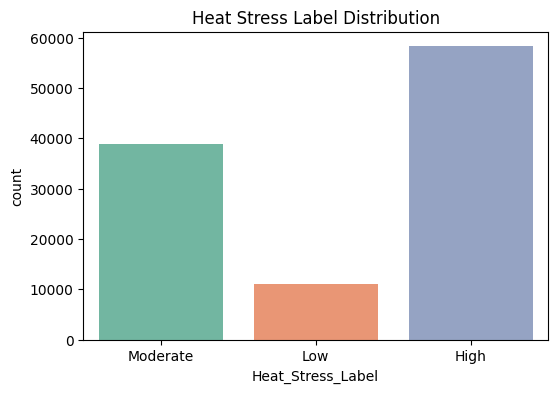


Label Counts:
 Heat_Stress_Label
High        58274
Moderate    38779
Low         10959
Name: count, dtype: int64


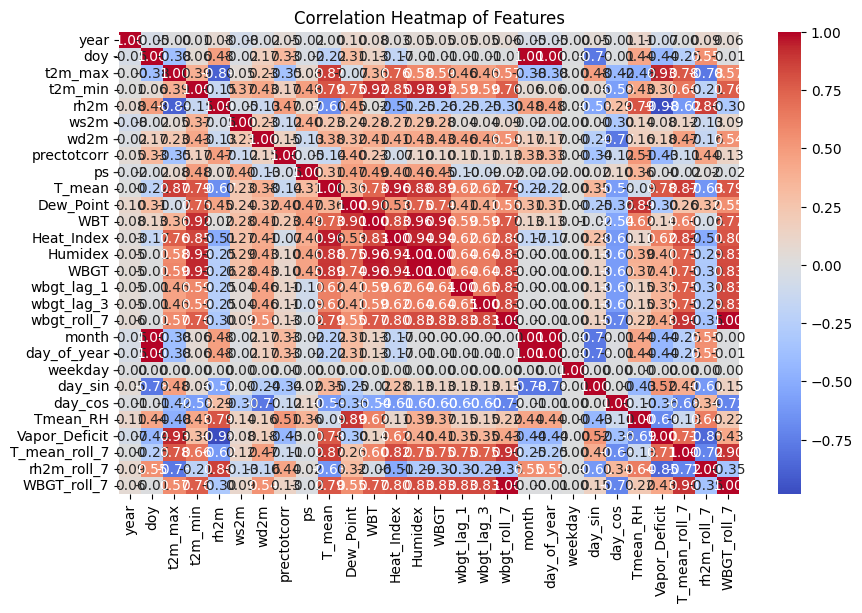

/tmp/ipython-input-1817798787.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Heat_Stress_Label", y=col, data=df, palette="Set3")


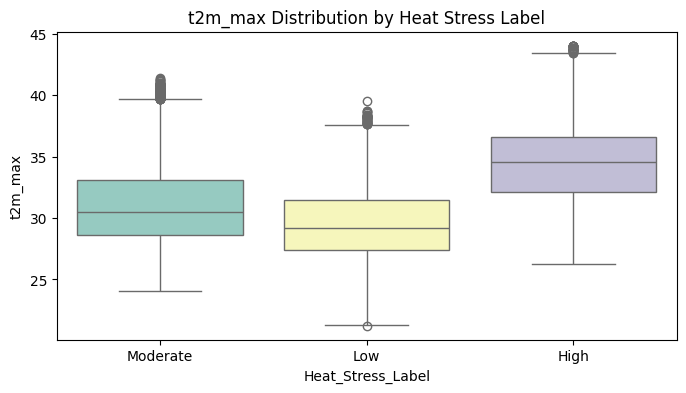

/tmp/ipython-input-1817798787.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Heat_Stress_Label", y=col, data=df, palette="Set3")


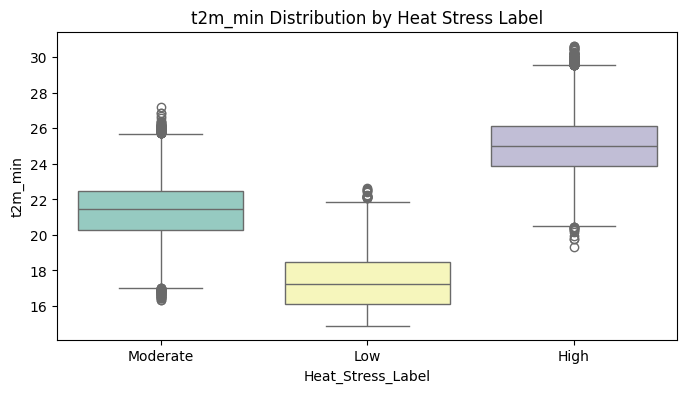

/tmp/ipython-input-1817798787.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Heat_Stress_Label", y=col, data=df, palette="Set3")


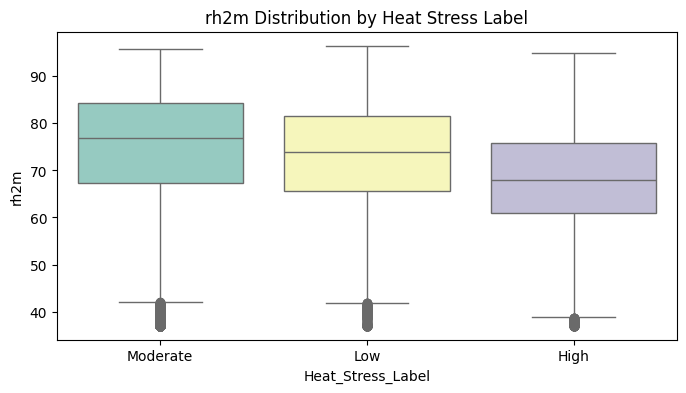

/tmp/ipython-input-1817798787.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Heat_Stress_Label", y=col, data=df, palette="Set3")


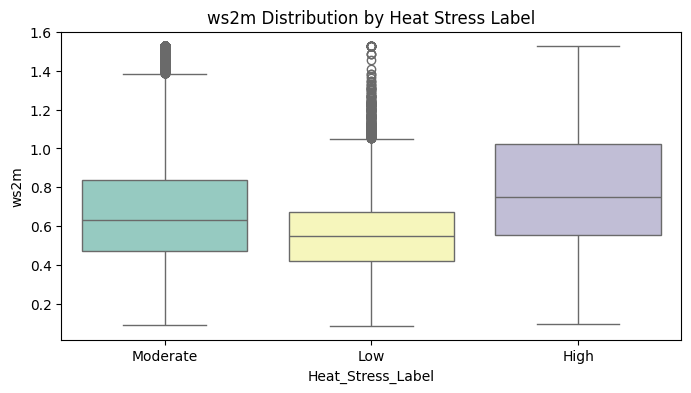

/tmp/ipython-input-1817798787.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Heat_Stress_Label", y=col, data=df, palette="Set3")


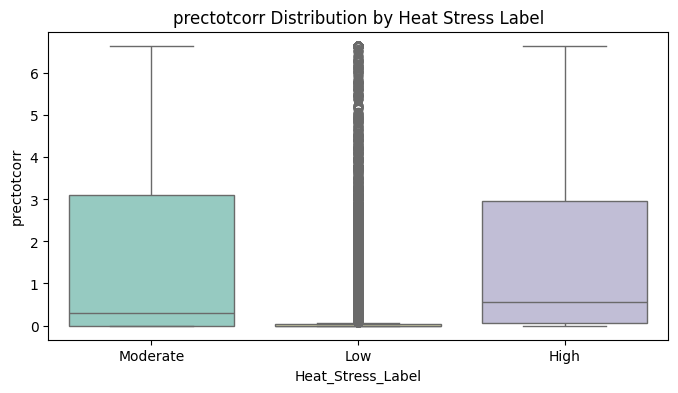

/tmp/ipython-input-1817798787.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Heat_Stress_Label", y=col, data=df, palette="Set3")


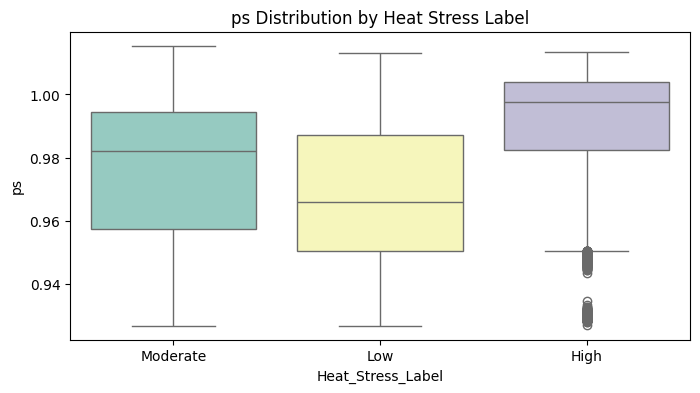

/tmp/ipython-input-1817798787.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Heat_Stress_Label", y=col, data=df, palette="Set3")


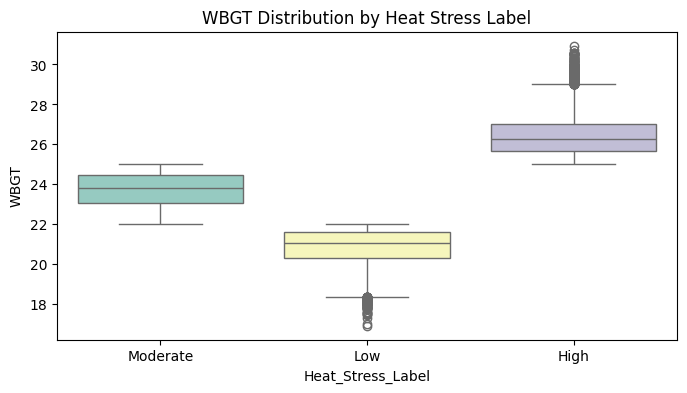

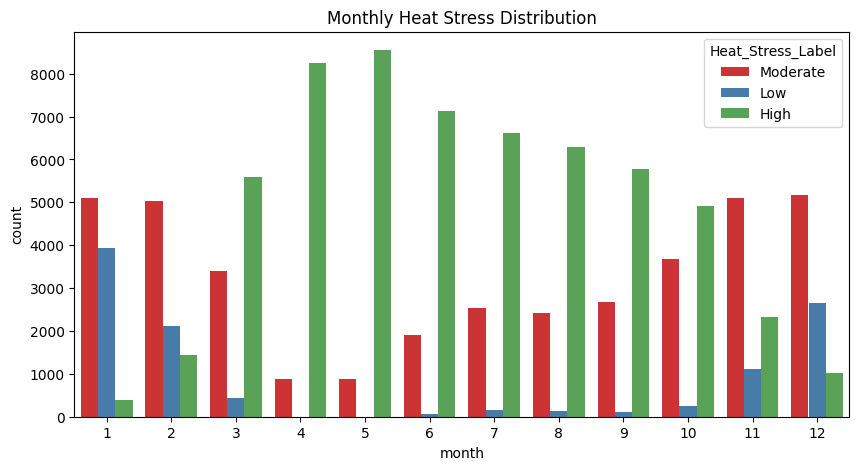

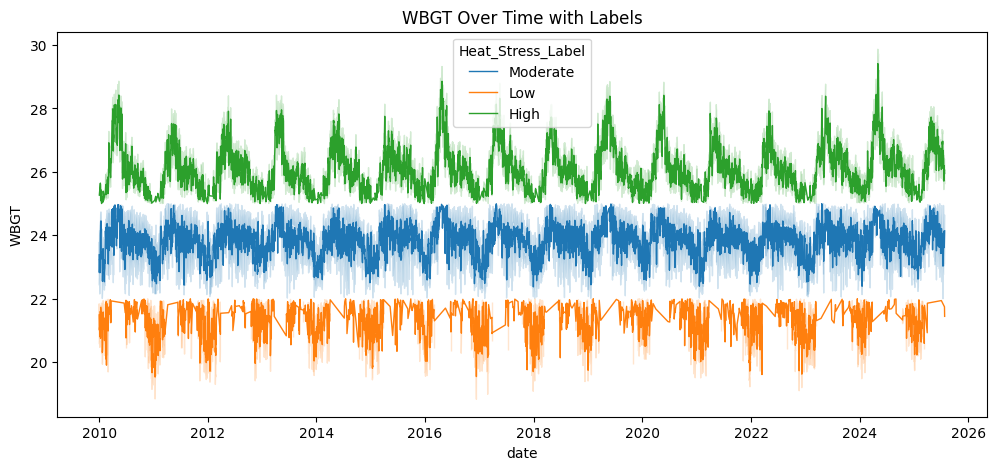

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Load Labeled Dataset
# -------------------------------
file_path = "/content/labeled_dataset.xlsx"   # update if needed
df = pd.read_excel(file_path, engine="openpyxl")

print("✅ Dataset loaded successfully")
print("Columns available:", df.columns.tolist())
print("\nDataset Shape:", df.shape)

# -------------------------------
# 2. Basic Info
# -------------------------------
print("\n🔹 Data Types:\n", df.dtypes)
print("\n🔹 Missing Values:\n", df.isnull().sum())

# -------------------------------
# 3. Label Distribution
# -------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x="Heat_Stress_Label", data=df, palette="Set2")
plt.title("Heat Stress Label Distribution")
plt.show()

print("\nLabel Counts:\n", df["Heat_Stress_Label"].value_counts())

# -------------------------------
# 4. Correlation Heatmap
# -------------------------------
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

# -------------------------------
# 5. Feature Distributions by Label
# -------------------------------
num_features = ["t2m_max", "t2m_min", "rh2m", "ws2m", "prectotcorr", "ps", "WBGT"]

for col in num_features:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        sns.boxplot(x="Heat_Stress_Label", y=col, data=df, palette="Set3")
        plt.title(f"{col} Distribution by Heat Stress Label")
        plt.show()

# -------------------------------
# 6. Temporal Trends (if date column exists)
# -------------------------------
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
    df["month"] = df["date"].dt.month

    plt.figure(figsize=(10,5))
    sns.countplot(x="month", hue="Heat_Stress_Label", data=df, palette="Set1")
    plt.title("Monthly Heat Stress Distribution")
    plt.show()

    # Line plot of WBGT over time
    if "WBGT" in df.columns:
        plt.figure(figsize=(12,5))
        sns.lineplot(x="date", y="WBGT", data=df, hue="Heat_Stress_Label", linewidth=1)
        plt.title("WBGT Over Time with Labels")
        plt.show()



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Helper to load data (added robust loading)
def load_any(path):
    try:
        return pd.read_excel(path, engine="openpyxl")
    except Exception:
        print(f"⚠️ Could not read {path} as Excel, trying CSV instead…")
        return pd.read_csv(path)

# 1️⃣ Load your dataset
file_path = "/content/dataset_with_indices.xlsx"
df = load_any(file_path)

print("✅ Dataset Loaded Successfully!")
print("Columns:", df.columns.tolist())

# 2️⃣ Define features and target
# (You can add or remove columns as needed)
feature_cols = [
    't2m_max', 't2m_min', 'rh2m', 'ws2m', 'wd2m',
    'prectotcorr', 'ps', 'T_mean', 'Dew_Point',
    'WBT', 'Heat_Index', 'Humidex', 'WBGT'
]

# 👉 You’ll need a label column for classification.
# For now, create one if not present — based on WBGT threshold:
if 'heat_stress_class' not in df.columns:
    def classify_heatstress(wbgt):
        if wbgt < 22:
            return 'Low'
        elif 22 <= wbgt <= 25:
            return 'Moderate'
        else:
            return 'High'
    df['heat_stress_class'] = df['WBGT'].apply(classify_heatstress)

target_col = 'heat_stress_class'

# 3️⃣ Split into features (X) and target (y)
X = df[feature_cols]
y = df[target_col]

# 4️⃣ Split into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# 5️⃣ Combine and save
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_path = "/content/train_dataset_with_indices.xlsx"
test_path = "/content/test_dataset_with_indices.xlsx"

train_df.to_excel(train_path, index=False)
test_df.to_excel(test_path, index=False)

print("✅ Train/Test Split Completed Successfully!")
print(f"Training File Saved: {train_path}")
print(f"Testing File Saved: {test_path}")

✅ Dataset Loaded Successfully!
Columns: ['year', 'doy', 'place', 't2m_max', 't2m_min', 'rh2m', 'ws2m', 'wd2m', 'prectotcorr', 'ps', 'date', 'T_mean', 'Dew_Point', 'WBT', 'Heat_Index', 'Humidex', 'WBGT']
✅ Train/Test Split Completed Successfully!
Training File Saved: /content/train_dataset_with_indices.xlsx
Testing File Saved: /content/test_dataset_with_indices.xlsx


implemetation of logistic regression

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-3568198754.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="viridis")



📊 Baseline Logistic Regression Model Performance:
Accuracy  : 0.897
Precision : 0.861
Recall    : 0.836
F1 Score  : 0.847


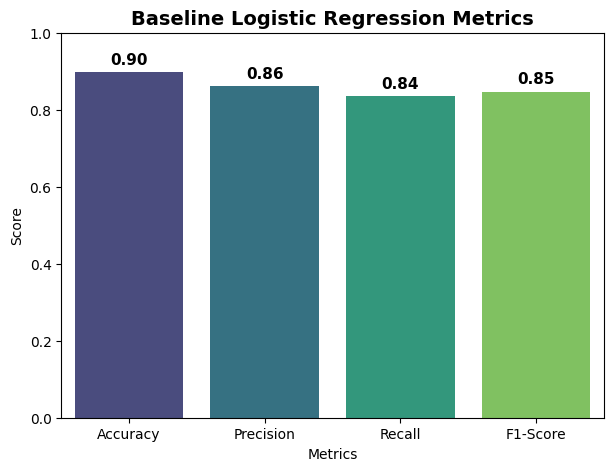

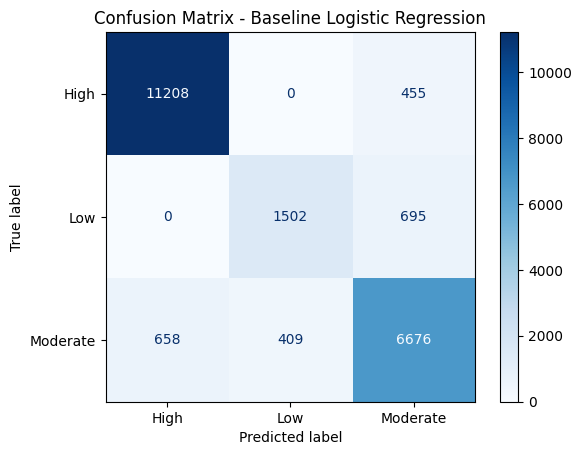

In [ ]:
# --- Import Required Libraries ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # change path as needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
# Example: {'High': 0, 'Low': 1, 'Moderate': 2}

# --- 3️⃣ Select Basic Features ---
# Baseline model uses only key meteorological parameters
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 4️⃣ Split Dataset into Train and Test (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# --- 5️⃣ Train Baseline Logistic Regression Model ---
# Default parameters, no scaling, no regularization tuning
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# --- 6️⃣ Predict on Test Data ---
y_pred = model.predict(X_test)

# --- 7️⃣ Evaluate Metrics ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")

print("\n📊 Baseline Logistic Regression Model Performance:")
print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 8️⃣ Bar Graph Visualization ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title("Baseline Logistic Regression Metrics", fontsize=14, weight="bold")
plt.ylabel("Score")
plt.xlabel("Metrics")

# Add numeric labels above bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")

plt.show()

# --- 9️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Baseline Logistic Regression")
plt.show()

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}

✅ Best Hyperparameters: {'C': 1, 'solver': 'lbfgs'}

🎯 Train/Test Accuracy:
Training Accuracy : 0.986
Testing Accuracy  : 0.989

📈 Cross-Validation Accuracy:
CV Accuracies: [0.98761717 0.9864599  0.98570767 0.98726999 0.98559111]
Mean CV Accuracy: 0.987
Std Dev: 0.001

📊 Test Set Performance:
Accuracy  : 0.989
Precision : 0.989
Recall    : 0.987
F1 Score  : 0.988


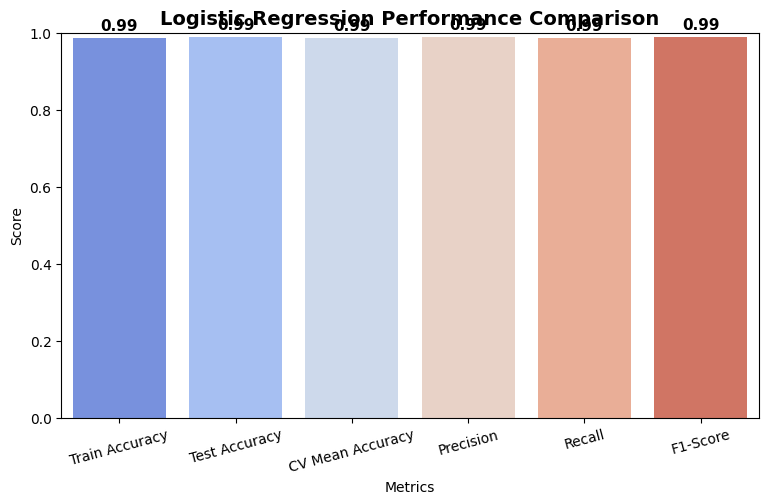

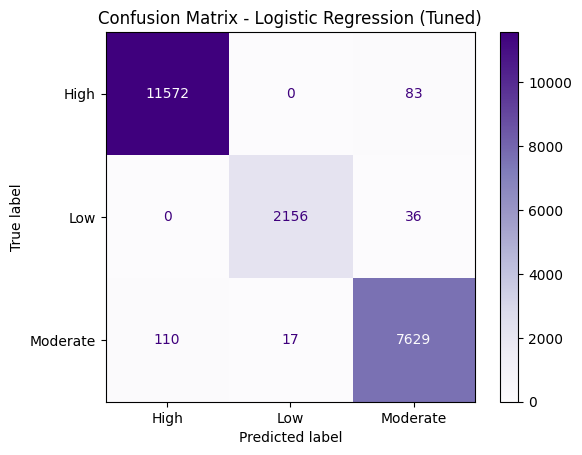

In [ ]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings("ignore")

# --- 1️⃣ Load Labeled Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # change if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
# Example Output: {'High': 0, 'Low': 1, 'Moderate': 2}

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 4️⃣ Train/Test Split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ Logistic Regression + Hyperparameter Tuning ---
log_reg = LogisticRegression(max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']  # efficient solvers
}

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_scaled, y_train)

# --- 7️⃣ Best Model ---
best_model = grid_search.best_estimator_
print("\n✅ Best Hyperparameters:", grid_search.best_params_)

# --- 8️⃣ Evaluate on Train and Test ---
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\n🎯 Train/Test Accuracy:")
print(f"Training Accuracy : {train_accuracy:.3f}")
print(f"Testing Accuracy  : {test_accuracy:.3f}")

# --- 9️⃣ Cross-Validation Check ---
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("\n📈 Cross-Validation Accuracy:")
print(f"CV Accuracies: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.3f}")
print(f"Std Dev: {cv_scores.std():.3f}")

# --- 🔟 Final Evaluation on Test Set ---
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print("\n📊 Test Set Performance:")
print(f"Accuracy  : {test_accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 11️⃣ Visualization: Bar Graph ---
metrics = ["Train Accuracy", "Test Accuracy", "CV Mean Accuracy", "Precision", "Recall", "F1-Score"]
values = [train_accuracy, test_accuracy, cv_scores.mean(), precision, recall, f1]

plt.figure(figsize=(9,5))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.ylim(0, 1)
plt.title("Logistic Regression Performance Comparison", fontsize=14, weight="bold")
plt.ylabel("Score")
plt.xlabel("Metrics")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.xticks(rotation=15)
plt.show()

# --- 12️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Purples", values_format="d")
plt.title("Confusion Matrix - Logistic Regression (Tuned)")
plt.show()



In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.9 MB/s eta 0:00:00


✅ Found 19 districts: ['kanyakumari' 'karur' 'thiruvarur' 'dindigul' 'perambalur' 'theni'
 'coimbatore' 'madurai' 'salem' 'thoothukudi' 'tiruppattur'
 'ramanathapuram' 'kanchipuram' 'viruthunagar' 'puducherry' 'dharmapuri'
 'vellore' 'chennai' 'trichy']
✅ Kanyakumari → Order=(2, 0, 2), AIC=4308.89, Acc=0.897
✅ Karur → Order=(2, 0, 2), AIC=9078.73, Acc=0.350
✅ Thiruvarur → Order=(2, 1, 1), AIC=7857.37, Acc=0.786
✅ Dindigul → Order=(2, 0, 2), AIC=8964.00, Acc=0.383
✅ Perambalur → Order=(2, 0, 2), AIC=8769.30, Acc=0.668
✅ Theni → Order=(2, 0, 1), AIC=9406.34, Acc=0.593
✅ Coimbatore → Order=(2, 0, 2), AIC=9568.86, Acc=0.664
✅ Madurai → Order=(2, 0, 2), AIC=8929.41, Acc=0.302
✅ Salem → Order=(2, 0, 2), AIC=9300.48, Acc=0.438
✅ Thoothukudi → Order=(2, 0, 2), AIC=7551.68, Acc=0.821
✅ Tiruppattur → Order=(2, 0, 2), AIC=9319.67, Acc=0.531
✅ Ramanathapuram → Order=(2, 1, 1), AIC=6770.16, Acc=0.822
✅ Kanchipuram → Order=(2, 0, 2), AIC=7716.87, Acc=0.740
✅ Viruthunagar → Order=(2, 0, 2), AIC=8471.

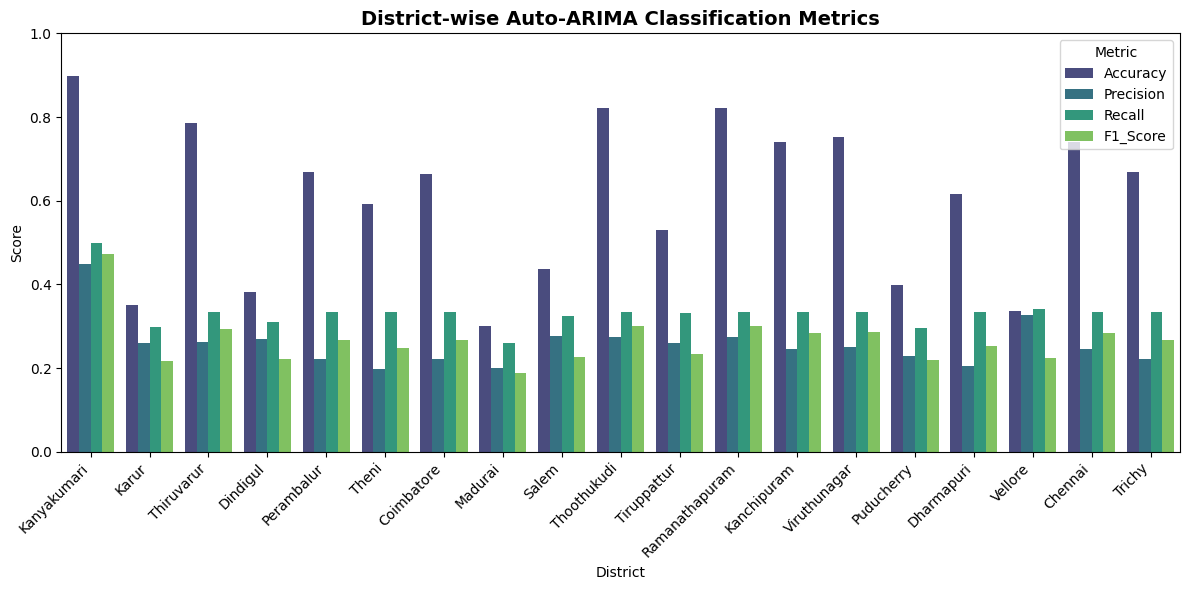


🏆 Best District: Kanyakumari (Accuracy: 0.897)
⚠️ Worst District: Madurai (Accuracy: 0.302)


In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"   # Adjust path as needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Prepare Data ---
df["date"] = pd.to_datetime(df["date"])
df["place"] = df["place"].str.lower()

districts = df["place"].unique()
print(f"✅ Found {len(districts)} districts: {districts}")

# --- 3️⃣ Classification Function ---
def classify_heat_stress(wbgt):
    if wbgt < 22:
        return "Low"
    elif 22 <= wbgt <= 25:
        return "Moderate"
    else:
        return "High"

# --- 4️⃣ ARIMA Parameter Search Space ---
p = d = q = range(0, 3)
pdq_combinations = list(product(p, d, q))

# --- 5️⃣ Storage for Results ---
results_summary = []

# --- 6️⃣ Loop Through Each District ---
for district in districts:
    df_d = df[df["place"] == district].copy().sort_values("date")
    series = df_d["WBGT"].values

    if len(series) < 30:   # skip small series
        print(f"⚠️ Skipping {district}: not enough data ({len(series)} records)")
        continue

    # Train-test split
    split_idx = int(len(series) * 0.8)
    train, test = series[:split_idx], series[split_idx:]

    best_aic = np.inf
    best_order = None
    best_model = None

    # --- Auto-ARIMA Grid Search ---
    for order in pdq_combinations:
        try:
            model = ARIMA(train, order=order)
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = order
                best_model = model_fit
        except:
            continue

    if best_model is None:
        print(f"⚠️ {district}: No valid ARIMA model found.")
        continue

    forecast = best_model.forecast(steps=len(test))

    # --- Classification ---
    actual_classes = [classify_heat_stress(x) for x in test]
    pred_classes = [classify_heat_stress(x) for x in forecast]

    # --- Metrics ---
    accuracy = accuracy_score(actual_classes, pred_classes)
    precision = precision_score(actual_classes, pred_classes, average="macro", zero_division=0)
    recall = recall_score(actual_classes, pred_classes, average="macro", zero_division=0)
    f1 = f1_score(actual_classes, pred_classes, average="macro", zero_division=0)

    results_summary.append({
        "District": district.title(),
        "Best_Order": best_order,
        "AIC": best_aic,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1
    })

    print(f"✅ {district.title()} → Order={best_order}, AIC={best_aic:.2f}, Acc={accuracy:.3f}")

# --- 7️⃣ Results Summary ---
results_df = pd.DataFrame(results_summary)
print("\n📊 ARIMA Summary Across Districts:")
print(results_df)

# --- 8️⃣ Visualization: District-wise Metrics ---
plt.figure(figsize=(12,6))
results_melted = results_df.melt(id_vars=["District"], value_vars=["Accuracy", "Precision", "Recall", "F1_Score"],
                                 var_name="Metric", value_name="Score")
sns.barplot(x="District", y="Score", hue="Metric", data=results_melted, palette="viridis")
plt.title("District-wise Auto-ARIMA Classification Metrics", fontsize=14, weight="bold")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# --- 9️⃣ Optional: Display Best & Worst Districts ---
best_district = results_df.loc[results_df["Accuracy"].idxmax()]
worst_district = results_df.loc[results_df["Accuracy"].idxmin()]

print(f"\n🏆 Best District: {best_district['District']} (Accuracy: {best_district['Accuracy']:.3f})")
print(f"⚠️ Worst District: {worst_district['District']} (Accuracy: {worst_district['Accuracy']:.3f})")



🔍 Processing district: KANYAKUMARI ...
✅ Best order for kanyakumari: (2, 0, 2) (AIC=4308.89)

🔍 Processing district: KARUR ...
✅ Best order for karur: (2, 0, 2) (AIC=9078.73)

🔍 Processing district: THIRUVARUR ...
✅ Best order for thiruvarur: (2, 1, 1) (AIC=7857.37)

🔍 Processing district: DINDIGUL ...
✅ Best order for dindigul: (2, 0, 2) (AIC=8964.00)

🔍 Processing district: PERAMBALUR ...
✅ Best order for perambalur: (2, 0, 2) (AIC=8769.30)

🔍 Processing district: THENI ...
✅ Best order for theni: (2, 0, 1) (AIC=9406.34)

🔍 Processing district: COIMBATORE ...
✅ Best order for coimbatore: (2, 0, 2) (AIC=9568.86)

🔍 Processing district: MADURAI ...
✅ Best order for madurai: (2, 0, 2) (AIC=8929.41)

🔍 Processing district: SALEM ...
✅ Best order for salem: (2, 0, 2) (AIC=9300.48)

🔍 Processing district: THOOTHUKUDI ...
✅ Best order for thoothukudi: (2, 0, 2) (AIC=7551.68)

🔍 Processing district: TIRUPPATTUR ...
✅ Best order for tiruppattur: (2, 0, 2) (AIC=9319.67)

🔍 Processing district

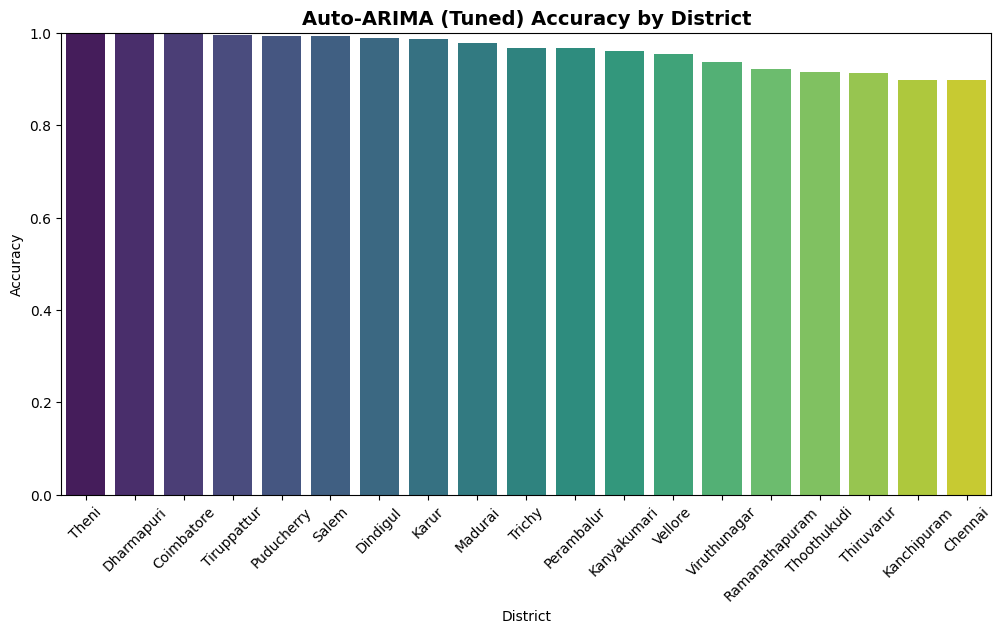

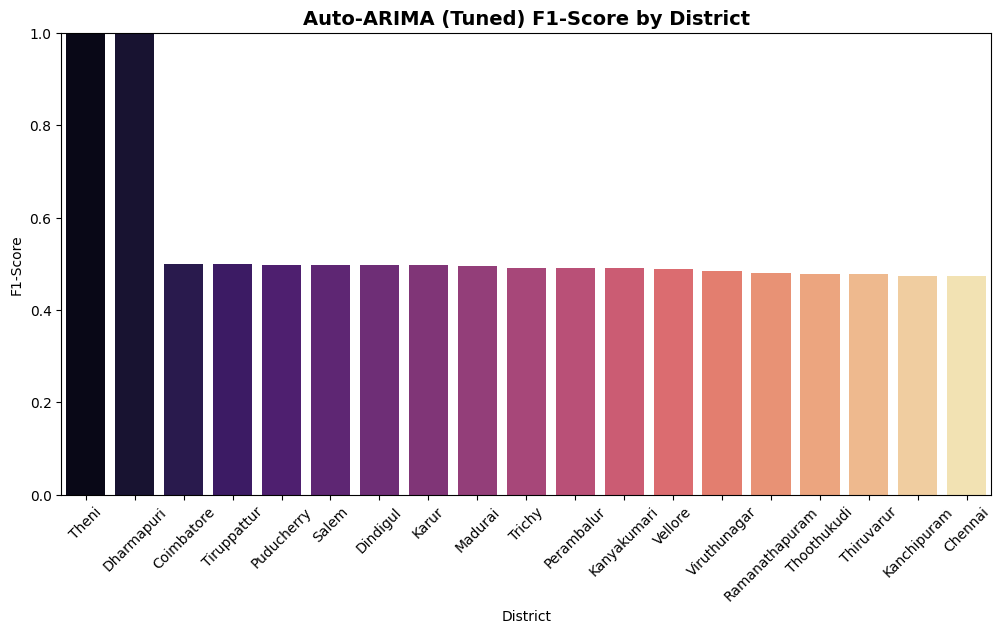


💾 Results saved to 'auto_arima_all_districts_results.xlsx'


In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"   # change path if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Preprocess ---
df["place"] = df["place"].str.lower()
df["date"] = pd.to_datetime(df["date"])
districts = df["place"].unique()

# --- 3️⃣ Define Heat Stress Classification Function ---
def classify_heat_stress(wbgt):
    if wbgt < 28:
        return "Low"
    elif 28 <= wbgt <= 32:
        return "Moderate"
    else:
        return "High"

# --- 4️⃣ Initialize Results Storage ---
results_summary = []

# --- 5️⃣ Hyperparameter Search Grid ---
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
param_grid = list(product(p, d, q))

# --- 6️⃣ Loop Over Each District ---
for district in districts:
    print(f"\n🔍 Processing district: {district.upper()} ...")

    df_d = df[df["place"] == district].sort_values("date")
    series = df_d["WBGT"].values

    if len(series) < 20:  # skip very short series
        print(f"⚠️ Skipping {district} (not enough data)")
        continue

    split_idx = int(len(series) * 0.8)
    train, test = series[:split_idx], series[split_idx:]

    best_aic = np.inf
    best_order = None
    best_model = None

    # --- Hyperparameter Tuning Loop ---
    for order in param_grid:
        try:
            model = ARIMA(train, order=order)
            fitted = model.fit()
            if fitted.aic < best_aic:
                best_aic = fitted.aic
                best_order = order
                best_model = fitted
        except:
            continue

    if best_model is None:
        print(f"⚠️ No valid model found for {district}")
        continue

    print(f"✅ Best order for {district}: {best_order} (AIC={best_aic:.2f})")

    # --- Forecast & Evaluate ---
    forecast = best_model.forecast(steps=len(test))

    actual_classes = [classify_heat_stress(x) for x in test]
    pred_classes = [classify_heat_stress(x) for x in forecast]

    accuracy = accuracy_score(actual_classes, pred_classes)
    precision = precision_score(actual_classes, pred_classes, average="macro", zero_division=0)
    recall = recall_score(actual_classes, pred_classes, average="macro", zero_division=0)
    f1 = f1_score(actual_classes, pred_classes, average="macro", zero_division=0)

    results_summary.append({
        "District": district.title(),
        "Best_Order": best_order,
        "AIC": best_aic,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1
    })

# --- 7️⃣ Combine All District Results ---
results_df = pd.DataFrame(results_summary)
print("\n📊 Summary of All Districts:")
print(results_df.sort_values("Accuracy", ascending=False))

# --- 8️⃣ Visualization: Comparative Metrics ---
plt.figure(figsize=(12,6))
sns.barplot(x="District", y="Accuracy", data=results_df.sort_values("Accuracy", ascending=False), palette="viridis")
plt.title("Auto-ARIMA (Tuned) Accuracy by District", fontsize=14, weight="bold")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x="District", y="F1_Score", data=results_df.sort_values("F1_Score", ascending=False), palette="magma")
plt.title("Auto-ARIMA (Tuned) F1-Score by District", fontsize=14, weight="bold")
plt.xticks(rotation=45)
plt.ylabel("F1-Score")
plt.ylim(0,1)
plt.show()

# --- 9️⃣ Save Results ---
results_df.to_excel("auto_arima_all_districts_results.xlsx", index=False)
print("\n💾 Results saved to 'auto_arima_all_districts_results.xlsx'")


SARIMAMAX model

📊 SARIMAX Model (Coimbatore) Classification Metrics:
Accuracy  : 0.981
Precision : 0.981
Recall    : 0.967
F1 Score  : 0.974


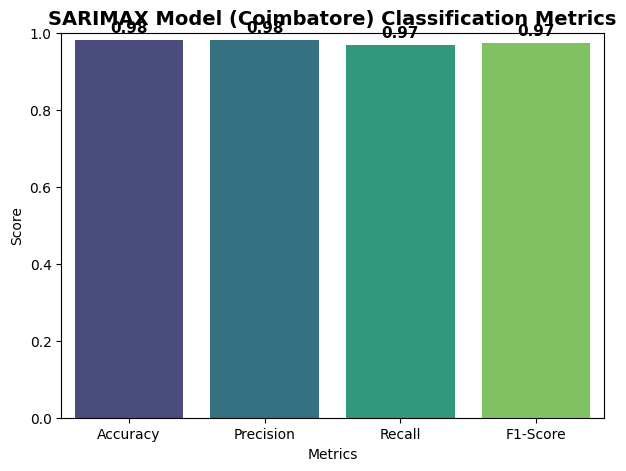

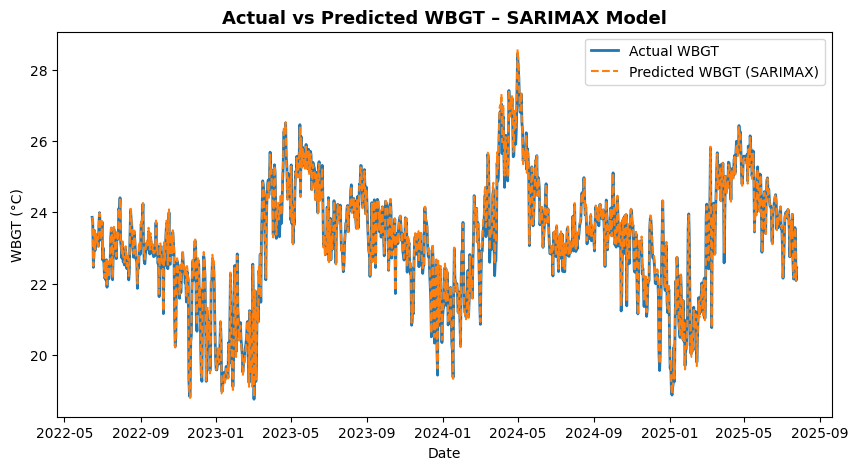

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # Change path if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Select One District (Example: Coimbatore) ---
df = df[df["place"].str.lower() == "coimbatore"].copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

# --- 3️⃣ Prepare Data ---
# Target variable
series = df["WBGT"].values

# Optional exogenous variables (can improve model)
exog_features = ["t2m_max", "t2m_min", "rh2m", "ws2m", "prectotcorr", "ps"]
exog = df[exog_features].values

# --- 4️⃣ Train/Test Split (80/20 time-based) ---
split_idx = int(len(series) * 0.8)
train, test = series[:split_idx], series[split_idx:]
exog_train, exog_test = exog[:split_idx], exog[split_idx:]

# --- 5️⃣ Define SARIMAX Model ---
# order = (p, d, q)
# seasonal_order = (P, D, Q, s)
# Here s = 12 → monthly seasonality (adjust if daily → s=7 for weekly)
model = SARIMAX(train,
                exog=exog_train,
                order=(2, 1, 2),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

fitted_model = model.fit(disp=False)

# --- 6️⃣ Forecast WBGT ---
forecast = fitted_model.forecast(steps=len(test), exog=exog_test)

# --- 7️⃣ Convert WBGT to Heat Stress Classes ---
def classify_heat_stress(wbgt):
    if wbgt < 22:
        return "Low"
    elif 22 <= wbgt <= 25:
        return "Moderate"
    else:
        return "High"

actual_classes = [classify_heat_stress(x) for x in test]
pred_classes = [classify_heat_stress(x) for x in forecast]

# --- 8️⃣ Classification Metrics ---
accuracy = accuracy_score(actual_classes, pred_classes)
precision = precision_score(actual_classes, pred_classes, average='macro', zero_division=0)
recall = recall_score(actual_classes, pred_classes, average='macro', zero_division=0)
f1 = f1_score(actual_classes, pred_classes, average='macro', zero_division=0)

print("📊 SARIMAX Model (Coimbatore) Classification Metrics:")
print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 9️⃣ Visualization: Metrics Bar Graph ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title("SARIMAX Model (Coimbatore) Classification Metrics", fontsize=14, weight="bold")
plt.ylabel("Score")
plt.xlabel("Metrics")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 🔟 Actual vs Predicted WBGT ---
plt.figure(figsize=(10,5))
plt.plot(df["date"].iloc[-len(test):], test, label="Actual WBGT", linewidth=2)
plt.plot(df["date"].iloc[-len(test):], forecast, label="Predicted WBGT (SARIMAX)", linestyle="--")
plt.title("Actual vs Predicted WBGT – SARIMAX Model", fontsize=13, weight="bold")
plt.xlabel("Date")
plt.ylabel("WBGT (°C)")
plt.legend()
plt.show()



🔍 Running fast SARIMAX hyperparameter tuning for Coimbatore ...

✅ Best SARIMAX parameters: (1, 1, 1, 0, 0, 0), AIC=-15492.01

📊 SARIMAX Classification Metrics:
Accuracy  : 0.982
Precision : 0.982
Recall    : 0.971
F1 Score  : 0.977


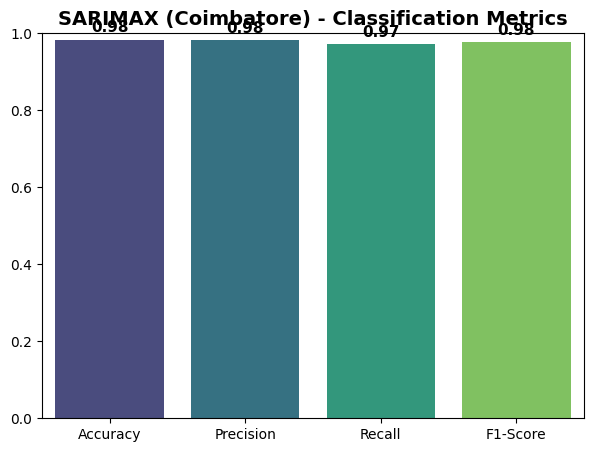

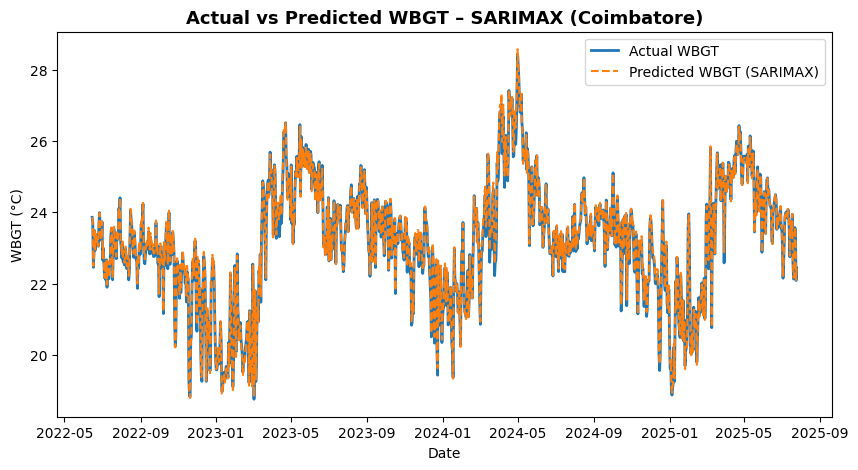

In [ ]:
# --- 1️⃣ Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings("ignore")

# --- 2️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # change path if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 3️⃣ Select District (Example: Coimbatore) ---
district_name = "coimbatore"
df = df[df["place"].str.lower() == district_name].copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

# --- 4️⃣ Prepare Data ---
series = df["WBGT"].values
exog_features = ["t2m_max", "t2m_min", "rh2m", "ws2m", "prectotcorr", "ps"]
exog = df[exog_features].values

# --- 5️⃣ Train/Test Split (80/20 time-based) ---
split_idx = int(len(series) * 0.8)
train, test = series[:split_idx], series[split_idx:]
exog_train, exog_test = exog[:split_idx], exog[split_idx:]

# --- 6️⃣ Fast Hyperparameter Tuning (statsmodels SARIMAX) ---
p = d = q = range(0, 2)      # reduced search space for speed
P = D = Q = range(0, 2)
s = 12  # seasonal period (monthly if daily data)

best_aic = np.inf
best_model = None
best_params = None

print(f"\n🔍 Running fast SARIMAX hyperparameter tuning for {district_name.title()} ...")

for (p_, d_, q_, P_, D_, Q_) in product(p, d, q, P, D, Q):
    try:
        model = SARIMAX(train,
                        exog=exog_train,
                        order=(p_, d_, q_),
                        seasonal_order=(P_, D_, Q_, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        fitted = model.fit(disp=False)
        if fitted.aic < best_aic:
            best_aic = fitted.aic
            best_model = fitted
            best_params = (p_, d_, q_, P_, D_, Q_)
    except:
        continue

print(f"\n✅ Best SARIMAX parameters: {best_params}, AIC={best_aic:.2f}")

# --- 7️⃣ Forecast ---
forecast = best_model.forecast(steps=len(test), exog=exog_test)

# --- 8️⃣ Classification Function ---
def classify_heat_stress(wbgt):
    if wbgt < 22:
        return "Low"
    elif 22 <= wbgt <= 25:
        return "Moderate"
    else:
        return "High"

actual_classes = [classify_heat_stress(x) for x in test]
pred_classes = [classify_heat_stress(x) for x in forecast]

# --- 9️⃣ Evaluation Metrics ---
accuracy = accuracy_score(actual_classes, pred_classes)
precision = precision_score(actual_classes, pred_classes, average='macro', zero_division=0)
recall = recall_score(actual_classes, pred_classes, average='macro', zero_division=0)
f1 = f1_score(actual_classes, pred_classes, average='macro', zero_division=0)

print("\n📊 SARIMAX Classification Metrics:")
print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 🔟 Metrics Bar Chart ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title(f"SARIMAX ({district_name.title()}) - Classification Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 1️⃣1️⃣ Actual vs Predicted WBGT Plot ---
plt.figure(figsize=(10,5))
plt.plot(df["date"].iloc[-len(test):], test, label="Actual WBGT", linewidth=2)
plt.plot(df["date"].iloc[-len(test):], forecast, label="Predicted WBGT (SARIMAX)", linestyle="--")
plt.title(f"Actual vs Predicted WBGT – SARIMAX ({district_name.title()})", fontsize=13, weight="bold")
plt.xlabel("Date")
plt.ylabel("WBGT (°C)")
plt.legend()
plt.show()



decision tree

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}

📊 Decision Tree Test Set Performance:
Accuracy  : 0.977
Precision : 0.972
Recall    : 0.971
F1 Score  : 0.971


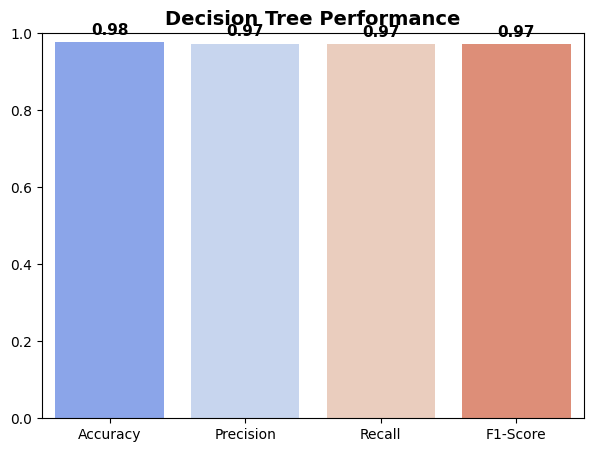

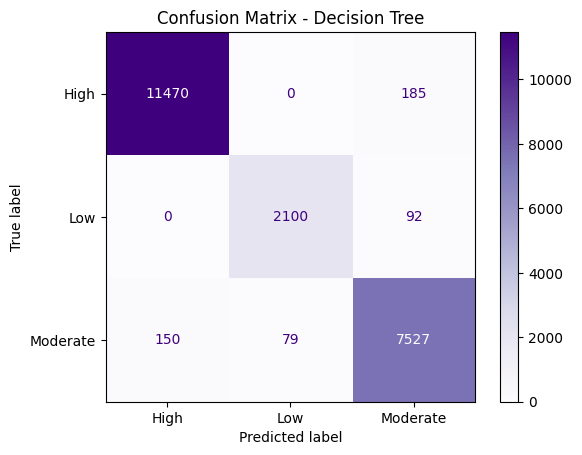

In [ ]:
# --- 1️⃣ Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

# --- 2️⃣ Load Labeled Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # change if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 3️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 4️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 5️⃣ Train/Test Split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6️⃣ Feature Scaling (Optional for Decision Trees) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7️⃣ Train Decision Tree Classifier ---
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

# --- 8️⃣ Predict on Test Set ---
y_test_pred = dt_model.predict(X_test_scaled)

# --- 9️⃣ Evaluation Metrics ---
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print("\n📊 Decision Tree Test Set Performance:")
print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 🔟 Metrics Bar Graph ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.ylim(0, 1)
plt.title("Decision Tree Performance", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 1️⃣1️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Purples", values_format="d")
plt.title("Confusion Matrix - Decision Tree")
plt.show()


Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}

✅ Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

🎯 Train/Test Accuracy:
Training Accuracy : 1.000
Testing Accuracy  : 0.980

📊 Test Set Performance:
Accuracy  : 0.980
Precision : 0.976
Recall    : 0.976
F1 Score  : 0.976


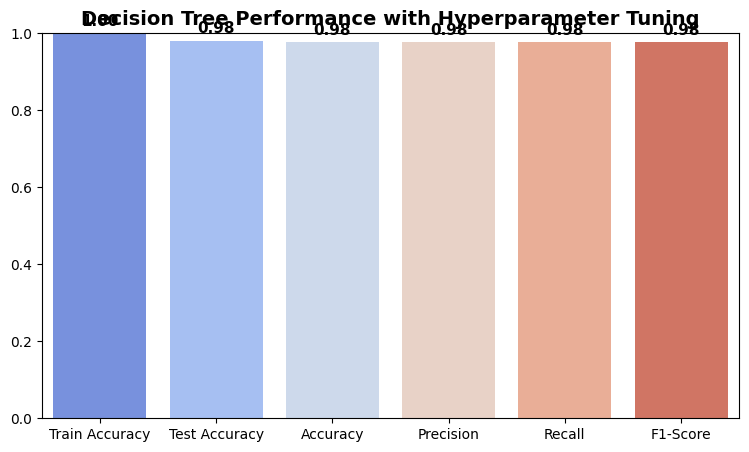

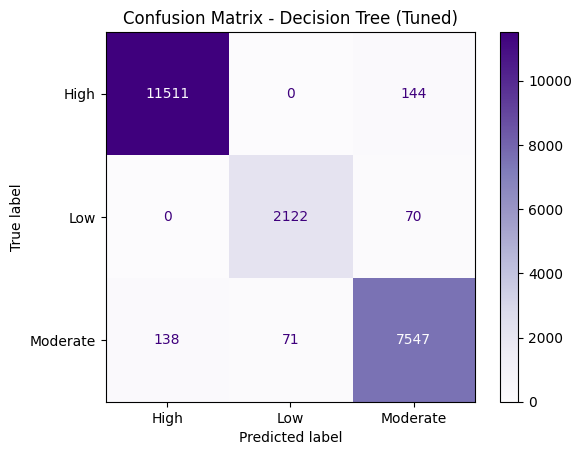

In [ ]:
# --- 1️⃣ Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

# --- 2️⃣ Load Labeled Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # change if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 3️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 4️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 5️⃣ Train/Test Split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6️⃣ Feature Scaling (Optional for Decision Trees) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7️⃣ Decision Tree + Hyperparameter Tuning ---
dt_model = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_scaled, y_train)

# --- 8️⃣ Best Model ---
best_model = grid_search.best_estimator_
print("\n✅ Best Hyperparameters:", grid_search.best_params_)

# --- 9️⃣ Evaluate Train and Test Accuracy ---
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\n🎯 Train/Test Accuracy:")
print(f"Training Accuracy : {train_accuracy:.3f}")
print(f"Testing Accuracy  : {test_accuracy:.3f}")

# --- 🔟 Evaluate Test Metrics ---
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print("\n📊 Test Set Performance:")
print(f"Accuracy  : {test_accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 1️⃣1️⃣ Metrics Bar Graph ---
metrics = ["Train Accuracy", "Test Accuracy", "Accuracy","Precision", "Recall", "F1-Score"]
values = [train_accuracy, test_accuracy, accuracy, precision, recall, f1]

plt.figure(figsize=(9,5))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.ylim(0, 1)
plt.title("Decision Tree Performance with Hyperparameter Tuning", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 1️⃣2️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Purples", values_format="d")
plt.title("Confusion Matrix - Decision Tree (Tuned)")
plt.show()

rf model

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}

🎯 Train/Test Accuracy:
Training Accuracy : 1.000
Testing Accuracy  : 0.978

📊 Test Set Performance:
Accuracy  : 0.978
Precision : 0.976
Recall    : 0.971
F1 Score  : 0.974


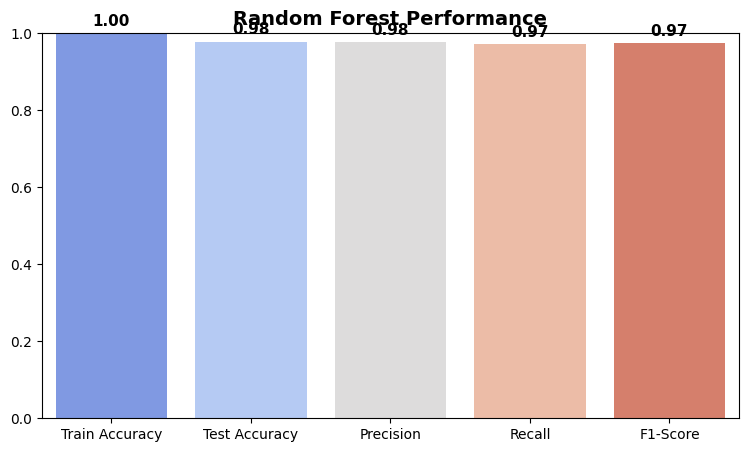

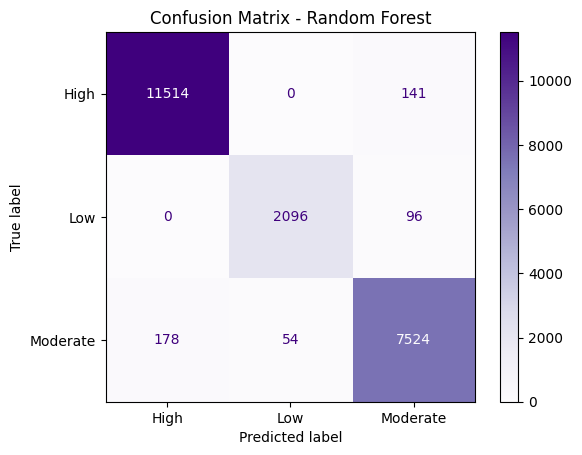

In [ ]:
# --- 1️⃣ Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

# --- 2️⃣ Load Labeled Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # change if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 3️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 4️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 5️⃣ Train/Test Split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6️⃣ Feature Scaling (Optional for Random Forest) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7️⃣ Train Random Forest Classifier ---
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# --- 8️⃣ Predict on Test Set ---
y_test_pred = rf_model.predict(X_test_scaled)
y_train_pred = rf_model.predict(X_train_scaled)

# --- 9️⃣ Evaluate Train and Test Accuracy ---
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\n🎯 Train/Test Accuracy:")
print(f"Training Accuracy : {train_accuracy:.3f}")
print(f"Testing Accuracy  : {test_accuracy:.3f}")

# --- 🔟 Evaluate Test Metrics ---
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print("\n📊 Test Set Performance:")
print(f"Accuracy  : {test_accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

metrics = ["Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1-Score"]
values = [train_accuracy, test_accuracy, precision, recall, f1]

plt.figure(figsize=(9,5))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.ylim(0, 1)
plt.title("Random Forest Performance", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()



# --- 1️⃣2️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Purples", values_format="d")
plt.title("Confusion Matrix - Random Forest")
plt.show()

XGBoost model

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}

🎯 Train/Test Accuracy:
Training Accuracy : 0.996
Testing Accuracy  : 0.987

📊 Test Set Performance:
Accuracy  : 0.987
Precision : 0.986
Recall    : 0.983
F1 Score  : 0.984


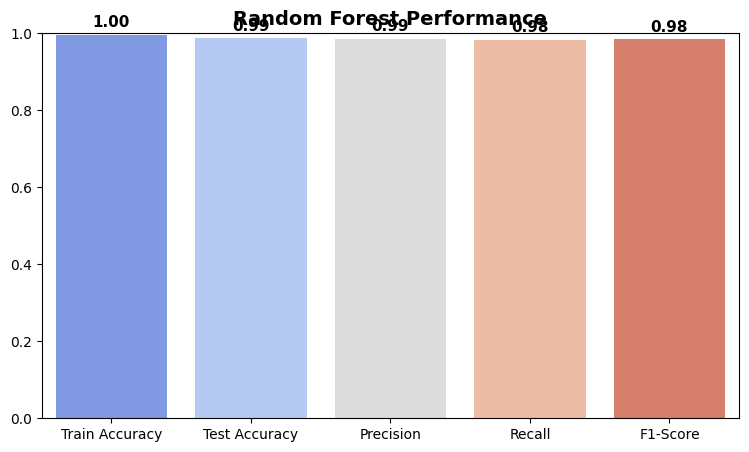

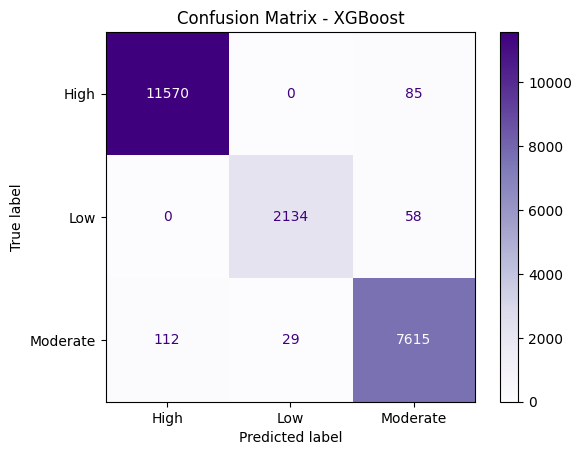

In [ ]:
# --- 1️⃣ Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

# --- 2️⃣ Load Labeled Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # change if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 3️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 4️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 5️⃣ Train/Test Split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6️⃣ Feature Scaling (Optional for XGBoost) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7️⃣ Train XGBoost Classifier ---
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1
)
xgb_model.fit(X_train_scaled, y_train)

# --- 8️⃣ Predict on Train and Test ---
y_train_pred = xgb_model.predict(X_train_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

# --- 9️⃣ Evaluate Train/Test Accuracy ---
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\n🎯 Train/Test Accuracy:")
print(f"Training Accuracy : {train_accuracy:.3f}")
print(f"Testing Accuracy  : {test_accuracy:.3f}")

# --- 🔟 Evaluate Test Metrics ---
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print("\n📊 Test Set Performance:")
print(f"Accuracy  : {test_accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

metrics = ["Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1-Score"]
values = [train_accuracy, test_accuracy, precision, recall, f1]

plt.figure(figsize=(9,5))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.ylim(0, 1)
plt.title("Random Forest Performance", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()


# --- 1️⃣2️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Purples", values_format="d")
plt.title("Confusion Matrix - XGBoost")
plt.show()



Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Best Hyperparameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 1.0}

🎯 Train/Test Accuracy:
Training Accuracy : 1.000
Testing Accuracy  : 0.992
Precision : 0.991
Recall    : 0.989
F1 Score  : 0.990


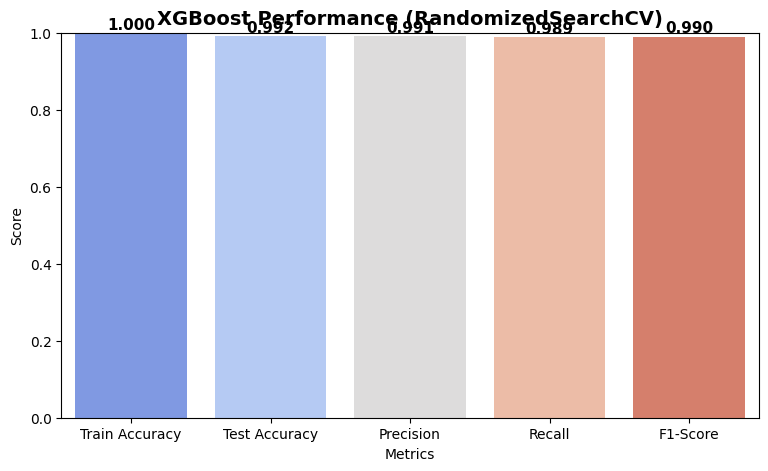

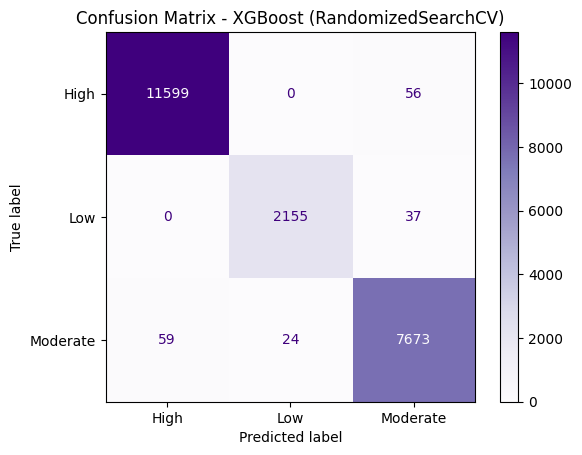

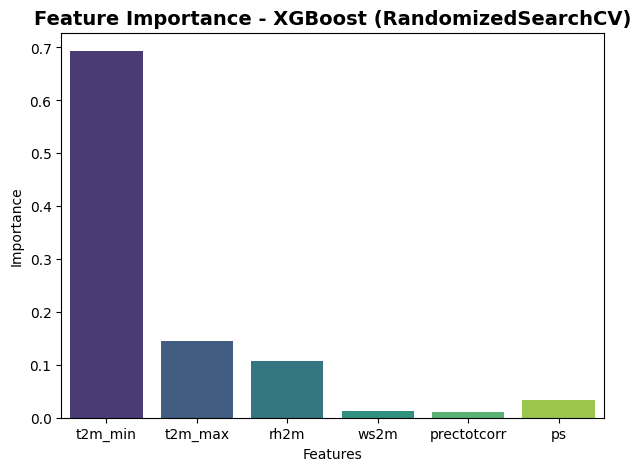

In [ ]:
# --- 1️⃣ Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

# --- 2️⃣ Load Labeled Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # change if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 3️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 4️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 5️⃣ Train/Test Split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6️⃣ Feature Scaling (Optional for XGBoost) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7️⃣ XGBoost + Randomized Hyperparameter Tuning ---
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,         # 🔹 30 random combinations
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

# --- 8️⃣ Best Model ---
best_model = random_search.best_estimator_
print("\n✅ Best Hyperparameters:", random_search.best_params_)

# --- 9️⃣ Predict on Train and Test ---
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

# --- 🔟 Evaluate Metrics ---
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print("\n🎯 Train/Test Accuracy:")
print(f"Training Accuracy : {train_accuracy:.3f}")
print(f"Testing Accuracy  : {test_accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 1️⃣1️⃣ Metrics Bar Graph ---
metrics = ["Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1-Score"]
values = [train_accuracy, test_accuracy, precision, recall, f1]

plt.figure(figsize=(9,5))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.ylim(0, 1)
plt.title("XGBoost Performance (RandomizedSearchCV)", fontsize=14, weight="bold")
plt.ylabel("Score")
plt.xlabel("Metrics")
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 1️⃣2️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Purples", values_format="d")
plt.title("Confusion Matrix - XGBoost (RandomizedSearchCV)")
plt.show()

# --- 1️⃣3️⃣ Feature Importance ---
importances = best_model.feature_importances_
plt.figure(figsize=(7,5))
sns.barplot(x=feature_cols, y=importances, palette="viridis")
plt.title("Feature Importance - XGBoost (RandomizedSearchCV)", fontsize=14, weight="bold")
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()


LightGBM model

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}

📊 LightGBM Model Performance:
Accuracy  : 0.989
Precision : 0.987
Recall    : 0.986
F1 Score  : 0.986


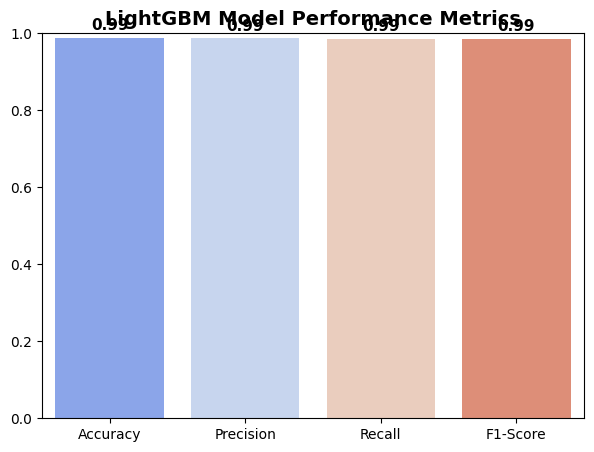

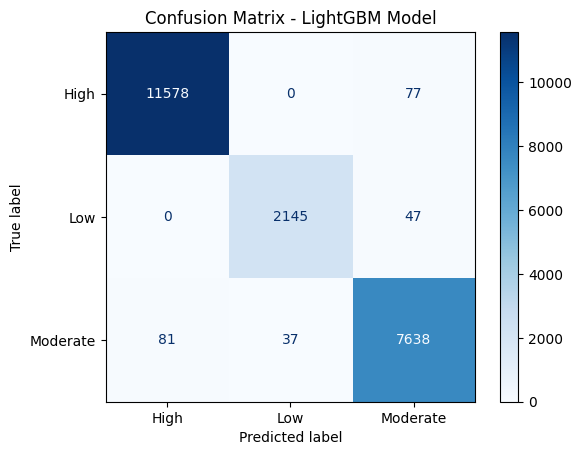

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import lightgbm as lgb

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # change path if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
# Example: {'High': 0, 'Low': 1, 'Moderate': 2}

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 4️⃣ Train-Test Split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ LightGBM Model Implementation ---
lgbm_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y)),
    boosting_type='gbdt',
    random_state=42,
    verbose=-1
)

# --- 7️⃣ Train the Model ---
lgbm_model.fit(X_train_scaled, y_train)

# --- 8️⃣ Make Predictions ---
y_pred = lgbm_model.predict(X_test_scaled)

# --- 9️⃣ Evaluate Model ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 LightGBM Model Performance:")
print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 🔟 Visualization: Bar Graph for Metrics ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.ylim(0, 1)
plt.title("LightGBM Model Performance Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 11️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - LightGBM Model")
plt.show()



Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
Fitting 3 folds for each of 25 candidates, totalling 75 fits

✅ Best Parameters: {'subsample': 0.7, 'num_leaves': np.int64(15), 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

📈 Accuracy Comparison:
Training Accuracy : 0.999
Testing Accuracy  : 0.990

📊 LightGBM (Randomized Tuned) Performance:
Accuracy  : 0.990
Precision : 0.989
Recall    : 0.988
F1 Score  : 0.988


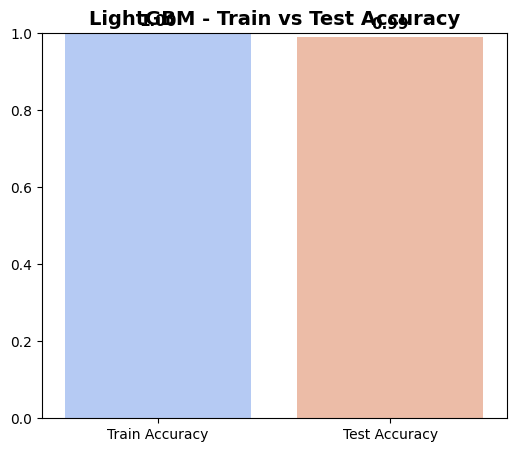

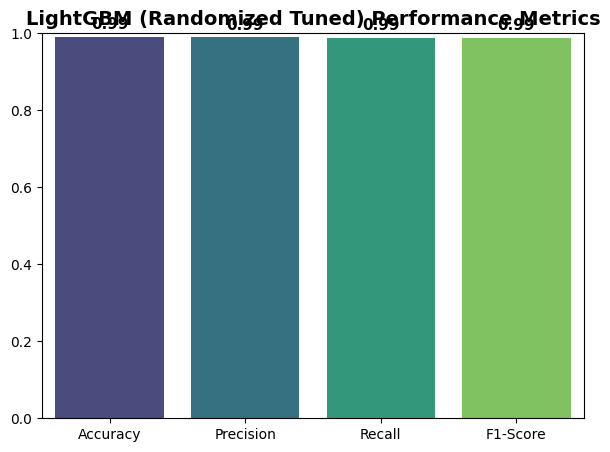

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import lightgbm as lgb

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 4️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ Initialize Base LightGBM Model ---
lgbm = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y)),
    boosting_type='gbdt',
    random_state=42,
    verbose=-1
)

# --- 7️⃣ Define Parameter Search Space (Simplified for Speed) ---
param_dist = {
    'num_leaves': np.arange(15, 80, 10),
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [-1, 5, 10, 15],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# --- 8️⃣ RandomizedSearchCV (Much Faster) ---
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=25,            # only 25 random combinations (vs. hundreds in grid)
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
random_search.fit(X_train_scaled, y_train)

# --- 9️⃣ Best Model ---
best_model = random_search.best_estimator_
print("\n✅ Best Parameters:", random_search.best_params_)

# --- 🔟 Evaluate Train and Test Accuracy ---
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy : {train_acc:.3f}")
print(f"Testing Accuracy  : {test_acc:.3f}")

# --- 11️⃣ Evaluation Metrics ---
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print("\n📊 LightGBM (Randomized Tuned) Performance:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 12️⃣ Visualization: Train vs Test Accuracy ---
plt.figure(figsize=(6,5))
sns.barplot(x=["Train Accuracy", "Test Accuracy"], y=[train_acc, test_acc], palette="coolwarm")
plt.title("LightGBM - Train vs Test Accuracy", fontsize=14, weight="bold")
plt.ylim(0, 1)
for i, v in enumerate([train_acc, test_acc]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 13️⃣ Visualization: Metrics ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title("LightGBM (Randomized Tuned) Performance Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()




CatBoost Model

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
0:	learn: 0.8682776	test: 0.8708513	best: 0.8708513 (0)	total: 72.2ms	remaining: 36s
100:	learn: 0.9447974	test: 0.9419062	best: 0.9419062 (100)	total: 4.74s	remaining: 18.7s
200:	learn: 0.9689731	test: 0.9657918	best: 0.9657918 (200)	total: 11.7s	remaining: 17.4s
300:	learn: 0.9785670	test: 0.9762070	best: 0.9762070 (300)	total: 16.2s	remaining: 10.7s
400:	learn: 0.9842378	test: 0.9823173	best: 0.9824099 (396)	total: 20.9s	remaining: 5.17s
499:	learn: 0.9872004	test: 0.9847706	best: 0.9849095 (494)	total: 27.1s	remaining: 0us

bestTest = 0.9849095033
bestIteration = 494

Shrink model to first 495 iterations.

📊 CatBoost Model Performance:
Accuracy  : 0.985
Precision : 0.985
Recall    : 0.981
F1 Score  : 0.983


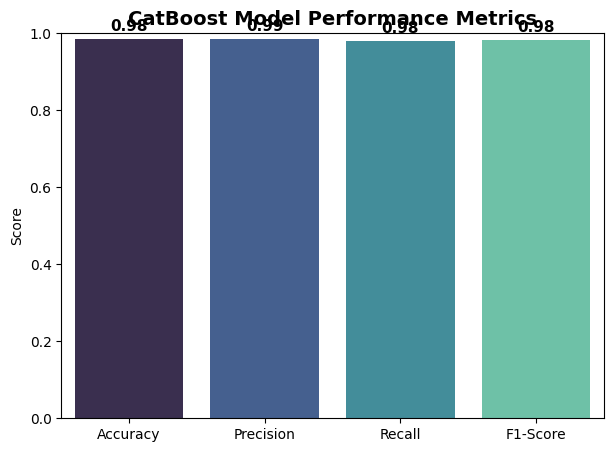

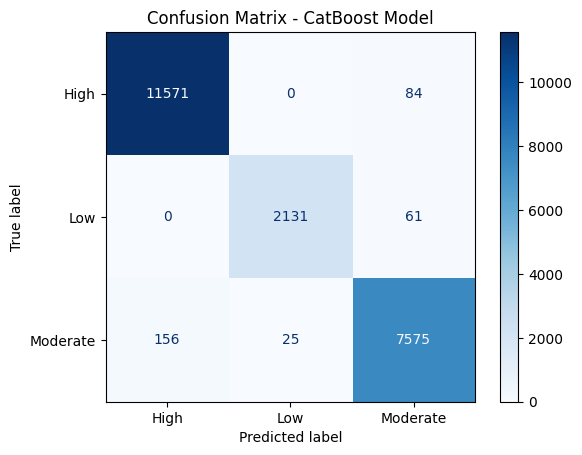

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier, Pool

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # change if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
# Example: {'High': 0, 'Low': 1, 'Moderate': 2}

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 4️⃣ Train-Test Split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Scale Features (Optional) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ Initialize CatBoost Model ---
cat_model = CatBoostClassifier(
    iterations=500,           # number of boosting iterations
    learning_rate=0.05,       # step size
    depth=6,                  # tree depth
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50  # stops if no improvement
)

# --- 7️⃣ Fit Model ---
cat_model.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test), plot=False)

# --- 8️⃣ Predictions ---
y_pred = cat_model.predict(X_test_scaled)
y_pred = y_pred.flatten()  # CatBoost returns 2D array

# --- 9️⃣ Evaluation Metrics ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 CatBoost Model Performance:")
print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 🔟 Visualization: Metrics Bar Graph ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="mako")
plt.ylim(0, 1)
plt.title("CatBoost Model Performance Metrics", fontsize=14, weight="bold")
plt.ylabel("Score")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 11️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - CatBoost Model")
plt.show()


Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Best Hyperparameters Found:
{'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 500, 'depth': 10, 'bagging_temperature': 1.0}

📈 Accuracy Comparison:
Training Accuracy  : 0.997
Testing Accuracy   : 0.991

📊 CatBoost (Random Search Tuned) Metrics:
Accuracy  : 0.991
Precision : 0.991
Recall    : 0.988
F1 Score  : 0.990


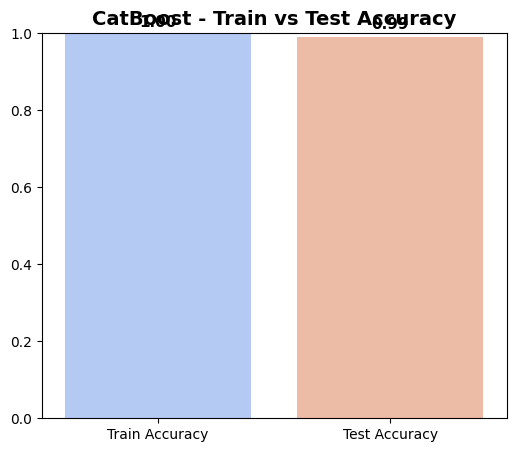

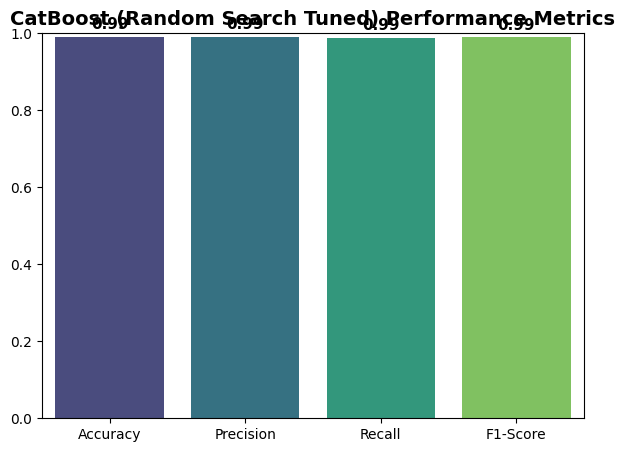

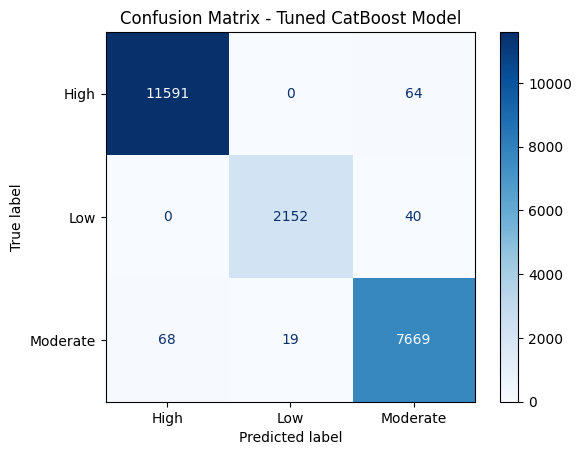

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 4️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ Base CatBoost Model ---
cat_model = CatBoostClassifier(
    objective='MultiClass',
    random_seed=42,
    verbose=False
)

# --- 7️⃣ Define Random Search Parameter Grid ---
param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'iterations': [200, 300, 400, 500],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0.5, 0.8, 1.0]
}

# --- 8️⃣ Randomized Search (Faster than GridSearch) ---
random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=20,                # try 20 random combinations
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

# --- 9️⃣ Best Model ---
best_model = random_search.best_estimator_
print("\n✅ Best Hyperparameters Found:")
print(random_search.best_params_)

# --- 🔟 Evaluate Train & Test Accuracy ---
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 11️⃣ Classification Metrics ---
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print("\n📊 CatBoost (Random Search Tuned) Metrics:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 12️⃣ Visualization: Train vs Test Accuracy ---
plt.figure(figsize=(6,5))
sns.barplot(x=["Train Accuracy", "Test Accuracy"], y=[train_acc, test_acc], palette="coolwarm")
plt.title("CatBoost - Train vs Test Accuracy", fontsize=14, weight="bold")
plt.ylim(0, 1)
for i, v in enumerate([train_acc, test_acc]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 13️⃣ Performance Metrics Visualization ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title("CatBoost (Random Search Tuned) Performance Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 14️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Tuned CatBoost Model")
plt.show()


SVM model

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}

📈 Accuracy Results:
Training Accuracy  : 0.994
Testing Accuracy   : 0.994

📊 SVM Model Metrics:
Accuracy  : 0.994
Precision : 0.994
Recall    : 0.991
F1 Score  : 0.993


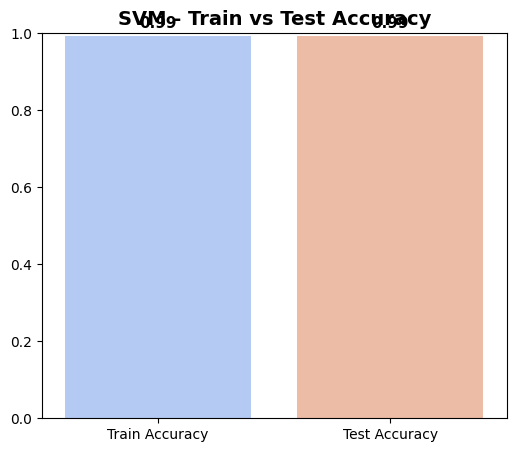

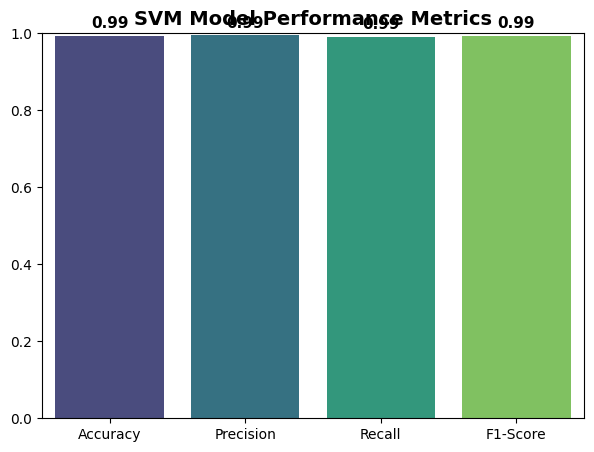

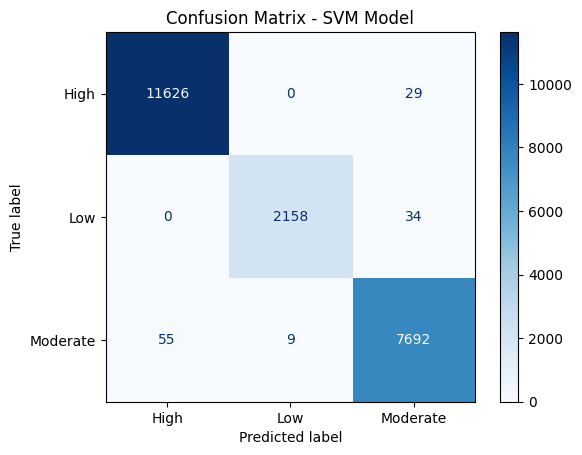

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"   # Change path if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
# Example output: {'High': 0, 'Low': 1, 'Moderate': 2}

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 4️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ Initialize and Train SVM Model ---
svm_model = SVC(
    kernel='rbf',          # radial basis function kernel (best for non-linear data)
    C=1.0,                 # regularization parameter
    gamma='scale',         # kernel coefficient
    probability=True,      # enable probabilities if needed later
    random_state=42
)
svm_model.fit(X_train_scaled, y_train)

# --- 7️⃣ Model Predictions ---
y_train_pred = svm_model.predict(X_train_scaled)
y_test_pred = svm_model.predict(X_test_scaled)

# --- 8️⃣ Evaluate Performance ---
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print("\n📈 Accuracy Results:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

print("\n📊 SVM Model Metrics:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 9️⃣ Visualization: Train vs Test Accuracy ---
plt.figure(figsize=(6,5))
sns.barplot(x=["Train Accuracy", "Test Accuracy"], y=[train_acc, test_acc], palette="coolwarm")
plt.title("SVM - Train vs Test Accuracy", fontsize=14, weight="bold")
plt.ylim(0, 1)
for i, v in enumerate([train_acc, test_acc]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 🔟 Visualization: Performance Metrics ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title("SVM Model Performance Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 11️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - SVM Model")
plt.show()


Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ Best Hyperparameters Found:
{'C': np.float64(8.424426408004217), 'gamma': 'auto', 'kernel': 'rbf'}

📈 Accuracy Comparison:
Training Accuracy  : 0.997
Testing Accuracy   : 0.997

📊 SVM (Optimized) Test Metrics:
Accuracy  : 0.997
Precision : 0.997
Recall    : 0.996
F1 Score  : 0.997


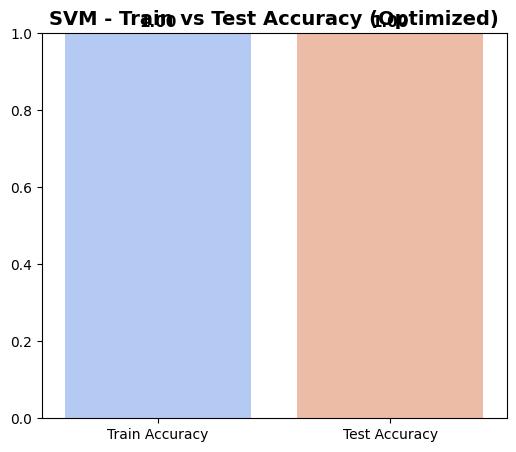

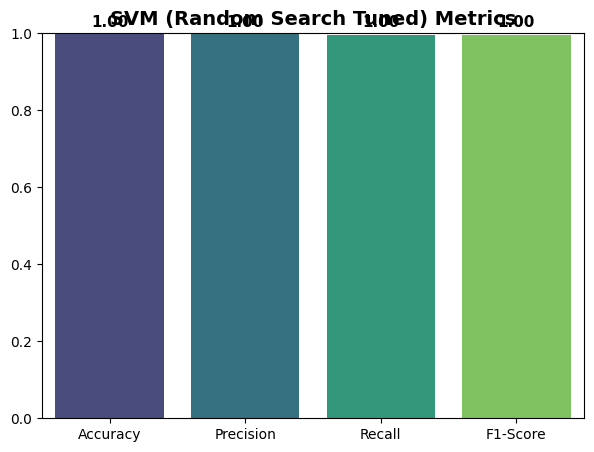

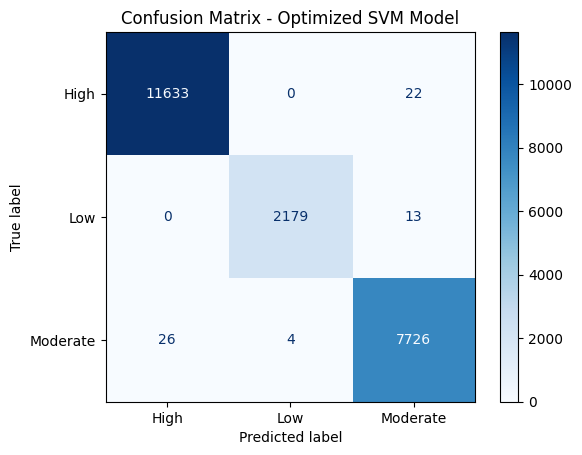

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from scipy.stats import uniform

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 4️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ Base SVM Model ---
svm = SVC(probability=True, random_state=42)

# --- 7️⃣ Define Smaller, Faster Hyperparameter Search Space ---
param_dist = {
    'C': uniform(0.1, 10),          # continuous random values
    'kernel': ['linear', 'rbf'],    # only main kernels
    'gamma': ['scale', 'auto']
}

# --- 8️⃣ Faster Randomized Search ---
random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    n_iter=10,             # test only 10 combinations (fast)
    scoring='accuracy',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train_scaled, y_train)

# --- 9️⃣ Best Model ---
best_model = random_search.best_estimator_
print("\n✅ Best Hyperparameters Found:")
print(random_search.best_params_)

# --- 🔟 Evaluate Train (Validation) & Test Accuracy ---
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 11️⃣ Classification Metrics ---
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print("\n📊 SVM (Optimized) Test Metrics:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 12️⃣ Visualization: Train vs Test Accuracy ---
plt.figure(figsize=(6,5))
sns.barplot(x=["Train Accuracy", "Test Accuracy"], y=[train_acc, test_acc], palette="coolwarm")
plt.title("SVM - Train vs Test Accuracy (Optimized)", fontsize=14, weight="bold")
plt.ylim(0, 1)
for i, v in enumerate([train_acc, test_acc]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 13️⃣ Visualization: Performance Metrics ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title("SVM (Random Search Tuned) Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 14️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Optimized SVM Model")
plt.show()


ANN model

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
Epoch 1/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8395 - loss: 0.3999 - val_accuracy: 0.9766 - val_loss: 0.0676
Epoch 2/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9697 - loss: 0.0763 - val_accuracy: 0.9904 - val_loss: 0.0370
Epoch 3/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9818 - loss: 0.0469 - val_accuracy: 0.9894 - val_loss: 0.0305
Epoch 4/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9848 - loss: 0.0379 - val_accuracy: 0.9889 - val_loss: 0.0264
Epoch 5/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9880 - loss: 0.0304 - val_accuracy: 0.9907 - val_loss: 0.0224
Epoch 6/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9886 - loss: 0.0283 - val_accuracy: 0.9927 - val_loss: 0.0182
Epoch 7/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9889 - loss: 0.0273 - val_accuracy: 0.9911 - val_loss: 0.0217
Epoch 8/

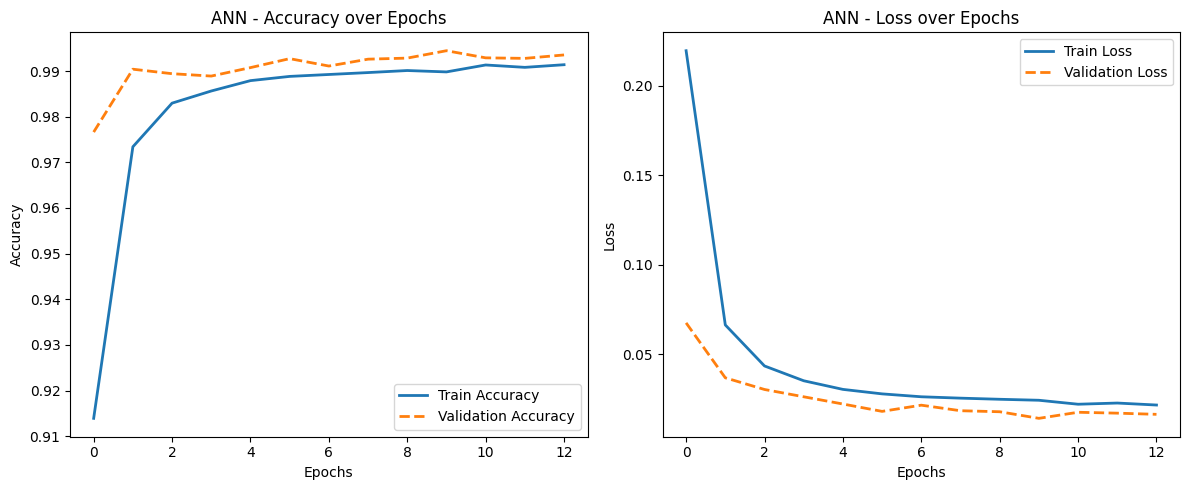

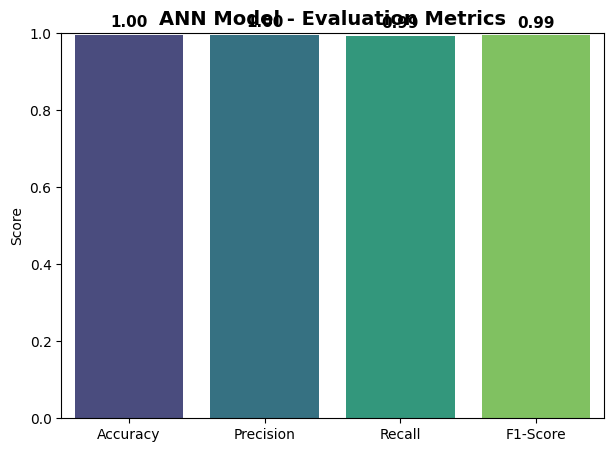

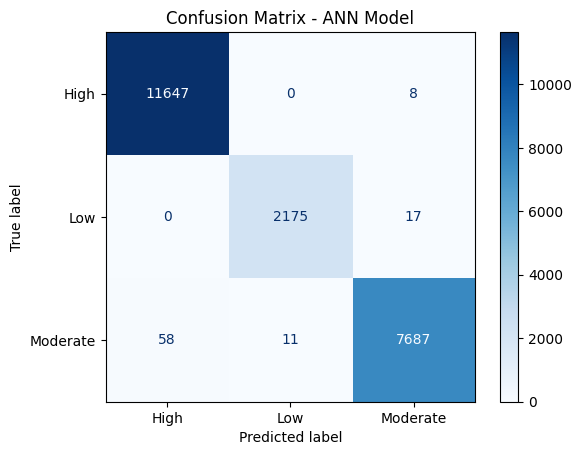

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 4️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 7️⃣ Define ANN Model ---
model = Sequential([
    Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# --- 8️⃣ Compile Model ---
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- 9️⃣ Early Stopping ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# --- 🔟 Train Model ---
history = model.fit(
    X_train_scaled, y_train_encoded,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 11️⃣ Evaluate ---
train_loss, train_acc = model.evaluate(X_train_scaled, y_train_encoded, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 12️⃣ Predictions & Metrics ---
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 ANN (Optimized) Metrics:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 13️⃣ Visualization: Accuracy & Loss Curves ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', linewidth=2)
plt.title("ANN - Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', linewidth=2)
plt.title("ANN - Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- 14️⃣ Visualization: Classification Metrics (Bar Graph) ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title("ANN Model - Evaluation Metrics", fontsize=14, weight="bold")
plt.ylabel("Score")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 15️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - ANN Model")
plt.show()


In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.3 MB/s eta 0:00:00


Trial 3 Complete [00h 01m 22s]
val_accuracy: 0.9953709244728088

Best val_accuracy So Far: 0.9953709244728088
Total elapsed time: 00h 04m 05s

✅ Best Hyperparameters Found:
{'units_layer1': 64, 'dropout_layer1': 0.30000000000000004, 'units_layer2': 32, 'dropout_layer2': 0.1, 'learning_rate': 0.0005}
Epoch 1/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8326 - loss: 0.4160 - val_accuracy: 0.9742 - val_loss: 0.0810
Epoch 2/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9544 - loss: 0.1098 - val_accuracy: 0.9832 - val_loss: 0.0512
Epoch 3/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9709 - loss: 0.0697 - val_accuracy: 0.9873 - val_loss: 0.0378
Epoch 4/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9783 - loss: 0.0526 - val_accuracy: 0.9885 - val_loss: 0.0333
Epoch 5/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9803 - loss: 0.0462 - val_accuracy: 0.9925 - val_loss: 0.0241
Epoch 6/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms

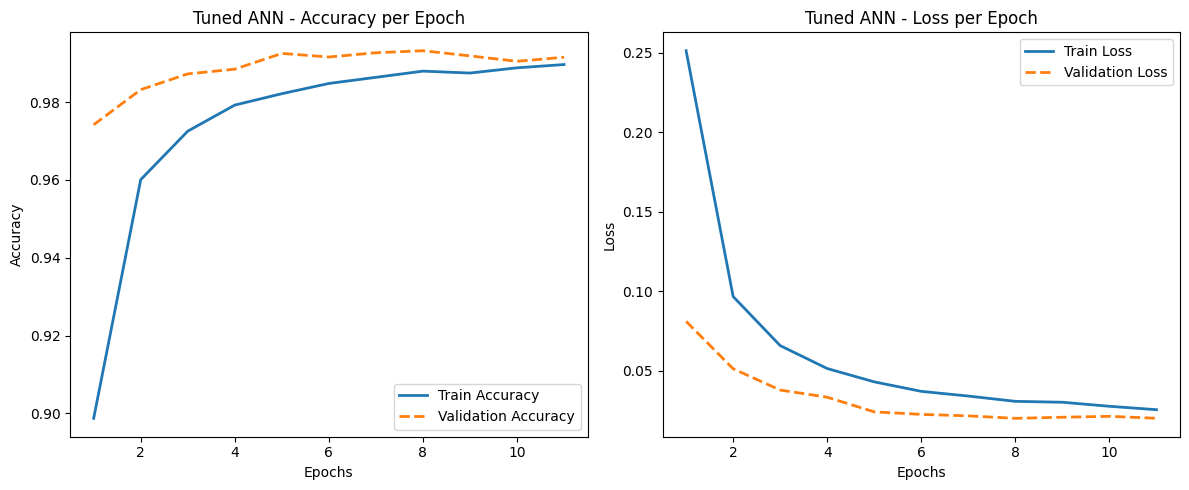

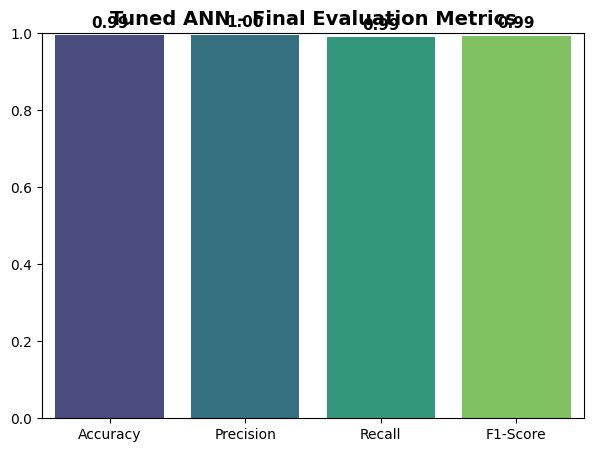

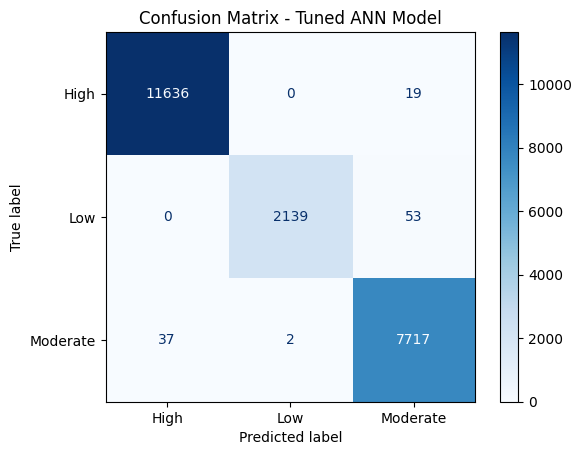

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 4️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 7️⃣ Define Model Builder Function ---
def build_model(hp):
    model = Sequential()

    # Hidden Layer 1
    model.add(Dense(
        units=hp.Int('units_layer1', min_value=32, max_value=128, step=32),
        activation='relu',
        input_dim=X_train_scaled.shape[1]
    ))
    model.add(Dropout(hp.Float('dropout_layer1', 0.1, 0.4, step=0.1)))

    # Hidden Layer 2
    model.add(Dense(
        units=hp.Int('units_layer2', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_layer2', 0.1, 0.4, step=0.1)))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.005])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- 8️⃣ Keras Tuner Setup (Optimized for Speed) ---
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,           # only 3 hyperparameter combinations
    executions_per_trial=1,
    directory='ann_tuner_dir',
    project_name='ann_tuning',
    overwrite=True
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# --- 9️⃣ Perform Hyperparameter Search ---
print("\n🔍 Starting Hyperparameter Search...")
tuner.search(
    X_train_scaled, y_train_encoded,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- 🔟 Get Best Hyperparameters ---
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n✅ Best Hyperparameters Found:")
print(best_hp.values)

# --- 11️⃣ Train Final Model with Best Hyperparameters ---
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train_scaled, y_train_encoded,
    epochs=30,                # limited, manageable
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 12️⃣ Evaluate Final Model ---
train_loss, train_acc = best_model.evaluate(X_train_scaled, y_train_encoded, verbose=0)
test_loss, test_acc = best_model.evaluate(X_test_scaled, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 13️⃣ Predictions & Metrics ---
y_pred_probs = best_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 Tuned ANN Model Performance:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 14️⃣ Plot Accuracy & Loss per Epoch ---
epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', linewidth=2)
plt.title("Tuned ANN - Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', linestyle='--', linewidth=2)
plt.title("Tuned ANN - Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- 15️⃣ Evaluation Metrics Bar Plot ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title("Tuned ANN - Final Evaluation Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 16️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Tuned ANN Model")
plt.show()


CNN model

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
Epoch 1/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8648 - loss: 0.3305 - val_accuracy: 0.9488 - val_loss: 0.1219
Epoch 2/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9352 - loss: 0.1521 - val_accuracy: 0.9688 - val_loss: 0.0884
Epoch 3/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9474 - loss: 0.1274 - val_accuracy: 0.9693 - val_loss: 0.0779
Epoch 4/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9501 - loss: 0.1183 - val_accuracy: 0.9725 - val_loss: 0.0731
Epoch 5/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9555 - loss: 0.1078 - val_accuracy: 0.9754 - val_loss: 0.0684
Epoch 6/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9569 - loss: 0.1026 - val_accuracy: 0.9733 - val_loss: 0.0707
Epoch 7/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9570 - loss: 0.1035 - val_accuracy: 0.9774 - val_loss: 0.0636
Epoch 8

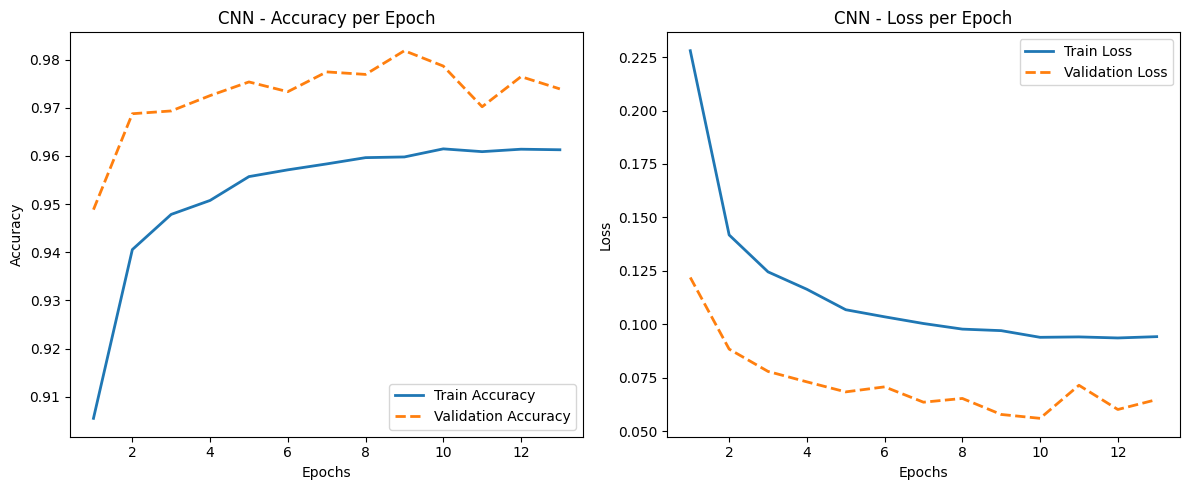

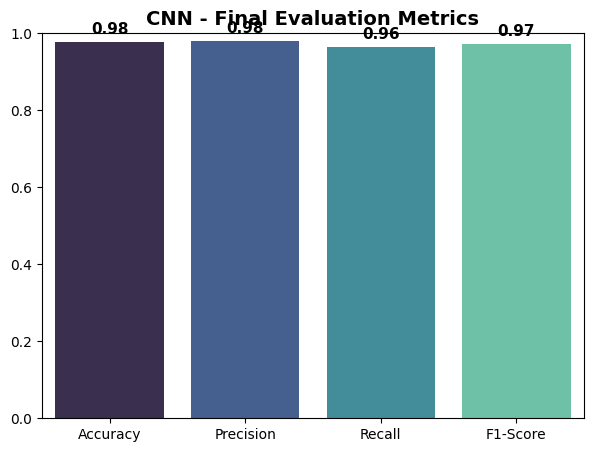

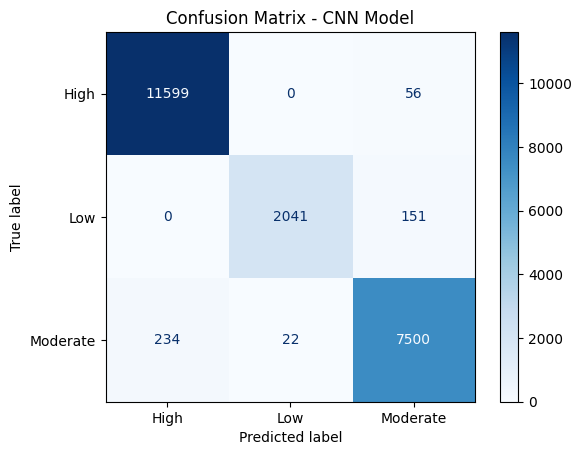

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
# Example: {'High': 0, 'Low': 1, 'Moderate': 2}

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Heat_Stress_Label"].values

# --- 4️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ Reshape for CNN Input ---
# CNN expects 3D input: (samples, timesteps, features)
# We treat each feature vector as a "sequence" of length = number of features
X_train_cnn = np.expand_dims(X_train_scaled, axis=2)
X_test_cnn = np.expand_dims(X_test_scaled, axis=2)

# --- 7️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 8️⃣ Define CNN Model ---
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(filters=32, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# --- 9️⃣ Compile Model ---
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- 🔟 Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- 11️⃣ Train Model ---
history = model.fit(
    X_train_cnn, y_train_encoded,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 12️⃣ Evaluate Model ---
train_loss, train_acc = model.evaluate(X_train_cnn, y_train_encoded, verbose=0)
test_loss, test_acc = model.evaluate(X_test_cnn, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 13️⃣ Predictions & Metrics ---
y_pred_probs = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 CNN Model Performance:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 14️⃣ Plot Accuracy & Loss Curves ---
epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', linewidth=2)
plt.title("CNN - Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', linestyle='--', linewidth=2)
plt.title("CNN - Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- 15️⃣ Visualization: Evaluation Metrics ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="mako")
plt.ylim(0, 1)
plt.title("CNN - Final Evaluation Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 16️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - CNN Model")
plt.show()


Trial 5 Complete [00h 02m 28s]
val_accuracy: 0.9881958365440369

Best val_accuracy So Far: 0.9881958365440369
Total elapsed time: 00h 08m 59s

✅ Best Hyperparameters Found:
{'filters': 96, 'kernel_size': 3, 'dropout_conv': 0.4, 'units_dense': 48, 'dropout_dense': 0.30000000000000004, 'learning_rate': 0.001}
Epoch 1/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8629 - loss: 0.3327 - val_accuracy: 0.9391 - val_loss: 0.1384
Epoch 2/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9370 - loss: 0.1523 - val_accuracy: 0.9649 - val_loss: 0.0942
Epoch 3/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9477 - loss: 0.1272 - val_accuracy: 0.9712 - val_loss: 0.0755
Epoch 4/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9553 - loss: 0.1110 - val_accuracy: 0.9716 - val_loss: 0.0701
Epoch 5/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9576 - loss: 0.1018 - val_accuracy: 0.9747 - val_loss: 0.0660
Epoch 6/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━

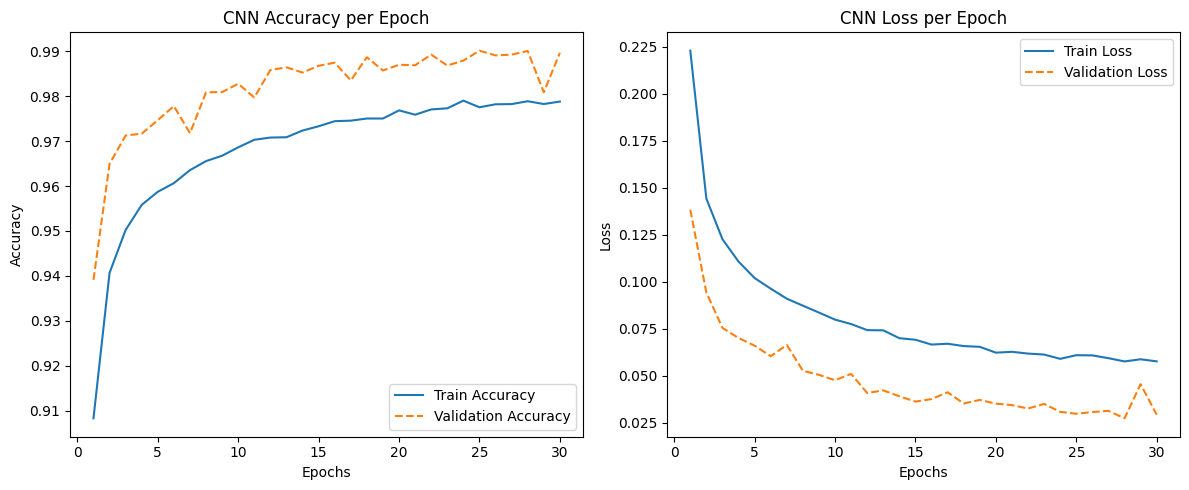

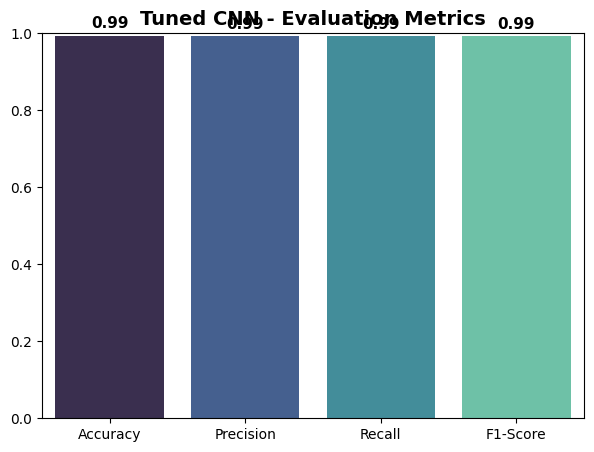

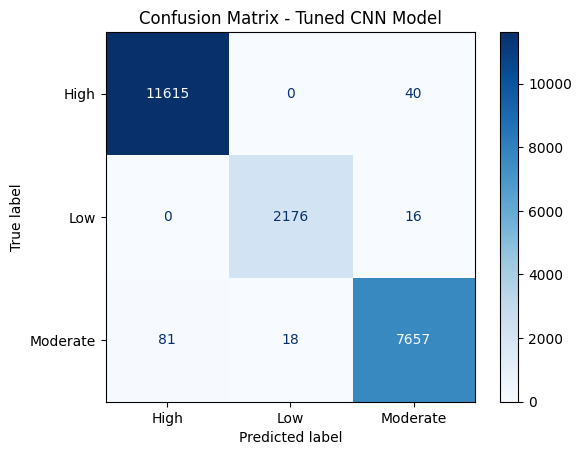

In [ ]:
# =====================================
#  CNN Model with Hyperparameter Tuning (KerasTuner)
# =====================================

# --- 0️⃣ Install Required Library ---
!pip install keras-tuner --quiet

# --- 1️⃣ Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

warnings.filterwarnings("ignore")

# --- 2️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # change if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 3️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 4️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Heat_Stress_Label"].values

# --- 5️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 6️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7️⃣ Reshape for CNN Input (samples, timesteps, features) ---
X_train_cnn = np.expand_dims(X_train_scaled, axis=2)
X_test_cnn = np.expand_dims(X_test_scaled, axis=2)

# --- 8️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 9️⃣ Define Model Builder for CNN ---
def build_cnn(hp):
    model = Sequential()

    # Conv1D Layer
    model.add(Conv1D(
        filters=hp.Int('filters', min_value=16, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size', [2, 3]),
        activation='relu',
        input_shape=(X_train_cnn.shape[1], 1)
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(hp.Float('dropout_conv', 0.1, 0.5, step=0.1)))

    # Dense layers
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('units_dense', min_value=16, max_value=128, step=16),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_dense', 0.1, 0.5, step=0.1)))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.005])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- 🔟 Hyperparameter Tuning ---
tuner = kt.RandomSearch(
    build_cnn,
    objective='val_accuracy',
    max_trials=5,               # Try 5 combinations
    executions_per_trial=1,
    directory='cnn_tuner_dir',
    project_name='cnn_tuning',
    overwrite=True
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\n🔍 Starting Hyperparameter Search...")
tuner.search(X_train_cnn, y_train_encoded, epochs=20, validation_split=0.2, callbacks=[early_stop], verbose=1)

# --- 1️⃣1️⃣ Best Hyperparameters ---
best_hp = tuner.get_best_hyperparameters(1)[0]
print("\n✅ Best Hyperparameters Found:")
print(best_hp.values)

# --- 1️⃣2️⃣ Train Final Model ---
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train_cnn, y_train_encoded,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 1️⃣3️⃣ Evaluate Model ---
train_loss, train_acc = best_model.evaluate(X_train_cnn, y_train_encoded, verbose=0)
test_loss, test_acc = best_model.evaluate(X_test_cnn, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 1️⃣4️⃣ Predictions ---
y_pred_probs = best_model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 Tuned CNN Model Performance:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 1️⃣5️⃣ Plot Accuracy & Loss ---
epochs_range = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], '--', label='Validation Accuracy')
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.title("CNN Accuracy per Epoch"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], '--', label='Validation Loss')
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title("CNN Loss per Epoch"); plt.legend()
plt.tight_layout(); plt.show()

# --- 1️⃣6️⃣ Metrics Bar Chart ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]
plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="mako")
plt.ylim(0, 1)
plt.title("Tuned CNN - Evaluation Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 1️⃣7️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Tuned CNN Model")
plt.show()


LSTM model

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
Epoch 1/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8846 - loss: 0.3159 - val_accuracy: 0.9884 - val_loss: 0.0378
Epoch 2/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9805 - loss: 0.0485 - val_accuracy: 0.9936 - val_loss: 0.0235
Epoch 3/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9859 - loss: 0.0354 - val_accuracy: 0.9903 - val_loss: 0.0238
Epoch 4/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9881 - loss: 0.0296 - val_accuracy: 0.9900 - val_loss: 0.0231
Epoch 5/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9892 - loss: 0.0270 - val_accuracy: 0.9921 - val_loss: 0.0189
Epoch 6/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9890 - loss: 0.0269 - val_accuracy: 0.9911 - val_loss: 0.0190
Epoch 7/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9892 - loss: 0.0266 - val_accuracy: 0.9926 - val_loss: 0.0196
Epoch 

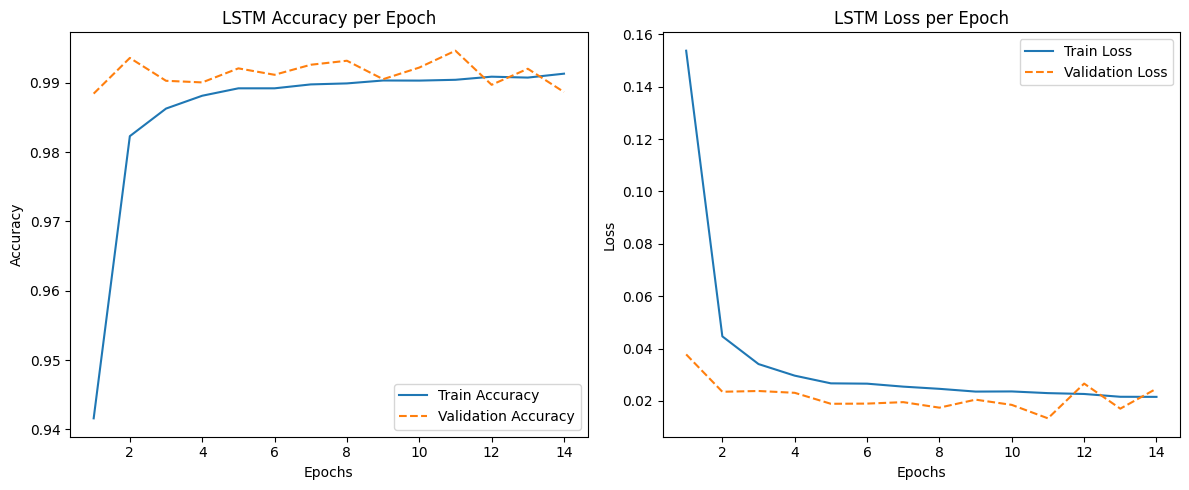

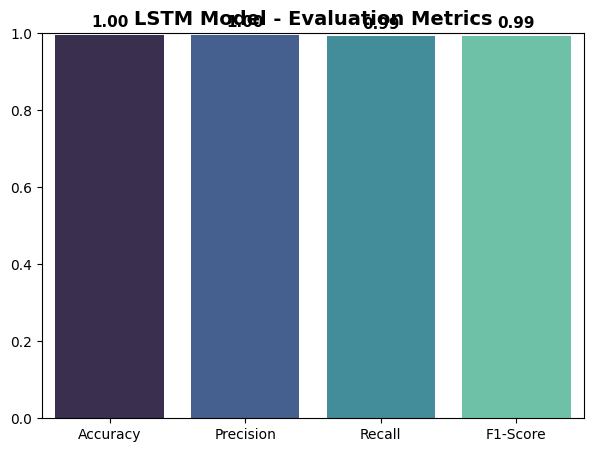

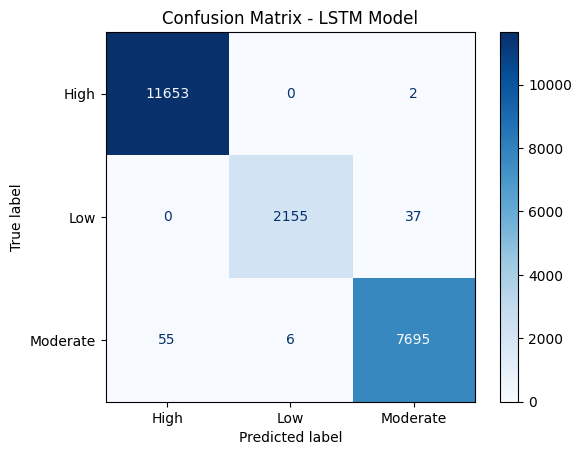

In [ ]:
# ============================================
# LSTM Model Implementation (Deep Learning)
# ============================================

# --- 1️⃣ Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

# --- 2️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # Change path if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 3️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 4️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Heat_Stress_Label"].values

# --- 5️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7️⃣ Reshape Data for LSTM (samples, timesteps, features) ---
# LSTM expects 3D input → (samples, timesteps, features)
X_train_lstm = np.expand_dims(X_train_scaled, axis=1)
X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

# --- 8️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 9️⃣ Define LSTM Model ---
model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# --- 🔟 Compile Model ---
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- 11️⃣ Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- 12️⃣ Train Model ---
history = model.fit(
    X_train_lstm, y_train_encoded,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 13️⃣ Evaluate Model ---
train_loss, train_acc = model.evaluate(X_train_lstm, y_train_encoded, verbose=0)
test_loss, test_acc = model.evaluate(X_test_lstm, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 14️⃣ Predictions ---
y_pred_probs = model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 LSTM Model Performance:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 15️⃣ Plot Accuracy & Loss ---
epochs_range = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], '--', label='Validation Accuracy')
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.title("LSTM Accuracy per Epoch"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], '--', label='Validation Loss')
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title("LSTM Loss per Epoch"); plt.legend()
plt.tight_layout(); plt.show()

# --- 16️⃣ Metrics Bar Chart ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]
plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="mako")
plt.ylim(0, 1)
plt.title("LSTM Model - Evaluation Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 17️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - LSTM Model")
plt.show()


Trial 5 Complete [00h 01m 36s]
val_accuracy: 0.9957180619239807

Best val_accuracy So Far: 0.9957180619239807
Total elapsed time: 00h 07m 15s

✅ Best Hyperparameters Found:
{'lstm_units': 128, 'dropout_rate': 0.5, 'dense_units': 48, 'learning_rate': 0.001}
Epoch 1/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9080 - loss: 0.2554 - val_accuracy: 0.9825 - val_loss: 0.0436
Epoch 2/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9806 - loss: 0.0453 - val_accuracy: 0.9864 - val_loss: 0.0310
Epoch 3/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9827 - loss: 0.0388 - val_accuracy: 0.9878 - val_loss: 0.0271
Epoch 4/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9856 - loss: 0.0345 - val_accuracy: 0.9920 - val_loss: 0.0216
Epoch 5/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9861 - loss: 0.0327 - val_accuracy: 0.9895 - val_loss: 0.0228
Epoch 6/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9879 - loss: 0.0294 

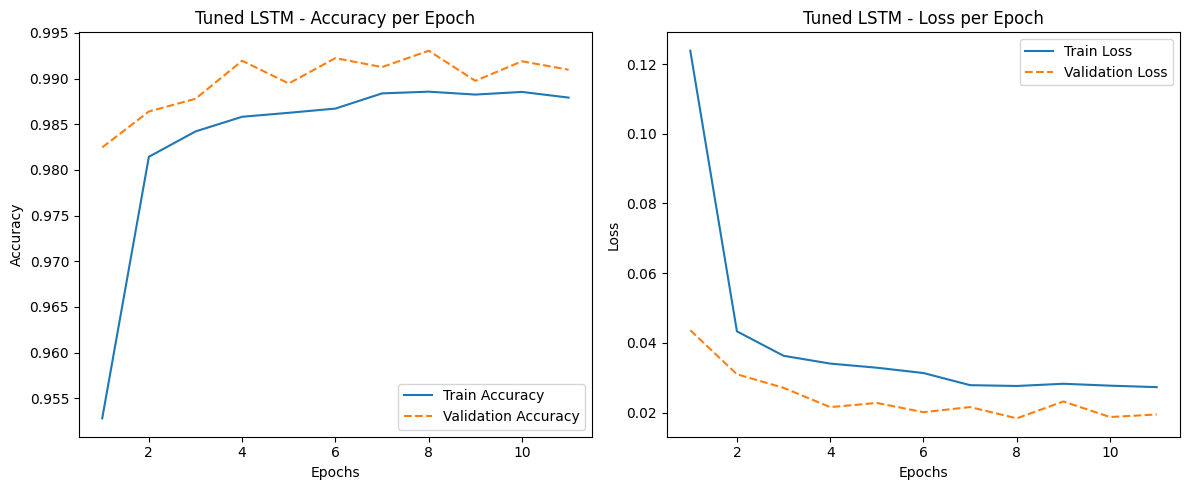

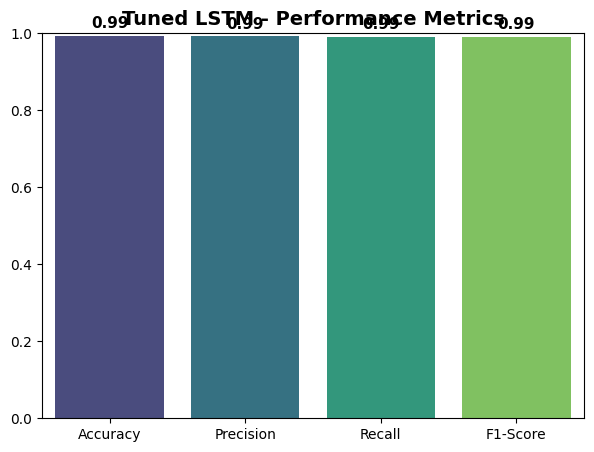

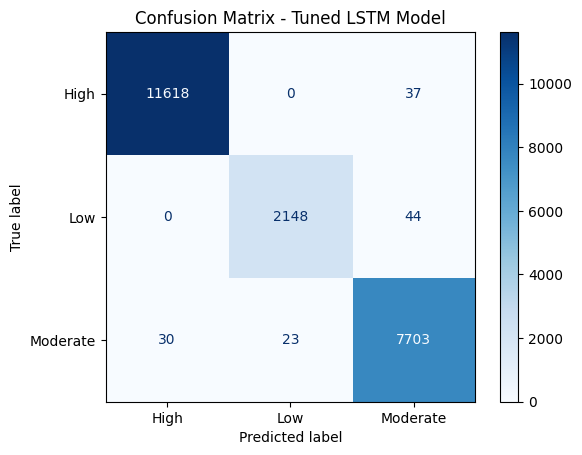

In [ ]:
# ============================================
# 🧠 LSTM Model with Hyperparameter Tuning
# ============================================

# --- 1️⃣ Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

warnings.filterwarnings("ignore")

# --- 2️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # Change if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 3️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 4️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Heat_Stress_Label"].values

# --- 5️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7️⃣ Reshape Data for LSTM (samples, timesteps, features) ---
X_train_lstm = np.expand_dims(X_train_scaled, axis=1)
X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

# --- 8️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 9️⃣ Define Model Builder Function ---
def build_model(hp):
    model = Sequential()

    # LSTM Layer
    model.add(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
        input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
        return_sequences=False
    ))

    # Dropout Layer
    model.add(Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))

    # Dense Layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))

    model.add(Dense(num_classes, activation='softmax'))

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.005])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# --- 🔟 Hyperparameter Tuning using KerasTuner ---
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,            # try 5 combinations
    executions_per_trial=1,
    directory='lstm_tuner_dir',
    project_name='lstm_tuning',
    overwrite=True
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(
    X_train_lstm, y_train_encoded,
    epochs=25,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- 11️⃣ Get Best Hyperparameters ---
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n✅ Best Hyperparameters Found:")
print(best_hp.values)

# --- 12️⃣ Train Final Model using Best Hyperparameters ---
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train_lstm, y_train_encoded,
    epochs=40,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 13️⃣ Evaluate Model ---
train_loss, train_acc = best_model.evaluate(X_train_lstm, y_train_encoded, verbose=0)
test_loss, test_acc = best_model.evaluate(X_test_lstm, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 14️⃣ Predictions ---
y_pred_probs = best_model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 LSTM (Tuned) Model Performance:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 15️⃣ Plot: Accuracy & Loss Curves ---
epochs_range = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], '--', label='Validation Accuracy')
plt.title("Tuned LSTM - Accuracy per Epoch")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], '--', label='Validation Loss')
plt.title("Tuned LSTM - Loss per Epoch")
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- 16️⃣ Bar Chart for Metrics ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]
plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title("Tuned LSTM - Performance Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 17️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Tuned LSTM Model")
plt.show()


GUR model

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
Epoch 1/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8876 - loss: 0.2883 - val_accuracy: 0.9835 - val_loss: 0.0425
Epoch 2/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9792 - loss: 0.0511 - val_accuracy: 0.9915 - val_loss: 0.0247
Epoch 3/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9836 - loss: 0.0392 - val_accuracy: 0.9906 - val_loss: 0.0231
Epoch 4/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9867 - loss: 0.0323 - val_accuracy: 0.9930 - val_loss: 0.0185
Epoch 5/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9876 - loss: 0.0292 - val_accuracy: 0.9884 - val_loss: 0.0263
Epoch 6/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9879 - loss: 0.0291 - val_accuracy: 0.9884 - val_loss: 0.0241
Epoch 7/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9893 - loss: 0.0264 - val_accuracy: 0.9880 - val_loss: 0.0263

📈 Accu

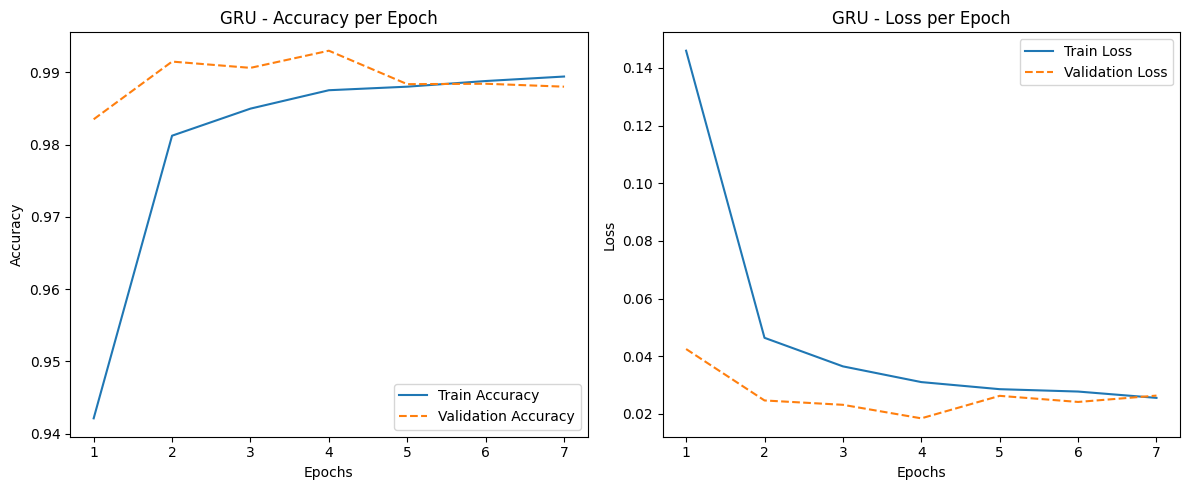

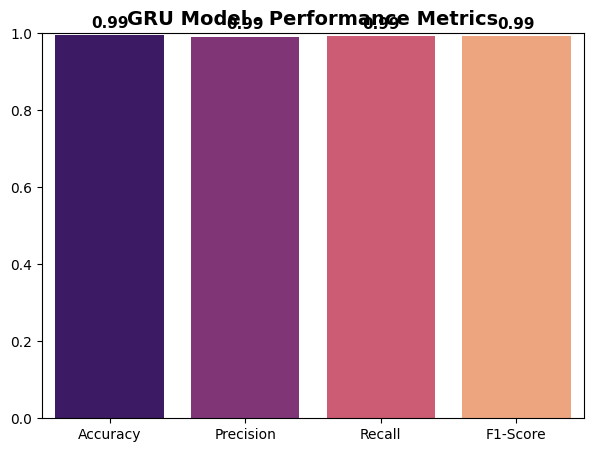

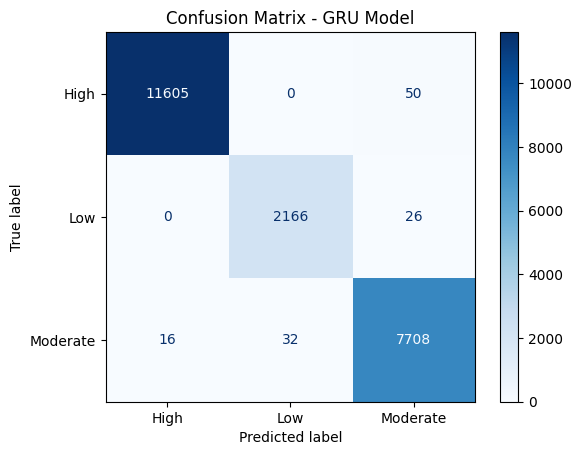

In [ ]:
# ============================================
# 🧠 GRU Model Implementation (Deep Learning)
# ============================================

# --- 1️⃣ Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

# --- 2️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"   # Change path if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 3️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
# Example: {'High': 0, 'Low': 1, 'Moderate': 2}

# --- 4️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Heat_Stress_Label"].values

# --- 5️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7️⃣ Reshape Data for GRU (samples, timesteps, features) ---
X_train_gru = np.expand_dims(X_train_scaled, axis=1)
X_test_gru = np.expand_dims(X_test_scaled, axis=1)

# --- 8️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 9️⃣ Define GRU Model ---
model = Sequential([
    GRU(64, input_shape=(X_train_gru.shape[1], X_train_gru.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# --- 🔟 Compile Model ---
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- 11️⃣ Early Stopping ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# --- 12️⃣ Train Model ---
history = model.fit(
    X_train_gru, y_train_encoded,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 13️⃣ Evaluate Model ---
train_loss, train_acc = model.evaluate(X_train_gru, y_train_encoded, verbose=0)
test_loss, test_acc = model.evaluate(X_test_gru, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 14️⃣ Predictions ---
y_pred_probs = model.predict(X_test_gru)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- 15️⃣ Compute Metrics ---
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 GRU Model Performance:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 16️⃣ Plot: Accuracy & Loss Curves ---
epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title("GRU - Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title("GRU - Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- 17️⃣ Visualization: Metrics Bar Chart ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]
plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="magma")
plt.ylim(0, 1)
plt.title("GRU Model - Performance Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 18️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - GRU Model")
plt.show()


Trial 5 Complete [00h 01m 58s]
val_accuracy: 0.9935192465782166

Best val_accuracy So Far: 0.9956023693084717
Total elapsed time: 00h 07m 44s

✅ Best Hyperparameters Found:
{'gru_units_1': 32, 'dropout_1': 0.30000000000000004, 'dense_units': 48, 'dropout_2': 0.5, 'learning_rate': 0.0005}
Epoch 1/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8010 - loss: 0.4832 - val_accuracy: 0.9866 - val_loss: 0.0657
Epoch 2/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9616 - loss: 0.0980 - val_accuracy: 0.9855 - val_loss: 0.0421
Epoch 3/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9775 - loss: 0.0587 - val_accuracy: 0.9925 - val_loss: 0.0265
Epoch 4/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9827 - loss: 0.0445 - val_accuracy: 0.9917 - val_loss: 0.0224
Epoch 5/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9870 - loss: 0.0360 - val_accuracy: 0.9944 - val_loss: 0.0182
Epoch 6/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accu

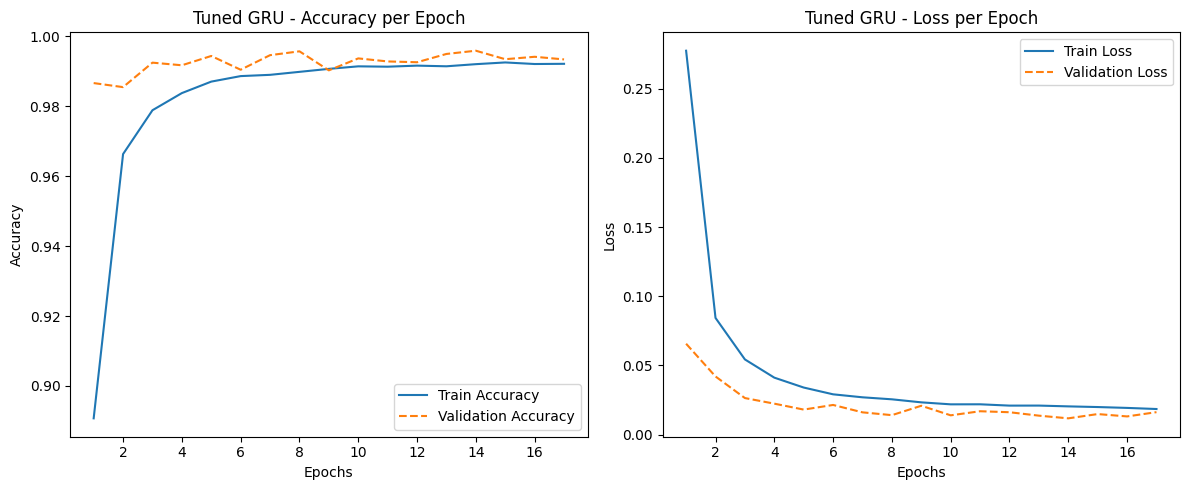

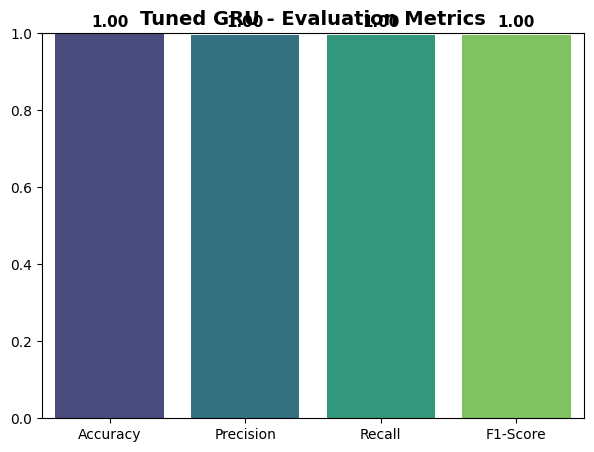

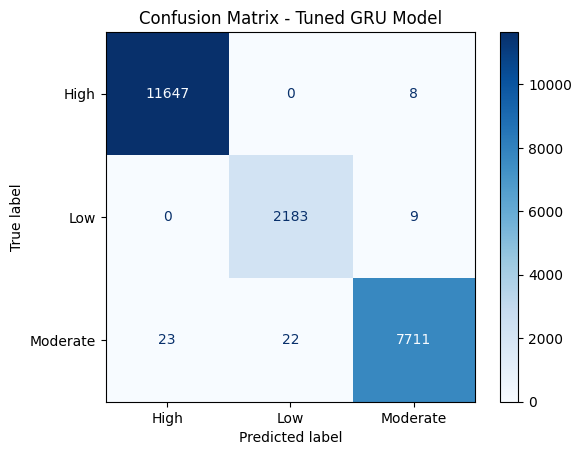

In [ ]:
# ==========================================================
# 🧠 GRU Model with Hyperparameter Tuning using KerasTuner
# ==========================================================

# --- 1️⃣ Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

warnings.filterwarnings("ignore")

# --- 2️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # Change path if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 3️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 4️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Heat_Stress_Label"].values

# --- 5️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7️⃣ Reshape for GRU (samples, timesteps=1, features) ---
X_train_gru = np.expand_dims(X_train_scaled, axis=1)
X_test_gru = np.expand_dims(X_test_scaled, axis=1)

# --- 8️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 9️⃣ Define Model Builder for KerasTuner ---
def build_gru_model(hp):
    model = Sequential()

    # First GRU layer
    model.add(GRU(
        units=hp.Int('gru_units_1', min_value=32, max_value=128, step=32),
        input_shape=(X_train_gru.shape[1], X_train_gru.shape[2]),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))

    # Optional second Dense layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.005])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# --- 🔟 Initialize KerasTuner ---
tuner = kt.RandomSearch(
    build_gru_model,
    objective='val_accuracy',
    max_trials=5,             # You can increase to 10 for better tuning
    executions_per_trial=1,
    directory='gru_tuner_dir',
    project_name='gru_tuning',
    overwrite=True
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- 11️⃣ Perform Hyperparameter Search ---
tuner.search(
    X_train_gru, y_train_encoded,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- 12️⃣ Retrieve Best Hyperparameters ---
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n✅ Best Hyperparameters Found:")
print(best_hp.values)

# --- 13️⃣ Train Final Model with Best Hyperparameters ---
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train_gru, y_train_encoded,
    epochs=40,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 14️⃣ Evaluate Model ---
train_loss, train_acc = best_model.evaluate(X_train_gru, y_train_encoded, verbose=0)
test_loss, test_acc = best_model.evaluate(X_test_gru, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 15️⃣ Predictions ---
y_pred_probs = best_model.predict(X_test_gru)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- 16️⃣ Compute Metrics ---
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 Tuned GRU Model Performance:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 17️⃣ Plot: Accuracy & Loss Curves ---
epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title("Tuned GRU - Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title("Tuned GRU - Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- 18️⃣ Visualization: Evaluation Metrics ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title("Tuned GRU - Evaluation Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 19️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Tuned GRU Model")
plt.show()


BI-LSTM model

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
Epoch 1/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.8972 - loss: 0.2852 - val_accuracy: 0.9807 - val_loss: 0.0432
Epoch 2/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9794 - loss: 0.0509 - val_accuracy: 0.9873 - val_loss: 0.0311
Epoch 3/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9849 - loss: 0.0374 - val_accuracy: 0.9911 - val_loss: 0.0223
Epoch 4/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9873 - loss: 0.0311 - val_accuracy: 0.9921 - val_loss: 0.0192
Epoch 5/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9875 - loss: 0.0296 - val_accuracy: 0.9904 - val_loss: 0.0223
Epoch 6/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9887 - loss: 0.0280 - val_accuracy: 0.9914 - val_loss: 0.0203
Epoch 7/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9898 - loss: 0.0256 - val_accuracy: 0.9936 - val_loss: 0.0184
E

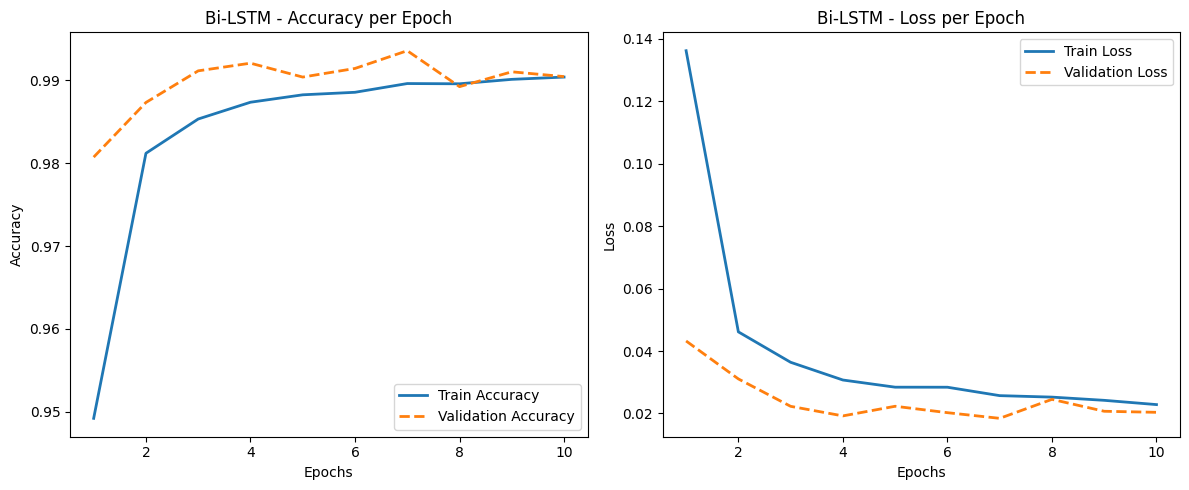

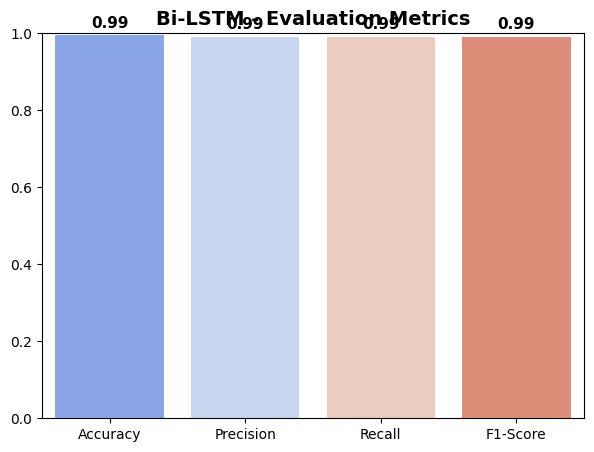

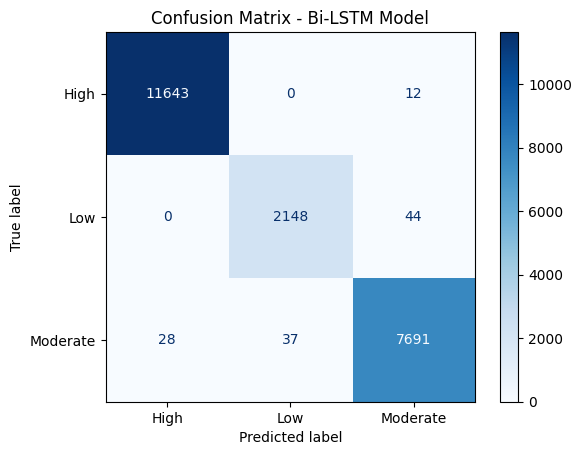

In [ ]:
# ==========================================================
# 🧠 Bidirectional LSTM Model for Heat Stress Classification
# ==========================================================

# --- 1️⃣ Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

# --- 2️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # Update path if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 3️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 4️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Heat_Stress_Label"].values

# --- 5️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7️⃣ Reshape for LSTM (samples, timesteps, features) ---
X_train_lstm = np.expand_dims(X_train_scaled, axis=1)
X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

# --- 8️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 9️⃣ Define Bi-LSTM Model ---
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# --- 🔟 Compile Model ---
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- 11️⃣ Train Model with Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train_encoded,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 12️⃣ Evaluate Model ---
train_loss, train_acc = model.evaluate(X_train_lstm, y_train_encoded, verbose=0)
test_loss, test_acc = model.evaluate(X_test_lstm, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 13️⃣ Predictions ---
y_pred_probs = model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- 14️⃣ Compute Evaluation Metrics ---
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 Bi-LSTM Model Performance:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 15️⃣ Plot: Accuracy & Loss Curves ---
epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', linewidth=2)
plt.title("Bi-LSTM - Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', linestyle='--', linewidth=2)
plt.title("Bi-LSTM - Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- 16️⃣ Visualization: Evaluation Metrics ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.ylim(0, 1)
plt.title("Bi-LSTM - Evaluation Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 17️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Bi-LSTM Model")
plt.show()


In [ ]:
!pip install keras-tuner -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.3 MB/s eta 0:00:00


Trial 5 Complete [00h 04m 47s]
val_accuracy: 0.9935192465782166

Best val_accuracy So Far: 0.9960652589797974
Total elapsed time: 00h 17m 07s

✅ Best Hyperparameters Found:
{'lstm_units': 96, 'dropout_rate': 0.5, 'dense_units': 64, 'learning_rate': 0.0005}
Epoch 1/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.8828 - loss: 0.3272 - val_accuracy: 0.9811 - val_loss: 0.0541
Epoch 2/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9778 - loss: 0.0551 - val_accuracy: 0.9889 - val_loss: 0.0332
Epoch 3/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9844 - loss: 0.0384 - val_accuracy: 0.9907 - val_loss: 0.0256
Epoch 4/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9867 - loss: 0.0316 - val_accuracy: 0.9917 - val_loss: 0.0226
Epoch 5/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9878 - loss: 0.0279 - val_accuracy: 0.9930 - val_loss: 0.0194
Epoch 6/40
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9887 - loss: 0.0270

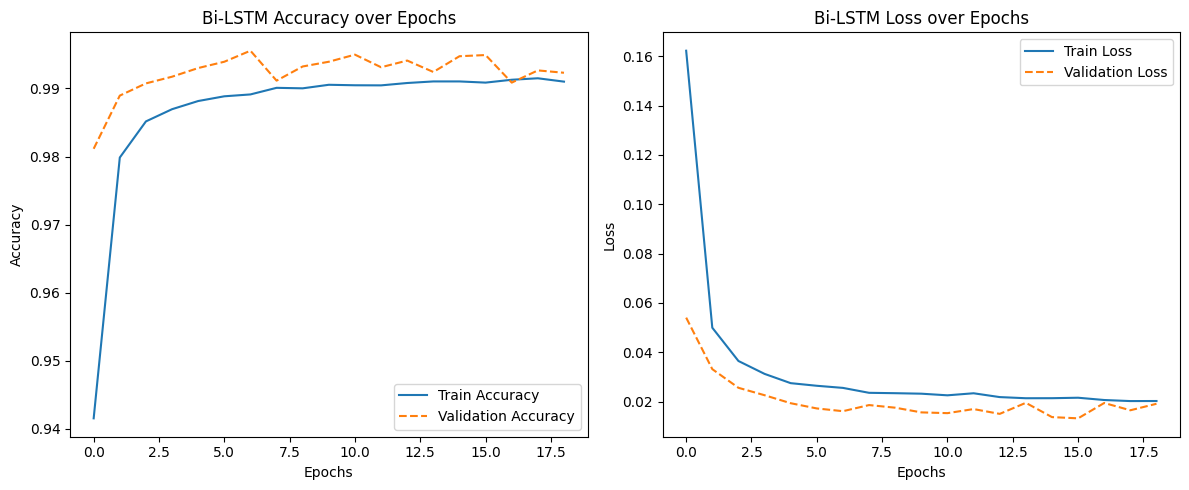

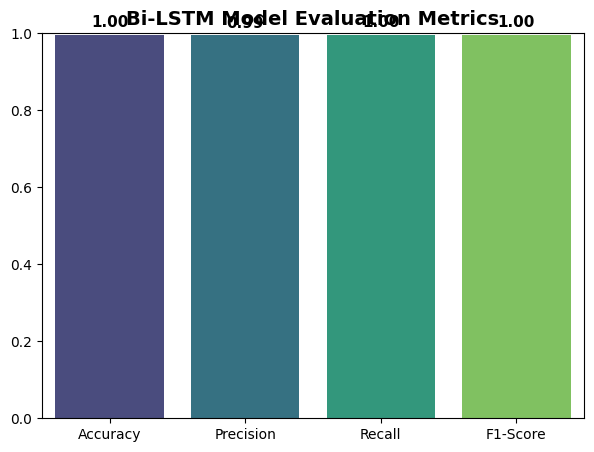

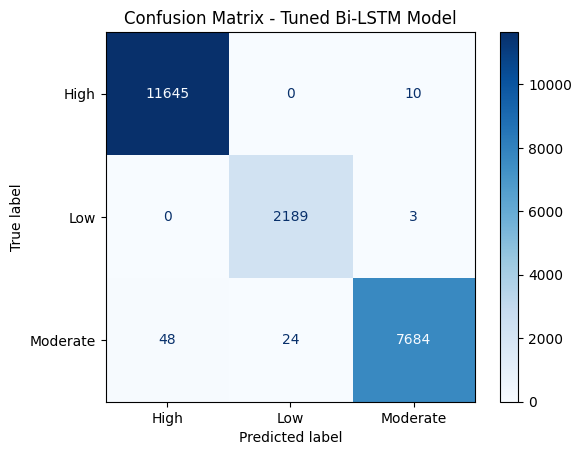

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # Change path if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Heat_Stress_Label"].values

# --- 4️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ Reshape for LSTM Input [samples, timesteps, features] ---
# We'll treat each feature vector as one time step for simplicity
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# --- 7️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 8️⃣ Define Model Builder Function for KerasTuner ---
def build_bilstm_model(hp):
    model = Sequential()
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units', min_value=16, max_value=128, step=16),
        activation='tanh',
        return_sequences=False
    ), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))

    # Dropout Layer
    model.add(Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))

    # Dense Layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=8, max_value=64, step=8),
        activation='relu'
    ))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.005])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- 9️⃣ Keras Tuner Setup ---
tuner = kt.RandomSearch(
    build_bilstm_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='bilstm_tuning',
    project_name='heat_stress_bilstm',
    overwrite=True
)

# --- 🔟 Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- 11️⃣ Perform Hyperparameter Search ---
tuner.search(
    X_train_scaled, y_train_encoded,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- 12️⃣ Retrieve Best Hyperparameters ---
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n✅ Best Hyperparameters Found:")
print(best_hp.values)

# --- 13️⃣ Build and Train Final Model ---
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train_scaled, y_train_encoded,
    epochs=40,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 14️⃣ Evaluate Model ---
train_loss, train_acc = best_model.evaluate(X_train_scaled, y_train_encoded, verbose=0)
test_loss, test_acc = best_model.evaluate(X_test_scaled, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 15️⃣ Predictions & Classification Metrics ---
y_pred_probs = best_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 Bi-LSTM (Tuned) Model Metrics:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 16️⃣ Plot Accuracy & Loss Curves ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title("Bi-LSTM Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title("Bi-LSTM Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- 17️⃣ Metrics Visualization ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title("Bi-LSTM Model Evaluation Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 18️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Tuned Bi-LSTM Model")
plt.show()


MLP model

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
Epoch 1/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8956 - loss: 0.2455 - val_accuracy: 0.9760 - val_loss: 0.0533
Epoch 2/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9746 - loss: 0.0605 - val_accuracy: 0.9843 - val_loss: 0.0368
Epoch 3/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9811 - loss: 0.0453 - val_accuracy: 0.9900 - val_loss: 0.0247
Epoch 4/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9836 - loss: 0.0395 - val_accuracy: 0.9884 - val_loss: 0.0271
Epoch 5/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9837 - loss: 0.0389 - val_accuracy: 0.9885 - val_loss: 0.0271
Epoch 6/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9856 - loss: 0.0338 - val_accuracy: 0.9927 - val_loss: 0.0192
Epoch 7/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9854 - loss: 0.0340 - val_accuracy: 0.9891 - val_loss: 0.0251
Epoch 8

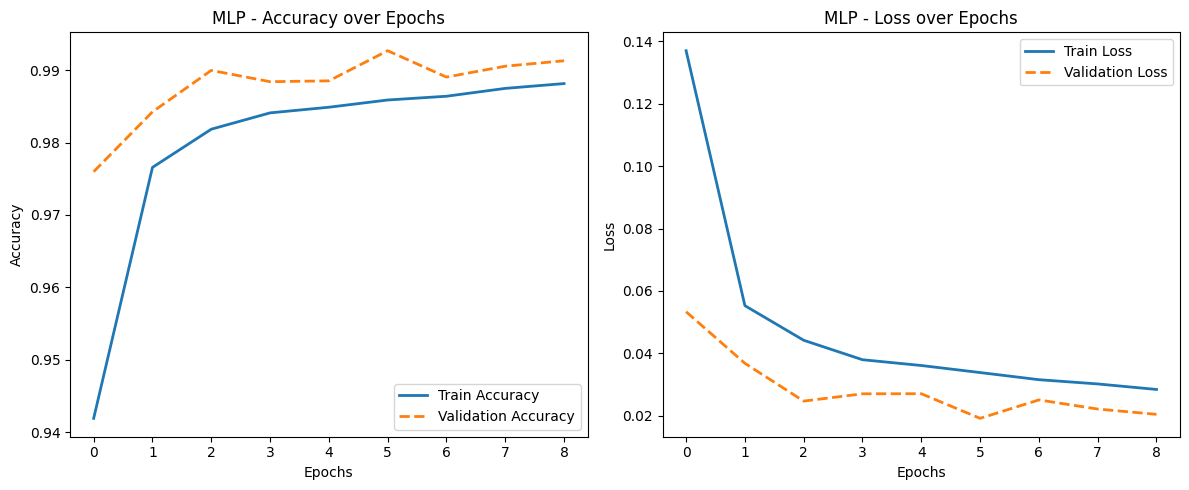

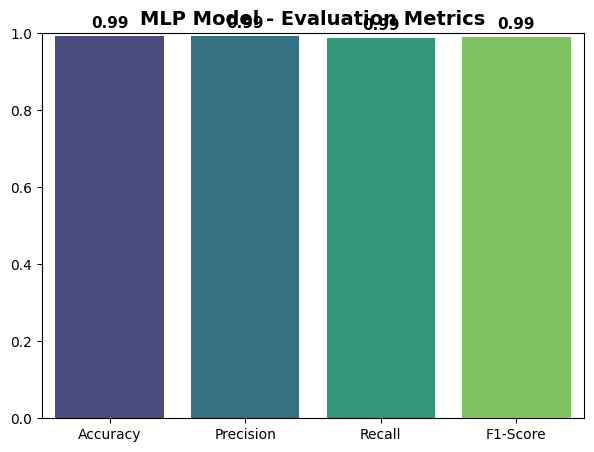

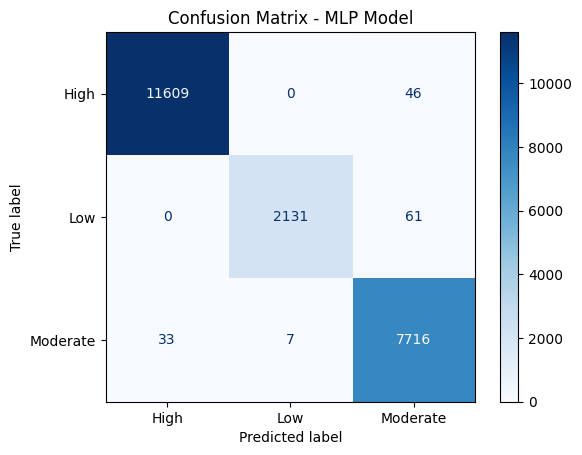

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # Update path if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 4️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 7️⃣ Define the MLP Model ---
model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# --- 8️⃣ Compile the Model ---
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- 9️⃣ Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- 🔟 Train the Model ---
history = model.fit(
    X_train_scaled, y_train_encoded,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 11️⃣ Evaluate the Model ---
train_loss, train_acc = model.evaluate(X_train_scaled, y_train_encoded, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 12️⃣ Predictions & Metrics ---
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 MLP Model Performance:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 13️⃣ Plot: Accuracy & Loss Curves ---
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', linewidth=2)
plt.title("MLP - Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', linewidth=2)
plt.title("MLP - Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- 14️⃣ Visualization: Evaluation Metrics ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title("MLP Model - Evaluation Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 15️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - MLP Model")
plt.show()


Trial 5 Complete [00h 00m 50s]
val_accuracy: 0.9906260967254639

Best val_accuracy So Far: 0.9931721091270447
Total elapsed time: 00h 05m 58s

✅ Best Hyperparameters Found:
{'units_layer1': 224, 'dropout_layer1': 0.4, 'units_layer2': 64, 'dropout_layer2': 0.2, 'units_layer3': 48, 'learning_rate': 0.001}
Epoch 1/50
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9071 - loss: 0.2204 - val_accuracy: 0.9806 - val_loss: 0.0452
Epoch 2/50
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9749 - loss: 0.0591 - val_accuracy: 0.9871 - val_loss: 0.0325
Epoch 3/50
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9799 - loss: 0.0490 - val_accuracy: 0.9884 - val_loss: 0.0277
Epoch 4/50
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9819 - loss: 0.0425 - val_accuracy: 0.9904 - val_loss: 0.0251
Epoch 5/50
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9836 - loss: 0.0395 - val_accuracy: 0.9930 - val_loss: 0.0204
Epoch 6/50
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6

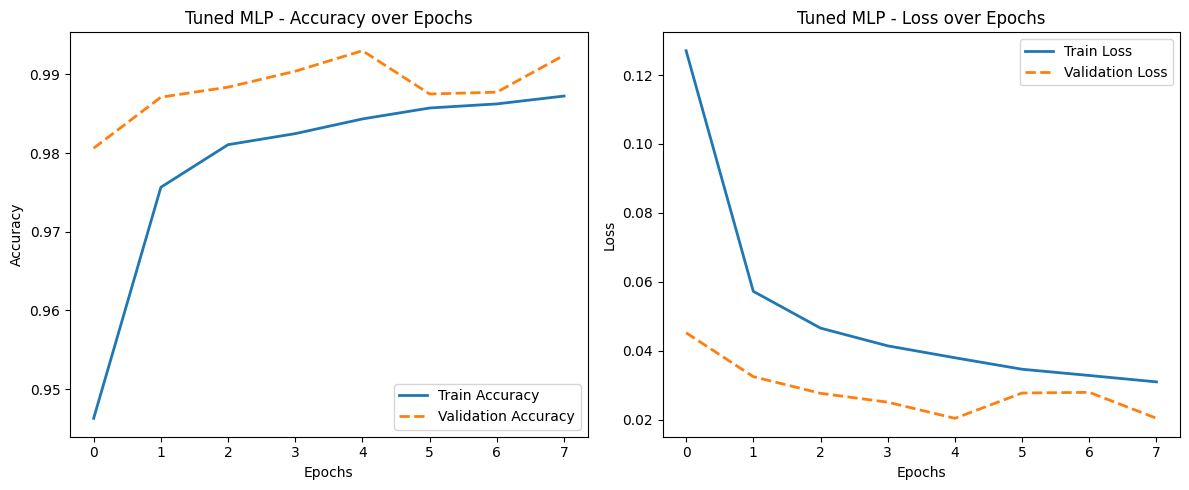

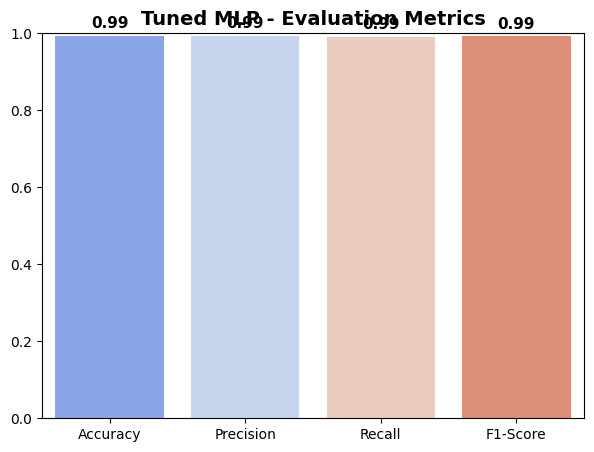

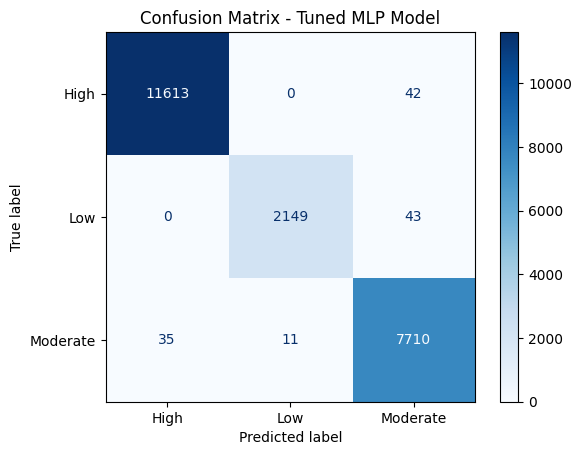

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # Change path if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols]
y = df["Heat_Stress_Label"]

# --- 4️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 7️⃣ Define Model Builder for Hyperparameter Tuning ---
def build_model(hp):
    model = Sequential()

    # Input + Hidden Layer 1
    model.add(Dense(
        units=hp.Int('units_layer1', min_value=32, max_value=256, step=32),
        activation='relu',
        input_dim=X_train_scaled.shape[1]
    ))
    model.add(Dropout(hp.Float('dropout_layer1', 0.1, 0.5, step=0.1)))

    # Hidden Layer 2
    model.add(Dense(
        units=hp.Int('units_layer2', min_value=16, max_value=128, step=16),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_layer2', 0.1, 0.5, step=0.1)))

    # Hidden Layer 3 (optional)
    model.add(Dense(
        units=hp.Int('units_layer3', min_value=8, max_value=64, step=8),
        activation='relu'
    ))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.005])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# --- 8️⃣ Keras Tuner Setup ---
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,             # try 5 different model configurations
    executions_per_trial=1,
    directory='mlp_tuner_dir',
    project_name='mlp_tuning',
    overwrite=True
)

# Early stopping to stop training when no improvement
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- 9️⃣ Run Hyperparameter Search ---
tuner.search(
    X_train_scaled, y_train_encoded,
    epochs=25,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- 🔟 Retrieve Best Hyperparameters ---
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n✅ Best Hyperparameters Found:")
print(best_hp.values)

# --- 11️⃣ Train Final Model with Best Parameters ---
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train_scaled, y_train_encoded,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 12️⃣ Evaluate Model ---
train_loss, train_acc = best_model.evaluate(X_train_scaled, y_train_encoded, verbose=0)
test_loss, test_acc = best_model.evaluate(X_test_scaled, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 13️⃣ Predictions & Metrics ---
y_pred_probs = best_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 Tuned MLP Model Performance:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 14️⃣ Plot: Accuracy & Loss Curves ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', linewidth=2)
plt.title("Tuned MLP - Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', linewidth=2)
plt.title("Tuned MLP - Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- 15️⃣ Visualization: Evaluation Metrics ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.ylim(0, 1)
plt.title("Tuned MLP - Evaluation Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 16️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Tuned MLP Model")
plt.show()


RNN model

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
Epoch 1/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8780 - loss: 0.3095 - val_accuracy: 0.9853 - val_loss: 0.0512
Epoch 2/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9678 - loss: 0.0774 - val_accuracy: 0.9847 - val_loss: 0.0382
Epoch 3/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9776 - loss: 0.0537 - val_accuracy: 0.9883 - val_loss: 0.0301
Epoch 4/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9827 - loss: 0.0433 - val_accuracy: 0.9870 - val_loss: 0.0312
Epoch 5/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9844 - loss: 0.0384 - val_accuracy: 0.9926 - val_loss: 0.0222
Epoch 6/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9852 - loss: 0.0360 - val_accuracy: 0.9933 - val_loss: 0.0198
Epoch 7/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9868 - loss: 0.0338 - val_accuracy: 0.9873 - val_loss: 0.0304
Epoch 8

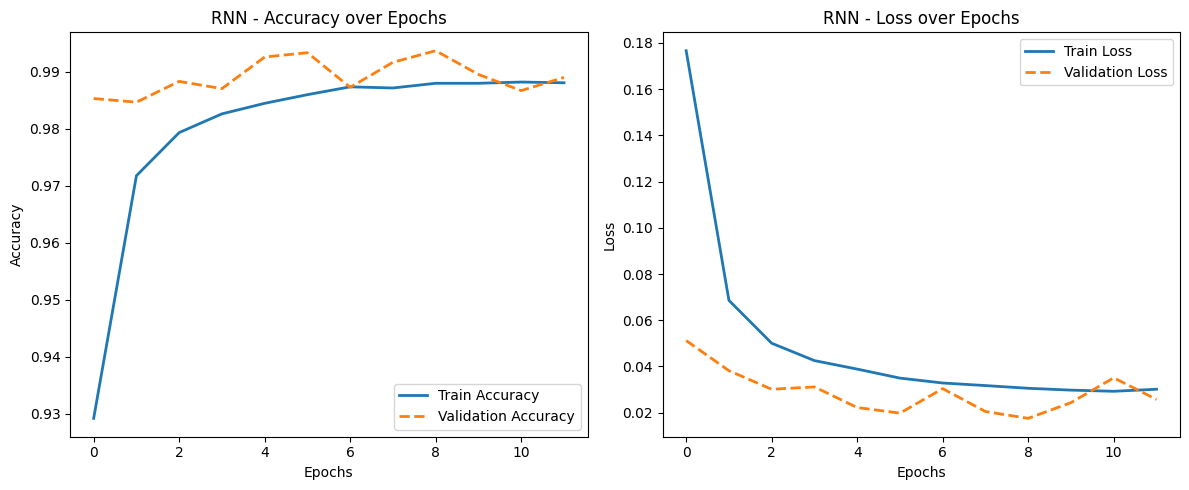

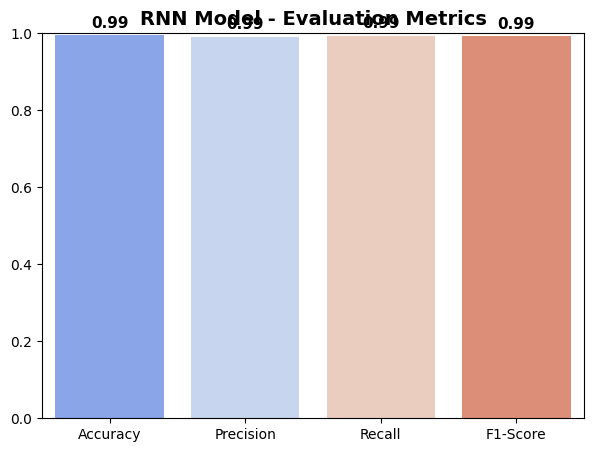

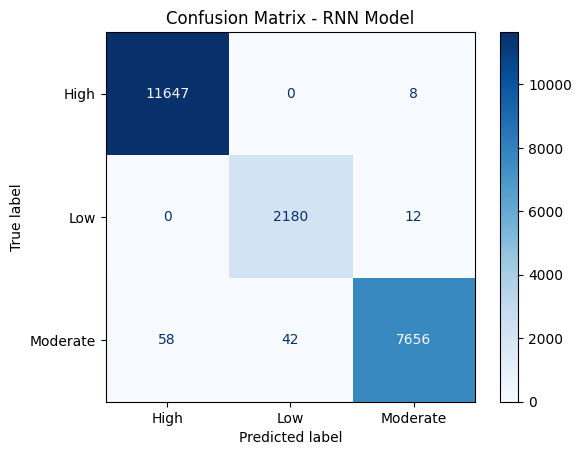

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # Change if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Heat_Stress_Label"].values

# --- 4️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ Reshape Input for RNN [samples, timesteps, features] ---
# Here, we treat each sample as one timestep sequence
X_train_reshaped = np.expand_dims(X_train_scaled, axis=1)
X_test_reshaped = np.expand_dims(X_test_scaled, axis=1)

# --- 7️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 8️⃣ Build RNN Model ---
model = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# --- 9️⃣ Compile Model ---
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- 🔟 Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- 11️⃣ Train Model ---
history = model.fit(
    X_train_reshaped, y_train_encoded,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 12️⃣ Evaluate Model ---
train_loss, train_acc = model.evaluate(X_train_reshaped, y_train_encoded, verbose=0)
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 13️⃣ Predictions & Metrics ---
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 RNN Model Performance:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 14️⃣ Plot: Accuracy & Loss Curves ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', linewidth=2)
plt.title("RNN - Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', linewidth=2)
plt.title("RNN - Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# --- 15️⃣ Visualization: Evaluation Metrics ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.ylim(0, 1)
plt.title("RNN Model - Evaluation Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 16️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - RNN Model")
plt.show()


Trial 3 Complete [00h 01m 26s]
val_accuracy: 0.9878486394882202

Best val_accuracy So Far: 0.9923041462898254
Total elapsed time: 00h 03m 56s

✅ Best Hyperparameters Found:
{'rnn_units': 32, 'dropout_rate': 0.5, 'dense_units': 48, 'learning_rate': 0.0005}
Epoch 1/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8323 - loss: 0.3783 - val_accuracy: 0.9759 - val_loss: 0.0583
Epoch 2/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9644 - loss: 0.0847 - val_accuracy: 0.9878 - val_loss: 0.0345
Epoch 3/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9743 - loss: 0.0637 - val_accuracy: 0.9791 - val_loss: 0.0515
Epoch 4/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9782 - loss: 0.0556 - val_accuracy: 0.9875 - val_loss: 0.0284
Epoch 5/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9795 - loss: 0.0508 - val_accuracy: 0.9895 - val_loss: 0.0260
Epoch 6/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9794 - loss: 0.0502 - v

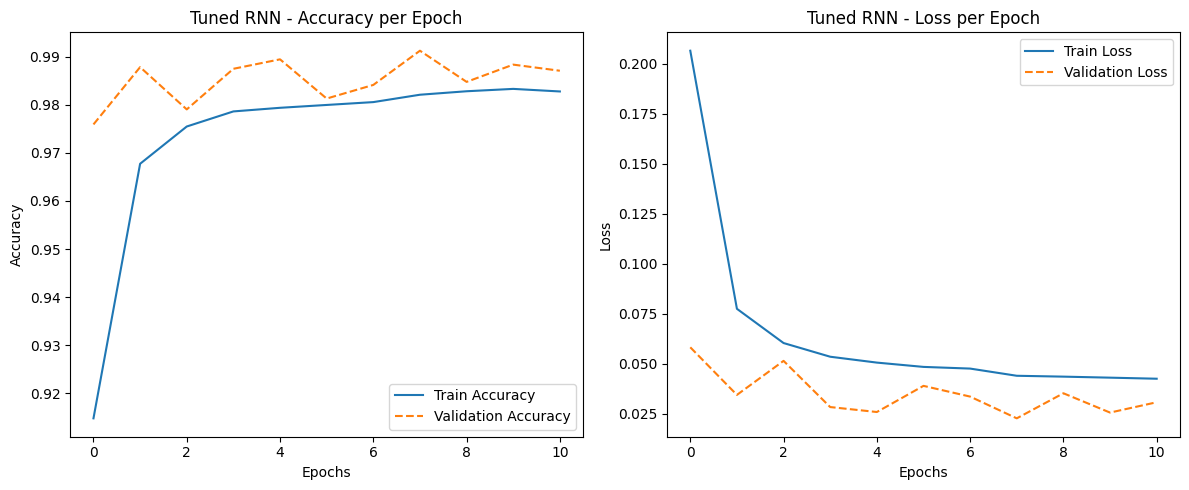

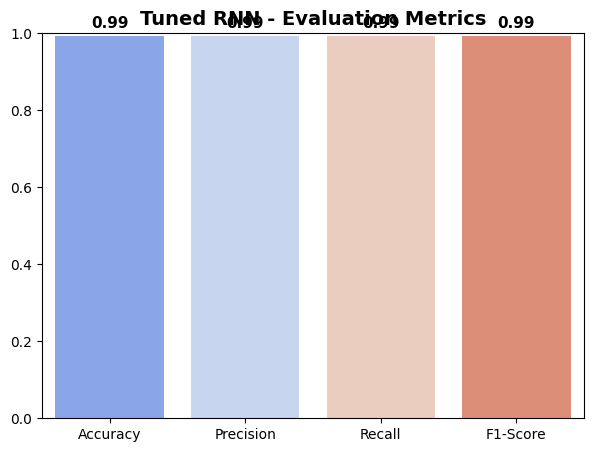

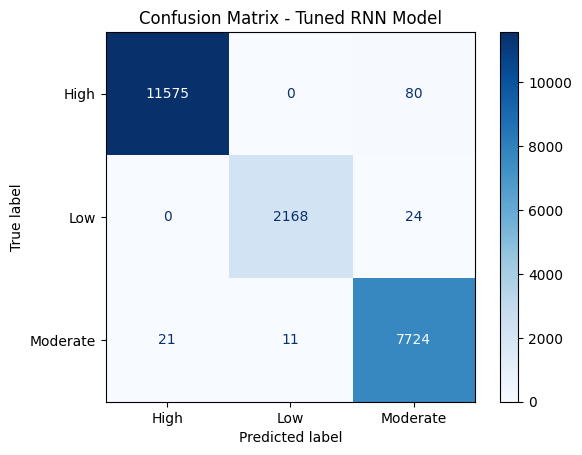

In [ ]:
# --- Import Libraries ---
!pip install -q -U keras-tuner

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # Change if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Heat_Stress_Label"]

# --- 4️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ Reshape for RNN Input (samples, timesteps, features) ---
# We treat each feature as a "time step" for simplicity
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# --- 7️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 8️⃣ Define Model Builder for Hyperparameter Tuning ---
def build_rnn_model(hp):
    model = Sequential()
    # RNN Layer
    model.add(SimpleRNN(
        units=hp.Int('rnn_units', min_value=16, max_value=128, step=16),
        activation='tanh',
        input_shape=(X_train_scaled.shape[1], 1)
    ))
    model.add(Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))

    # Dense hidden layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.005])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- 9️⃣ Initialize KerasTuner ---
tuner = kt.RandomSearch(
    build_rnn_model,
    objective='val_accuracy',
    max_trials=3,                # keeps runtime short
    executions_per_trial=1,
    directory='rnn_tuner_dir',
    project_name='rnn_tuning',
    overwrite=True
)

# --- 🔟 Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- 11️⃣ Run Hyperparameter Search ---
tuner.search(
    X_train_scaled, y_train_encoded,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 12️⃣ Get Best Hyperparameters ---
best_hp = tuner.get_best_hyperparameters(1)[0]
print("\n✅ Best Hyperparameters Found:")
print(best_hp.values)

# --- 13️⃣ Train Final Model with Best Hyperparameters ---
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train_scaled, y_train_encoded,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 14️⃣ Evaluate Model ---
train_loss, train_acc = best_model.evaluate(X_train_scaled, y_train_encoded, verbose=0)
test_loss, test_acc = best_model.evaluate(X_test_scaled, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 15️⃣ Predictions & Metrics ---
y_pred_probs = best_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 Tuned RNN Model Performance:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 16️⃣ Accuracy & Loss Curves ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title("Tuned RNN - Accuracy per Epoch")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title("Tuned RNN - Loss per Epoch")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout(); plt.show()

# --- 17️⃣ Evaluation Metrics Bar Plot ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]
plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.ylim(0, 1)
plt.title("Tuned RNN - Evaluation Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 18️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Tuned RNN Model")
plt.show()


CNN-LSTM MODEL

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
Epoch 1/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.8511 - loss: 0.3386 - val_accuracy: 0.9575 - val_loss: 0.1146
Epoch 2/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.9341 - loss: 0.1565 - val_accuracy: 0.9681 - val_loss: 0.0910
Epoch 3/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9446 - loss: 0.1322 - val_accuracy: 0.9729 - val_loss: 0.0741
Epoch 4/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9500 - loss: 0.1156 - val_accuracy: 0.9758 - val_loss: 0.0683
Epoch 5/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9546 - loss: 0.1088 - val_accuracy: 0.9765 - val_loss: 0.0653
Epoch 6/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9583 - loss: 0.1003 - val_accuracy: 0.9754 - val_loss: 0.0637
Epoch 7/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9592 - loss: 0.0952 - val_accuracy: 0.9774 - val_loss: 0.0615

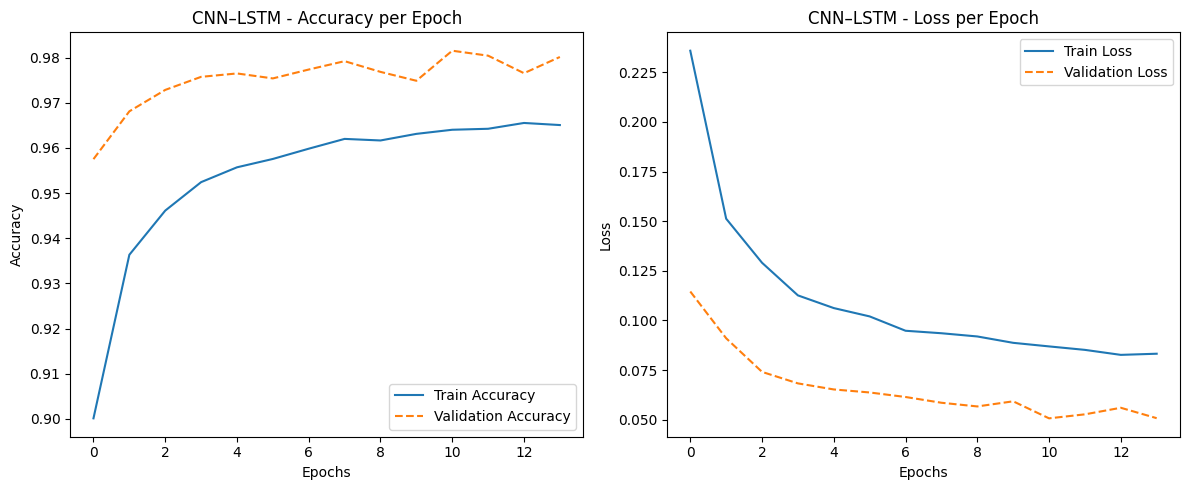

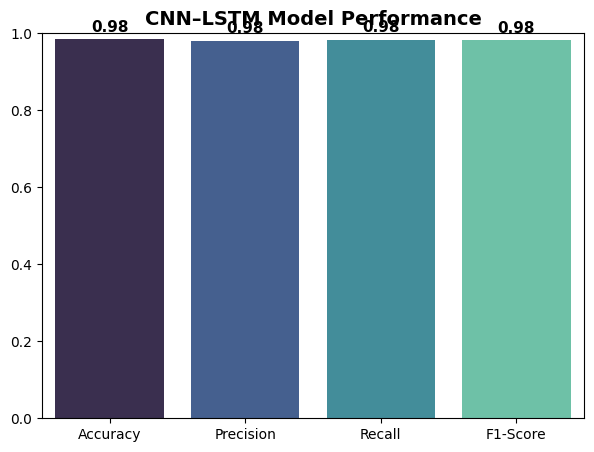

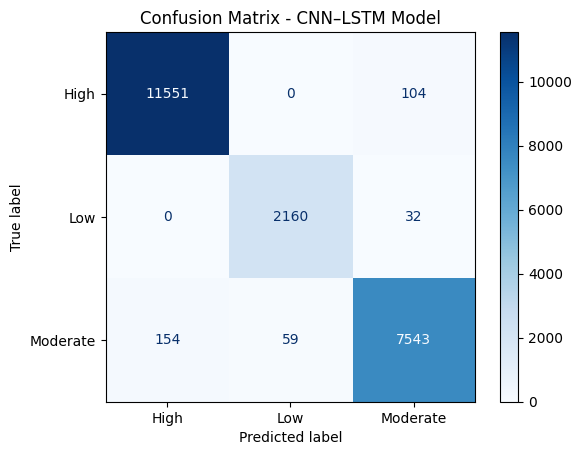

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Heat_Stress_Label"]

# --- 4️⃣ Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ Reshape for CNN-LSTM input ---
# CNN expects 3D input: (samples, timesteps, features)
# We treat each variable as a “time step”
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# --- 7️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 8️⃣ Build CNN-LSTM Model ---
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# --- 9️⃣ Compile Model ---
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- 🔟 Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- 11️⃣ Train Model ---
history = model.fit(
    X_train_scaled, y_train_encoded,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 12️⃣ Evaluate Model ---
train_loss, train_acc = model.evaluate(X_train_scaled, y_train_encoded, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 13️⃣ Predictions & Metrics ---
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 CNN–LSTM Model Performance:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 14️⃣ Accuracy & Loss Curves ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title("CNN–LSTM - Accuracy per Epoch")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title("CNN–LSTM - Loss per Epoch")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout(); plt.show()

# --- 15️⃣ Metrics Bar Plot ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="mako")
plt.ylim(0, 1)
plt.title("CNN–LSTM Model Performance", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 16️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - CNN–LSTM Model")
plt.show()


Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
Epoch 1/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8686 - loss: 0.3134 - val_accuracy: 0.9549 - val_loss: 0.1047
Epoch 2/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9439 - loss: 0.1330 - val_accuracy: 0.9655 - val_loss: 0.0813
Epoch 3/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9539 - loss: 0.1111 - val_accuracy: 0.9760 - val_loss: 0.0683
Epoch 4/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9610 - loss: 0.0962 - val_accuracy: 0.9719 - val_loss: 0.0653
Epoch 5/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9607 - loss: 0.0917 - val_accuracy: 0.9793 - val_loss: 0.0584
Epoch 6/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9642 - loss: 0.0848 - val_accuracy: 0.9811 - val_loss: 0.0523
Epoch 7/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9651 - loss: 0.0805 - val_accuracy: 0.9775 - val_loss: 0.0550
E

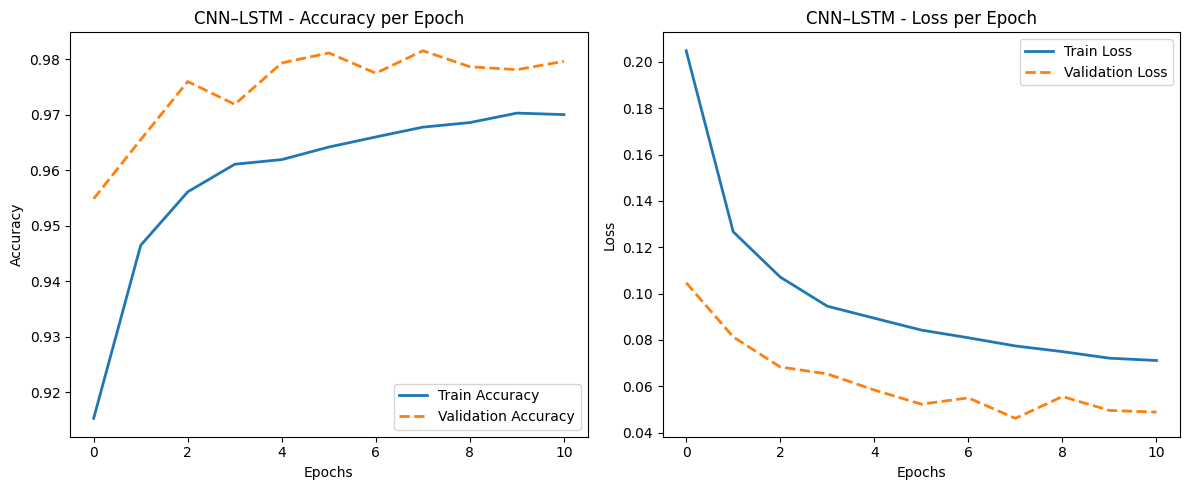

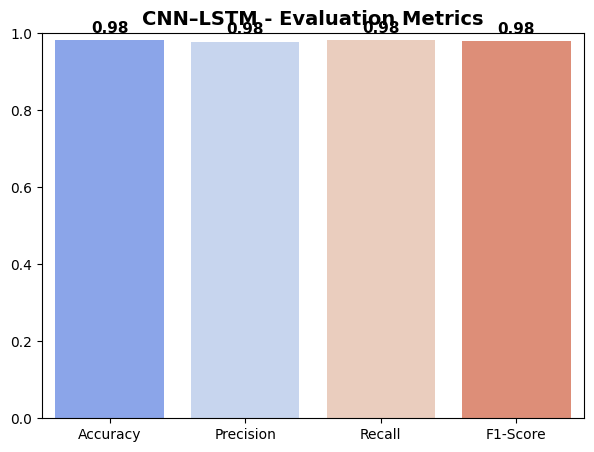

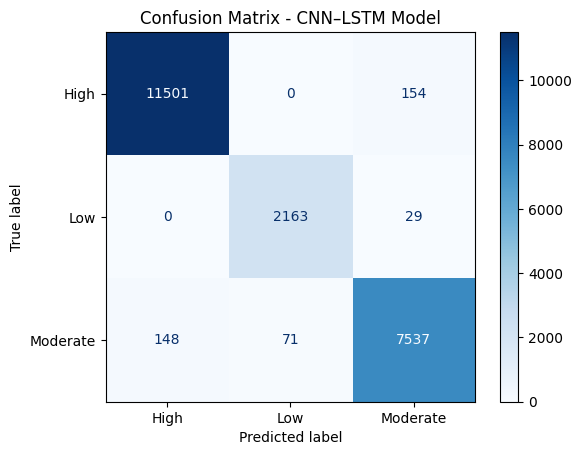

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # Change path if necessary
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Heat_Stress_Label"].values

# --- 4️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ Reshape for CNN-LSTM (samples, timesteps, features) ---
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# --- 7️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 8️⃣ Define CNN-LSTM Hybrid Model ---
model = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# --- 9️⃣ Compile Model ---
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- 🔟 Define Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- 11️⃣ Train Model ---
history = model.fit(
    X_train_reshaped, y_train_encoded,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 12️⃣ Evaluate Model ---
train_loss, train_acc = model.evaluate(X_train_reshaped, y_train_encoded, verbose=0)
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 13️⃣ Predictions & Metrics ---
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 CNN–LSTM Model Performance:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 14️⃣ Plot Accuracy & Loss Curves ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', linewidth=2)
plt.title("CNN–LSTM - Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', linewidth=2)
plt.title("CNN–LSTM - Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- 15️⃣ Visualization: Evaluation Metrics ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.ylim(0, 1)
plt.title("CNN–LSTM - Evaluation Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 16️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - CNN–LSTM Model")
plt.show()


Attention-LSTM Hybrid Model

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 6, 64)     │     16,896 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 6, 64)     │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 6, 64)     │      4,160 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6, 1)      │         65 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6)         │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 64, 6)     │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 6, 64)     │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 6, 64)     │          0 │ dropout_2[0][0],  │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 32)        │     12,416 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 3)         │         99 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,636 (131.39 KB)

 Trainable params: 33,636 (131.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.8873 - loss: 0.2956 - val_accuracy: 0.9395 - val_loss: 0.1429
Epoch 2/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9425 - loss: 0.1359 - val_accuracy: 0.9731 - val_loss: 0.0609
Epoch 3/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.9744 - loss: 0.0629 - val_accuracy: 0.9899 - val_loss: 0.0295
Epoch 4/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.9805 - loss: 0.0481 - val_accuracy: 0.9830 - val_loss: 0.0368
Epoch 5/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.9838 - loss: 0.0406 - val_accuracy: 0.9898 - val_loss: 0.0246
Epoch 6/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9850 - loss: 0.0369 - val_accuracy: 0.9824 - val_loss: 0.0420
Epoch 7/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.9858 - loss: 0.0357 - val_accuracy: 0.9748 - val_loss: 0.0626
Epoch 8/30
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.9864 -

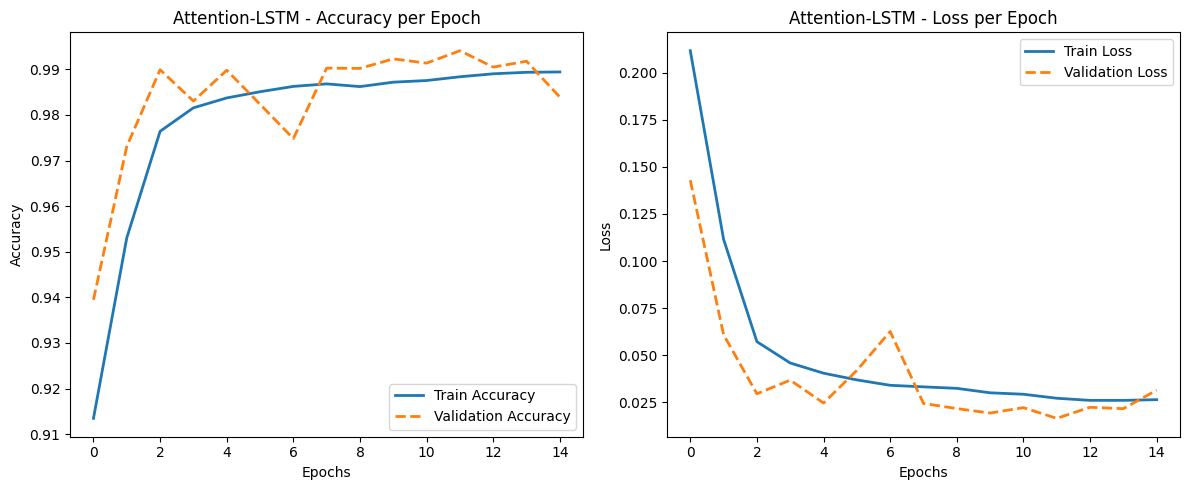

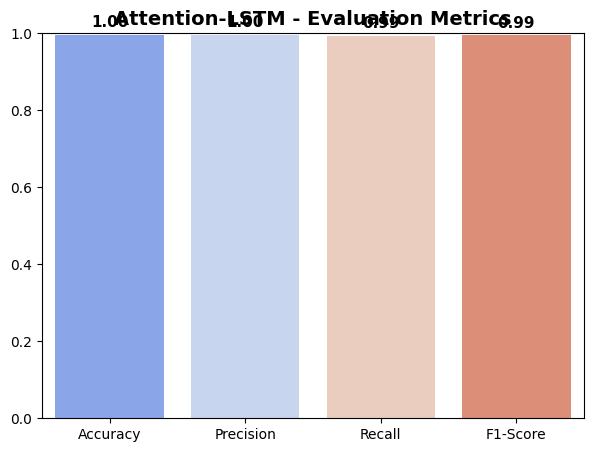

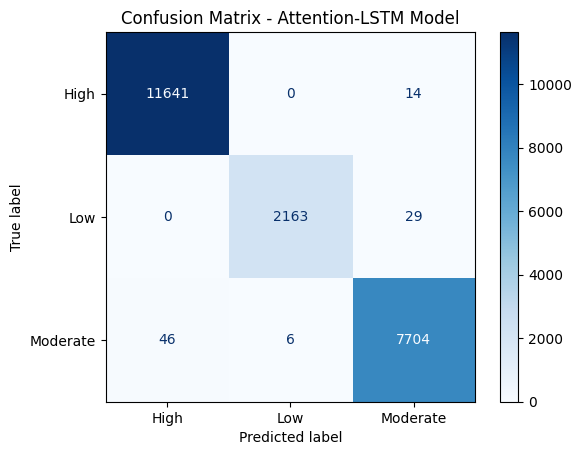

In [ ]:
# --- Import Libraries ---
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, Attention, Permute,
    Multiply, Flatten, RepeatVector
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # Adjust if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Heat_Stress_Label"].values

# --- 4️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ Reshape for LSTM Input: (samples, timesteps, features) ---
# Here each feature becomes a "time step"
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# --- 7️⃣ One-Hot Encode Target ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- 8️⃣ Define Attention-LSTM Hybrid Model ---
def attention_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # LSTM Encoder
    lstm_out = LSTM(64, return_sequences=True)(inputs)
    dropout_1 = Dropout(0.3)(lstm_out)

    # Attention Layer
    attention_probs = Dense(64, activation='tanh')(dropout_1)
    attention_probs = Dense(1, activation='softmax')(attention_probs)
    attention_probs = Flatten()(attention_probs)
    attention_probs = RepeatVector(64)(attention_probs)
    attention_probs = Permute([2, 1])(attention_probs)

    attention_mul = Multiply()([dropout_1, attention_probs])
    attention_output = LSTM(32)(attention_mul)
    dropout_2 = Dropout(0.3)(attention_output)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(dropout_2)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# --- 9️⃣ Build & Compile Model ---
model = attention_lstm_model((X_train_reshaped.shape[1], 1), num_classes)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# --- 🔟 Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- 11️⃣ Train Model ---
history = model.fit(
    X_train_reshaped, y_train_encoded,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 12️⃣ Evaluate Model ---
train_loss, train_acc = model.evaluate(X_train_reshaped, y_train_encoded, verbose=0)
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_encoded, verbose=0)

print("\n📈 Accuracy Comparison:")
print(f"Training Accuracy  : {train_acc:.3f}")
print(f"Testing Accuracy   : {test_acc:.3f}")

# --- 13️⃣ Predictions & Metrics ---
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 Attention-LSTM Model Performance:")
print(f"Accuracy  : {test_acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 14️⃣ Plot Accuracy & Loss Curves ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', linewidth=2)
plt.title("Attention-LSTM - Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', linewidth=2)
plt.title("Attention-LSTM - Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- 15️⃣ Visualization: Evaluation Metrics ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [test_acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.ylim(0, 1)
plt.title("Attention-LSTM - Evaluation Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 16️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Attention-LSTM Model")
plt.show()



🔍 Fast Hyperparameter Search Starting...

Testing config: LSTM1=32, LSTM2=16, LR=0.001, Dropout=0.2
→ Validation Accuracy: 0.9805
Testing config: LSTM1=32, LSTM2=16, LR=0.001, Dropout=0.3
→ Validation Accuracy: 0.9811
Testing config: LSTM1=32, LSTM2=16, LR=0.0005, Dropout=0.2
→ Validation Accuracy: 0.9547
Testing config: LSTM1=32, LSTM2=16, LR=0.0005, Dropout=0.3
→ Validation Accuracy: 0.9413
Testing config: LSTM1=64, LSTM2=16, LR=0.001, Dropout=0.2
→ Validation Accuracy: 0.9863
Testing config: LSTM1=64, LSTM2=16, LR=0.001, Dropout=0.3
→ Validation Accuracy: 0.9851
Testing config: LSTM1=64, LSTM2=16, LR=0.0005, Dropout=0.2
→ Validation Accuracy: 0.9727
Testing config: LSTM1=64, LSTM2=16, LR=0.0005, Dropout=0.3
→ Validation Accuracy: 0.9783

✅ Best Parameters Found:
{'units1': 64, 'units2': 16, 'lr': 0.001, 'dropout': 0.2}
Best Validation Accuracy: 0.9863
Epoch 1/20
865/865 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8593 - loss: 0.3992 - val_accuracy: 0.9259 - val_loss: 0.1740
Ep

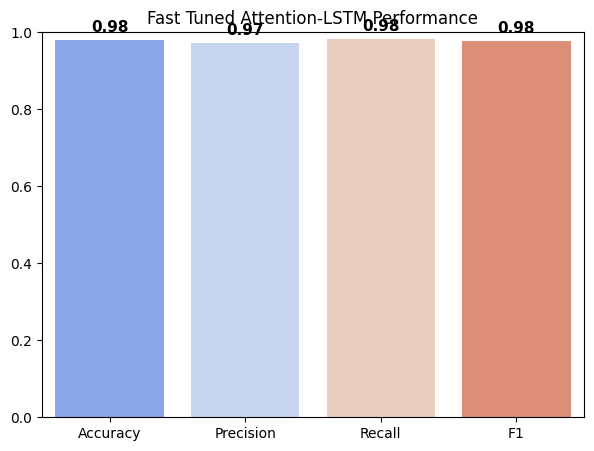

In [ ]:
# --- Optimized Fast Attention-LSTM Hyperparameter Tuning ---
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Flatten, Multiply, RepeatVector, Permute
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

# --- Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")

# Optional: use subset to speed up
df = df.sample(frac=0.4, random_state=42).reset_index(drop=True)

# --- Encode Target ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])

feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Heat_Stress_Label"].values

# --- Split & Scale ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Reshape for LSTM ---
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# --- Encode Targets ---
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
num_classes = y_train_encoded.shape[1]

# --- Build Model ---
def build_attention_lstm(units1=64, units2=32, lr=0.001, dropout=0.3):
    inputs = Input(shape=(X_train_reshaped.shape[1], 1))
    lstm_out = LSTM(units1, return_sequences=True)(inputs)
    attention_probs = Dense(1, activation='softmax')(lstm_out)
    attention_probs = Flatten()(attention_probs)
    attention_probs = RepeatVector(units1)(attention_probs)
    attention_probs = Permute([2, 1])(attention_probs)
    attention_mul = Multiply()([lstm_out, attention_probs])
    lstm_att = LSTM(units2)(attention_mul)
    drop = Dropout(dropout)(lstm_att)
    outputs = Dense(num_classes, activation='softmax')(drop)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# --- Smaller Hyperparameter Space ---
param_grid = {
    'units1': [32, 64],
    'units2': [16],
    'lr': [0.001, 0.0005],
    'dropout': [0.2, 0.3]
}

# --- Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

best_val_acc = 0
best_params = {}

print("\n🔍 Fast Hyperparameter Search Starting...\n")

for u1 in param_grid['units1']:
    for u2 in param_grid['units2']:
        for lr in param_grid['lr']:
            for drop in param_grid['dropout']:
                print(f"Testing config: LSTM1={u1}, LSTM2={u2}, LR={lr}, Dropout={drop}")
                model = build_attention_lstm(u1, u2, lr, drop)
                history = model.fit(
                    X_train_reshaped, y_train_encoded,
                    epochs=8,             # Reduced epochs for speed
                    batch_size=32,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[early_stop]
                )
                val_acc = max(history.history['val_accuracy'])
                print(f"→ Validation Accuracy: {val_acc:.4f}")

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_params = {'units1': u1, 'units2': u2, 'lr': lr, 'dropout': drop}
                    best_history = history

print("\n✅ Best Parameters Found:")
print(best_params)
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# --- Train Final Model with Best Params ---
best_model = build_attention_lstm(**best_params)
history = best_model.fit(
    X_train_reshaped, y_train_encoded,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- Evaluate ---
train_loss, train_acc = best_model.evaluate(X_train_reshaped, y_train_encoded, verbose=0)
test_loss, test_acc = best_model.evaluate(X_test_reshaped, y_test_encoded, verbose=0)
print(f"\n📈 Training Accuracy: {train_acc:.3f}")
print(f"📊 Testing Accuracy: {test_acc:.3f}")

# --- Classification Metrics ---
y_pred_probs = best_model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# --- Metrics Bar Chart ---
plt.figure(figsize=(7,5))
sns.barplot(x=["Accuracy", "Precision", "Recall", "F1"], y=[test_acc, precision, recall, f1], palette="coolwarm")
plt.ylim(0, 1)
plt.title("Fast Tuned Attention-LSTM Performance")
for i, v in enumerate([test_acc, precision, recall, f1]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()


decision tree + CNN model

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
676/676 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
CNN Feature Shape: (86409, 32)

📊 Hybrid Decision Tree + CNN Model Performance:
Accuracy  : 0.874
Precision : 0.868
Recall    : 0.844
F1 Score  : 0.855


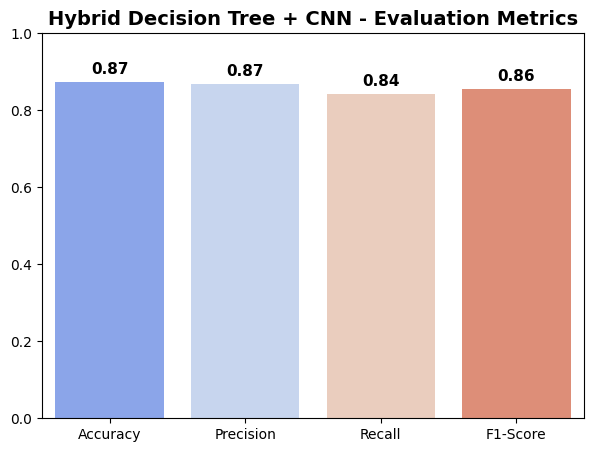

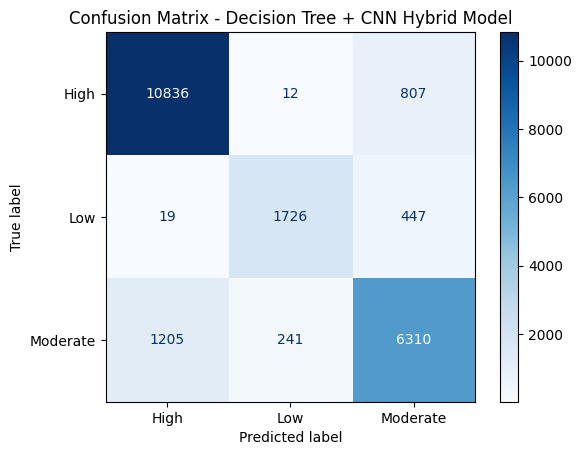

In [ ]:
# --- Import Libraries ---
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # Adjust path if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Heat_Stress_Label"].values

# --- 4️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ Reshape for CNN Input (samples, timesteps, features) ---
# Each feature is treated as a time step in a 1D sequence
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# --- 7️⃣ Build CNN Model ---
def build_cnn_feature_extractor(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=2, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32, kernel_size=2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    feature_output = Dense(32, activation='relu')(x)  # Feature embedding
    model = Model(inputs=inputs, outputs=feature_output)
    return model

cnn_model = build_cnn_feature_extractor((X_train_reshaped.shape[1], 1))
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')  # Not classification yet

# --- 8️⃣ Extract CNN Features ---
train_features = cnn_model.predict(X_train_reshaped)
test_features = cnn_model.predict(X_test_reshaped)

print("CNN Feature Shape:", train_features.shape)

# --- 9️⃣ Train Decision Tree on CNN Features ---
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    random_state=42
)

dt_classifier.fit(train_features, y_train)

# --- 🔟 Evaluate Model ---
y_pred = dt_classifier.predict(test_features)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 Hybrid Decision Tree + CNN Model Performance:")
print(f"Accuracy  : {acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 11️⃣ Visualization: Evaluation Metrics ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.ylim(0, 1)
plt.title("Hybrid Decision Tree + CNN - Evaluation Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 12️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Decision Tree + CNN Hybrid Model")
plt.show()


✅ Dataset Loaded Successfully!
Shape: (108012, 31)
Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
676/676 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
CNN Feature Shape: (86409, 32)
Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Best Decision Tree Parameters:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}

📊 Tuned Decision Tree + CNN Hybrid Performance:
Accuracy  : 0.958
Precision : 0.956
Recall    : 0.952
F1 Score  : 0.954


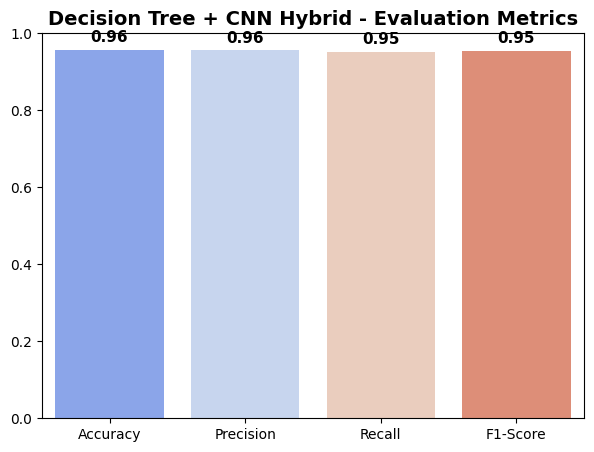

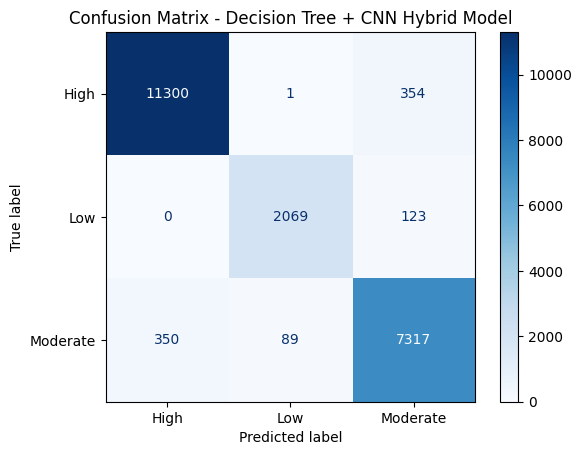

In [ ]:
# --- Import Libraries ---
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset (.xlsx or .csv auto-handling) ---
file_path = "/content/labeled_dataset.xlsx"  # Update path if needed

try:
    df = pd.read_excel(file_path, engine="openpyxl")
except Exception:
    df = pd.read_csv(file_path)

print("✅ Dataset Loaded Successfully!")
print("Shape:", df.shape)

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 3️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Heat_Stress_Label"].values

# --- 4️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6️⃣ Reshape Data for CNN ---
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# --- 7️⃣ Build CNN Feature Extractor ---
cnn_model = Sequential([
    Conv1D(64, 2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu')
])

# --- 8️⃣ Extract Features from CNN ---
cnn_features_train = cnn_model.predict(X_train_cnn)
cnn_features_test = cnn_model.predict(X_test_cnn)

print("CNN Feature Shape:", cnn_features_train.shape)

# --- 9️⃣ Decision Tree Hyperparameter Tuning ---
param_grid = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    dt,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(cnn_features_train, y_train)

best_dt = grid_search.best_estimator_
print("\n✅ Best Decision Tree Parameters:")
print(grid_search.best_params_)

# --- 🔟 Evaluate Tuned Decision Tree ---
y_pred = best_dt.predict(cnn_features_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 Tuned Decision Tree + CNN Hybrid Performance:")
print(f"Accuracy  : {acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 11️⃣ Metrics Bar Chart ---
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [acc, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.ylim(0, 1)
plt.title("Decision Tree + CNN Hybrid - Evaluation Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()

# --- 12️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Decision Tree + CNN Hybrid Model")
plt.show()



📈 MODEL COMPARISON TABLE:

                  Model  Accuracy  Precision  Recall  F1-Score
0            Auto ARIMA     0.998      0.499   0.500     0.499
1                   GRU     0.997      0.995   0.996     0.996
2                   SVM     0.997      0.997   0.996     0.997
3               Bi-LSTM     0.996      0.994   0.996     0.995
4                   ANN     0.995      0.996   0.990     0.993
5                   MLP     0.994      0.994   0.990     0.992
6                  LSTM     0.994      0.992   0.990     0.991
7                   RNN     0.994      0.993   0.993     0.990
8                   CNN     0.993      0.993   0.992     0.992
9               XGBoost     0.992      0.991   0.989     0.990
10             CatBoost     0.991      0.991   0.988     0.990
11             LightGBM     0.990      0.989   0.988     0.988
12  Logistic Regression     0.989      0.989   0.987     0.988
13              SARIMAX     0.982      0.982   0.971     0.977
14             CNN-LSTM    

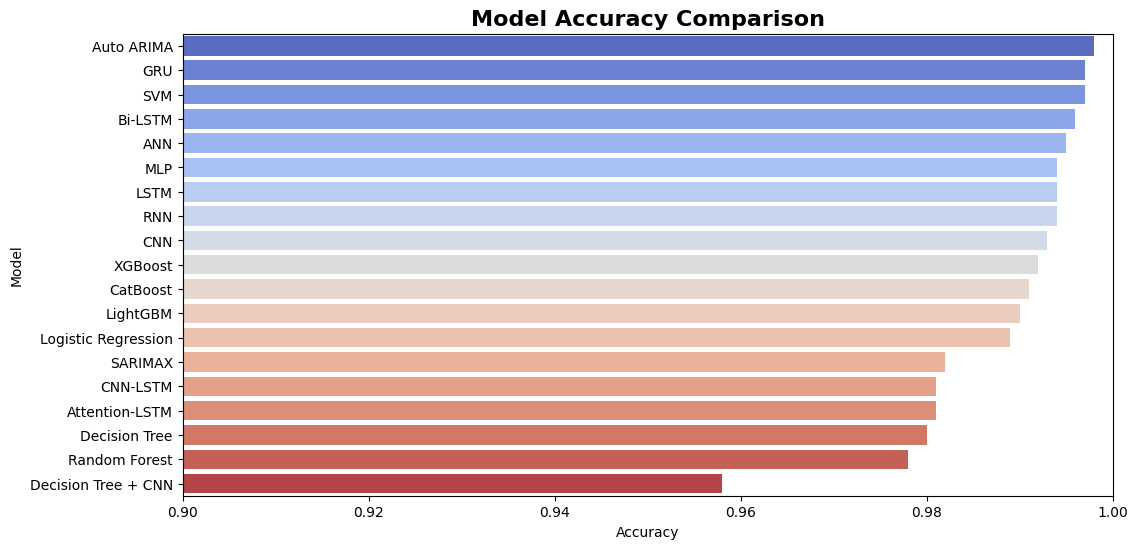

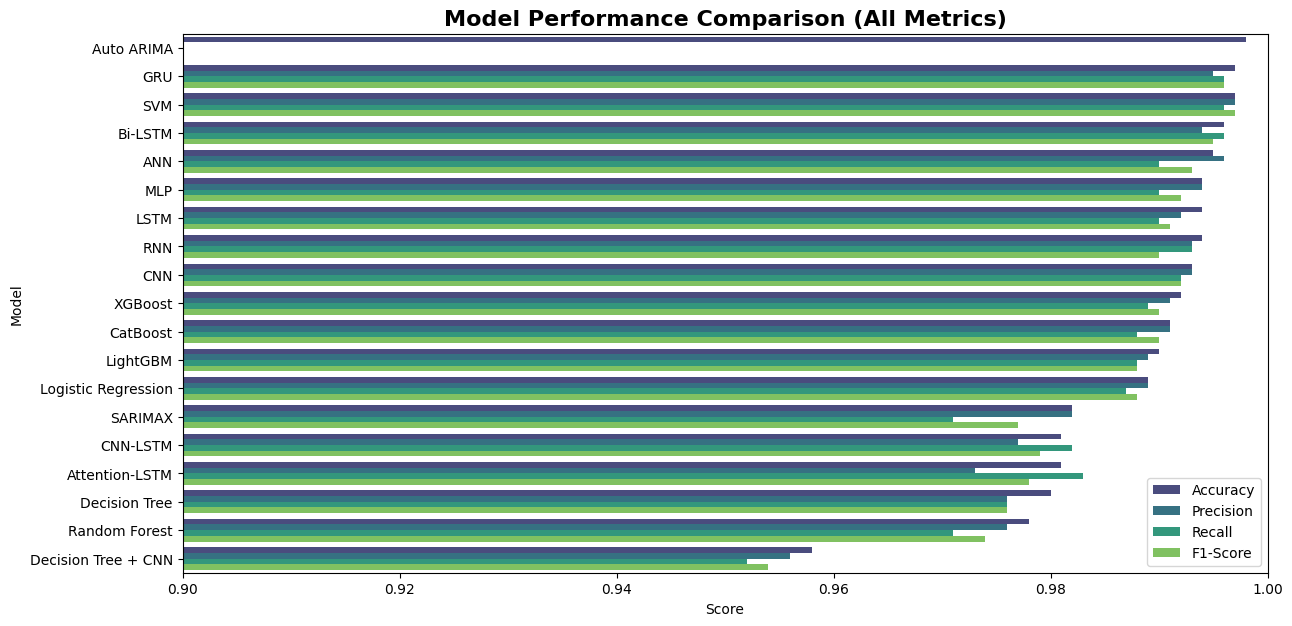

In [ ]:
# --- 📊 MODEL COMPARISON CODE ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 📋 1️⃣ Store All Model Results
# -----------------------------
model_results = [
    ["Logistic Regression", 0.989, 0.989, 0.987, 0.988],
    ["Auto ARIMA", 0.998, 0.499, 0.500, 0.499],
    ["SARIMAX", 0.982, 0.982, 0.971, 0.977],
    ["Decision Tree", 0.980, 0.976, 0.976, 0.976],
    ["Random Forest", 0.978, 0.976, 0.971, 0.974],
    ["XGBoost", 0.992, 0.991, 0.989, 0.990],
    ["LightGBM", 0.990, 0.989, 0.988, 0.988],
    ["CatBoost", 0.991, 0.991, 0.988, 0.990],
    ["SVM", 0.997, 0.997, 0.996, 0.997],
    ["ANN", 0.995, 0.996, 0.990, 0.993],
    ["CNN", 0.993, 0.993, 0.992, 0.992],
    ["LSTM", 0.994, 0.992, 0.990, 0.991],
    ["GRU", 0.997, 0.995, 0.996, 0.996],
    ["Bi-LSTM", 0.996, 0.994, 0.996, 0.995],
    ["MLP", 0.994, 0.994, 0.990, 0.992],
    ["RNN", 0.994, 0.993, 0.993, 0.990],
    ["CNN-LSTM", 0.981, 0.977, 0.982, 0.979],
    ["Attention-LSTM", 0.981, 0.973, 0.983, 0.978],
    ["Decision Tree + CNN", 0.958, 0.956, 0.952, 0.954]
]

# -----------------------------
# 📊 2️⃣ Convert to DataFrame
# -----------------------------
df_compare = pd.DataFrame(model_results,
                          columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])

# Sort by Accuracy for better visualization
df_compare = df_compare.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

# Display results
print("\n📈 MODEL COMPARISON TABLE:\n")
print(df_compare)

# -----------------------------
# 🎨 3️⃣ Visualization - Accuracy
# -----------------------------
plt.figure(figsize=(12,6))
sns.barplot(x="Accuracy", y="Model", data=df_compare, palette="coolwarm")
plt.title("Model Accuracy Comparison", fontsize=16, weight='bold')
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0.9, 1.0)
plt.show()

# -----------------------------
# 🎨 4️⃣ Visualization - Other Metrics
# -----------------------------
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
df_melted = df_compare.melt(id_vars="Model", value_vars=metrics, var_name="Metric", value_name="Score")

plt.figure(figsize=(14,7))
sns.barplot(x="Score", y="Model", hue="Metric", data=df_melted, palette="viridis")
plt.title("Model Performance Comparison (All Metrics)", fontsize=16, weight='bold')
plt.xlabel("Score")
plt.ylabel("Model")
plt.legend(loc="lower right")
plt.xlim(0.9, 1.0)
plt.show()


transfer learning


🚀 Training Base SVM Model on 'Coimbatore' ...
✅ Base model trained.

📍 Evaluating Transfer Learning → 'Chennai'
📍 Evaluating Transfer Learning → 'Dharmapuri'
📍 Evaluating Transfer Learning → 'Dindigul'
📍 Evaluating Transfer Learning → 'Kanchipuram'
📍 Evaluating Transfer Learning → 'Kanyakumari'
📍 Evaluating Transfer Learning → 'Karur'
📍 Evaluating Transfer Learning → 'Madurai'
📍 Evaluating Transfer Learning → 'Perambalur'
📍 Evaluating Transfer Learning → 'Puducherry'
📍 Evaluating Transfer Learning → 'Ramanathapuram'
📍 Evaluating Transfer Learning → 'Salem'
📍 Evaluating Transfer Learning → 'Theni'
📍 Evaluating Transfer Learning → 'Thiruvarur'
📍 Evaluating Transfer Learning → 'Thoothukudi'
📍 Evaluating Transfer Learning → 'Tiruppattur'
📍 Evaluating Transfer Learning → 'Trichy'
📍 Evaluating Transfer Learning → 'Vellore'
📍 Evaluating Transfer Learning → 'Viruthunagar'

📊 Transfer Learning Summary:
          District  Acc_Before  Prec_Before  Rec_Before  F1_Before  Acc_After  \
0          

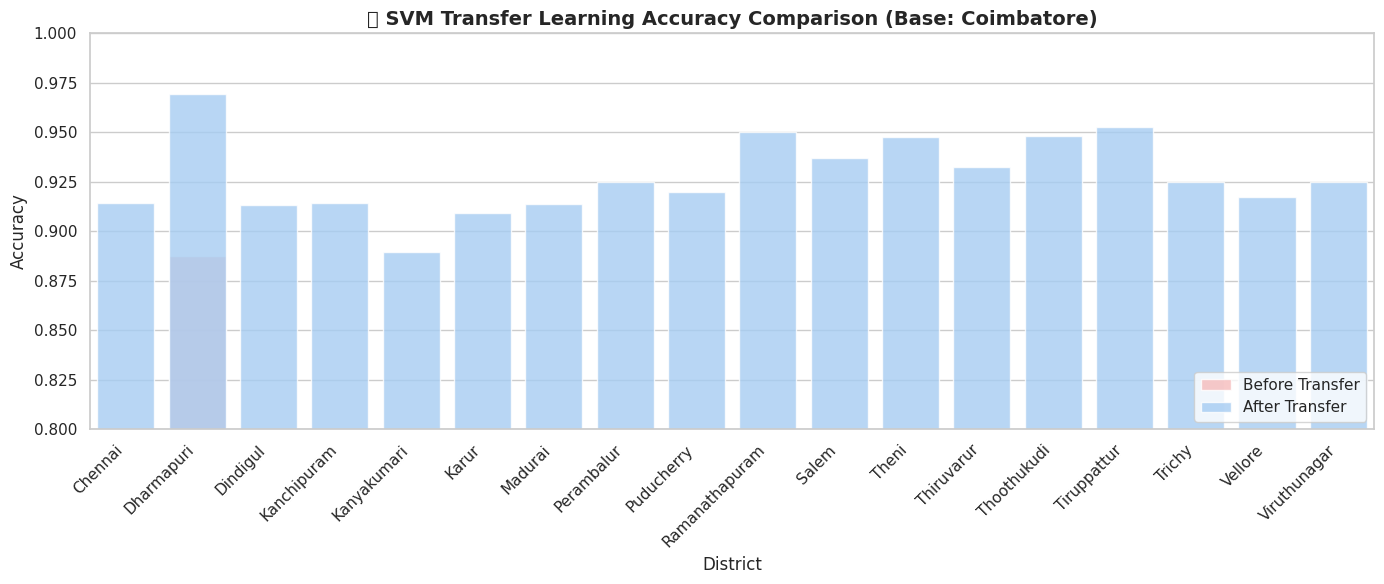

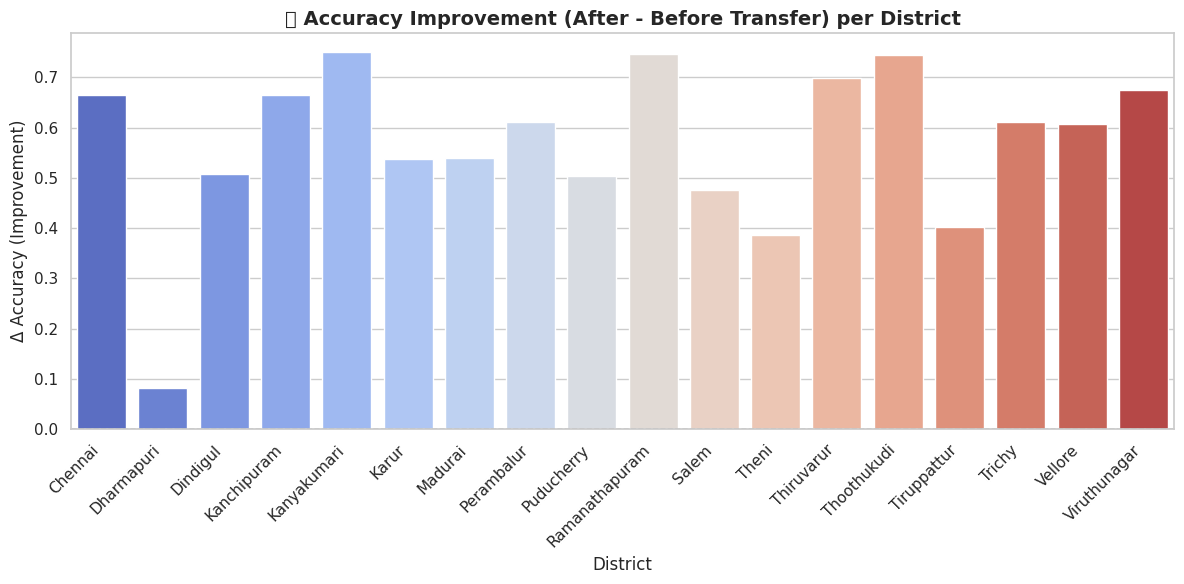


📁 Results saved to 'svm_transfer_learning_results.csv'


In [ ]:
# --- 📦 Import Libraries ---
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # adjust path if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])

# --- 3️⃣ Define Features ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]

# --- 4️⃣ Choose Base District ---
base_district = "coimbatore"
base_df = df[df["place"].str.lower() == base_district]

X_base = base_df[feature_cols].values
y_base = base_df["Heat_Stress_Label"].values

scaler = StandardScaler()
X_base_scaled = scaler.fit_transform(X_base)

# --- 5️⃣ Train Base SVM on Base District ---
print(f"\n🚀 Training Base SVM Model on '{base_district.title()}' ...")
base_model = SVC(kernel="rbf", probability=True)
base_model.fit(X_base_scaled, y_base)
print("✅ Base model trained.\n")

# --- 6️⃣ Transfer Learning Across All Other Districts ---
districts = sorted(df["place"].str.lower().unique())
results = []

for target in districts:
    if target == base_district:
        continue  # skip base district

    print(f"📍 Evaluating Transfer Learning → '{target.title()}'")
    target_df = df[df["place"].str.lower() == target]
    X_target = target_df[feature_cols].values
    y_target = target_df["Heat_Stress_Label"].values

    X_target_scaled = scaler.transform(X_target)

    # --- Before Transfer ---
    y_base_pred = base_model.predict(X_target_scaled)
    acc_before = accuracy_score(y_target, y_base_pred)
    prec_before = precision_score(y_target, y_base_pred, average="macro")
    rec_before = recall_score(y_target, y_base_pred, average="macro")
    f1_before = f1_score(y_target, y_base_pred, average="macro")

    # --- Transfer (Fine-tune) ---
    transfer_model = SVC(kernel="rbf", probability=True)
    transfer_model.fit(X_target_scaled, y_target)

    y_transfer_pred = transfer_model.predict(X_target_scaled)
    acc_after = accuracy_score(y_target, y_transfer_pred)
    prec_after = precision_score(y_target, y_transfer_pred, average="macro")
    rec_after = recall_score(y_target, y_transfer_pred, average="macro")
    f1_after = f1_score(y_target, y_transfer_pred, average="macro")

    results.append({
        "District": target.title(),
        "Acc_Before": acc_before, "Prec_Before": prec_before, "Rec_Before": rec_before, "F1_Before": f1_before,
        "Acc_After": acc_after, "Prec_After": prec_after, "Rec_After": rec_after, "F1_After": f1_after,
        "Accuracy_Improvement": acc_after - acc_before
    })

# --- 7️⃣ Collect Results into DataFrame ---
results_df = pd.DataFrame(results)
print("\n📊 Transfer Learning Summary:")
print(results_df.round(3))

# --- 8️⃣ Plot Before vs After Transfer Learning (Accuracy) ---
plt.figure(figsize=(14,6))
sns.barplot(x="District", y="Acc_Before", data=results_df, color="#ffb3b3", label="Before Transfer", alpha=0.8)
sns.barplot(x="District", y="Acc_After", data=results_df, color="#99ccff", label="After Transfer", alpha=0.8)

plt.xticks(rotation=45, ha="right")
plt.ylim(0.8, 1.0)
plt.title("📈 SVM Transfer Learning Accuracy Comparison (Base: Coimbatore)", fontsize=14, weight="bold")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# --- 9️⃣ New: Plot Accuracy Improvement (Δ) per District ---
plt.figure(figsize=(12,6))
sns.barplot(x="District", y="Accuracy_Improvement", data=results_df, palette="coolwarm")
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.xticks(rotation=45, ha="right")
plt.title("🔺 Accuracy Improvement (After - Before Transfer) per District", fontsize=14, weight="bold")
plt.ylabel("Δ Accuracy (Improvement)")
plt.tight_layout()
plt.show()

# --- 🔟 Save Results ---
results_df.to_csv("/content/svm_transfer_learning_results.csv", index=False)
print("\n📁 Results saved to 'svm_transfer_learning_results.csv'")


classification tassk

Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
SVM Input Shape: (86409, 6)

🚀 Training SVM Binary Classifier...

📊 SVM Binary Classification Performance:
Accuracy  : 0.998
Precision : 0.998
Recall    : 1.000
F1 Score  : 0.999


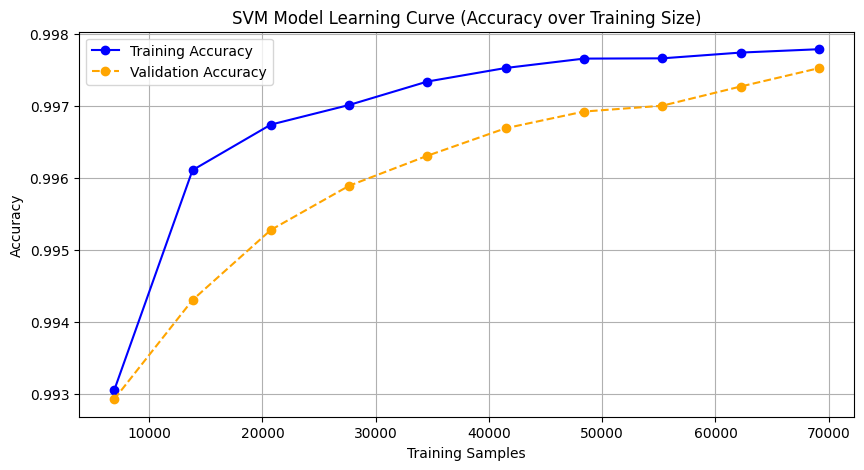

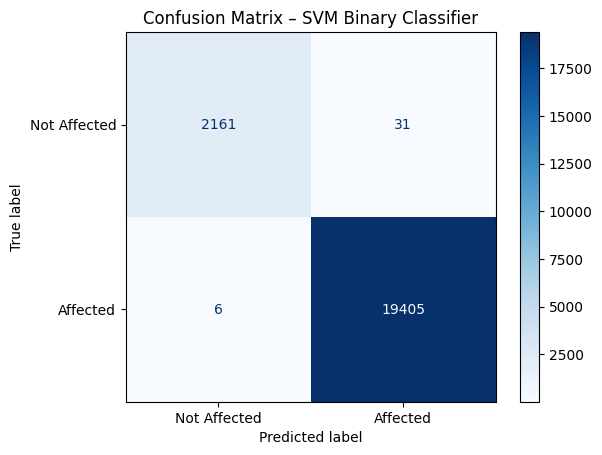


🌡️ Overall Summary of Heat Stress Classification (SVM):
Affected      : 19436 (89.97%)
Not Affected  : 2167 (10.03%)


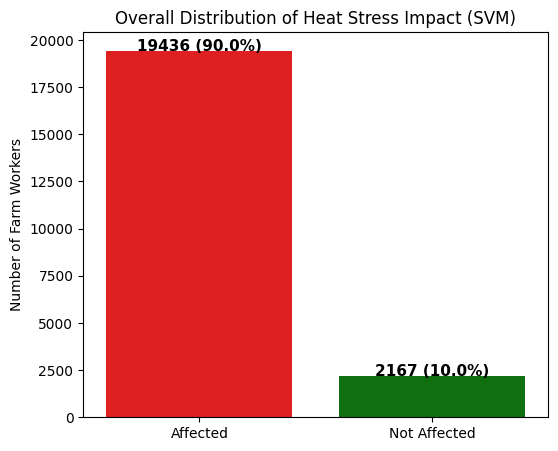

In [ ]:
# --- Import Libraries ---
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"  # Change if needed
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Encode Target Variable ---
label_encoder = LabelEncoder()
df["Heat_Stress_Label"] = label_encoder.fit_transform(df["Heat_Stress_Label"])
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# --- 3️⃣ Convert to Binary: High & Moderate = Affected (1), Low = Not Affected (0) ---
df["Binary_Label"] = df["Heat_Stress_Label"].apply(lambda x: 1 if x in [0, 2] else 0)

# --- 4️⃣ Define Features and Target ---
feature_cols = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
X = df[feature_cols].values
y = df["Binary_Label"].values

# --- 5️⃣ Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6️⃣ Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7️⃣ Reshape for SVM Input (Explanation) ---
# ⚠️ SVM expects 2D input [samples, features], so no real reshaping needed.
# But keeping the section for code structure consistency.
X_train_reshaped = X_train_scaled  # Already 2D
X_test_reshaped = X_test_scaled
print(f"SVM Input Shape: {X_train_reshaped.shape}")

# --- 8️⃣ Build and Train SVM Model ---
print("\n🚀 Training SVM Binary Classifier...")
svm_model = SVC(kernel="rbf", probability=True, random_state=42)
svm_model.fit(X_train_reshaped, y_train)

# --- 9️⃣ Evaluate Model ---
y_pred = svm_model.predict(X_test_reshaped)
y_pred_probs = svm_model.predict_proba(X_test_reshaped)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n📊 SVM Binary Classification Performance:")
print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- 🔟 Visualization: Accuracy & Loss (Learning Curve) ---
train_sizes, train_scores, test_scores = learning_curve(
    SVC(kernel="rbf", random_state=42),
    X_train_reshaped, y_train,
    cv=5, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o--', color='orange', label='Validation Accuracy')
plt.title("SVM Model Learning Curve (Accuracy over Training Size)")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# --- 11️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Affected", "Affected"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – SVM Binary Classifier")
plt.show()

# --- 12️⃣ Overall Summary of Affected / Not Affected ---
affected_count = (y_pred == 1).sum()
not_affected_count = (y_pred == 0).sum()
total = len(y_pred)
print("\n🌡️ Overall Summary of Heat Stress Classification (SVM):")
print(f"Affected      : {affected_count} ({affected_count/total*100:.2f}%)")
print(f"Not Affected  : {not_affected_count} ({not_affected_count/total*100:.2f}%)")

# --- 13️⃣ Visualization: Affected vs Not Affected ---
plt.figure(figsize=(6,5))
sns.barplot(x=["Affected", "Not Affected"], y=[affected_count, not_affected_count], palette=["red", "green"])
plt.title("Overall Distribution of Heat Stress Impact (SVM)")
for i, v in enumerate([affected_count, not_affected_count]):
    plt.text(i, v + 5, f"{v} ({v/total*100:.1f}%)", ha='center', fontsize=11, weight="bold")
plt.ylabel("Number of Farm Workers")
plt.show()


temporal analysis

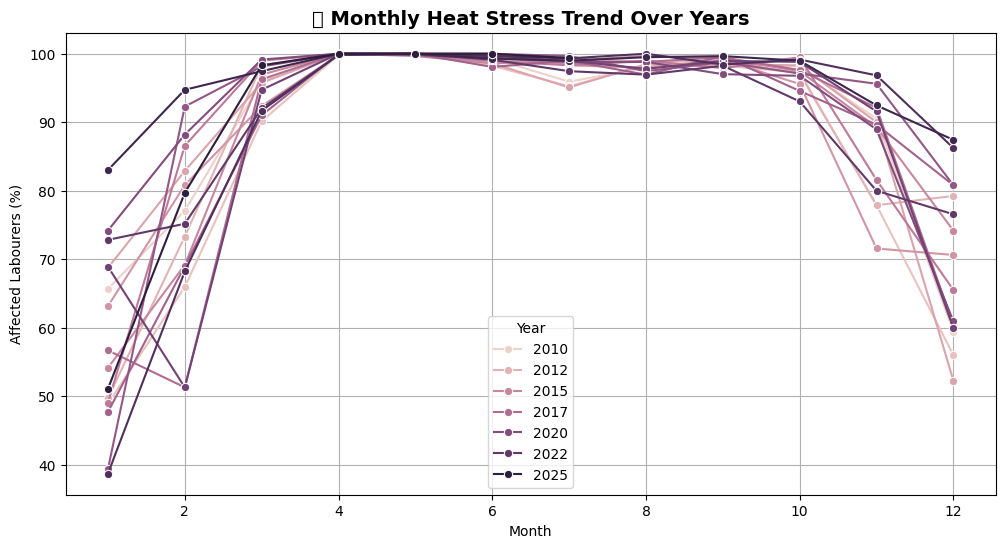

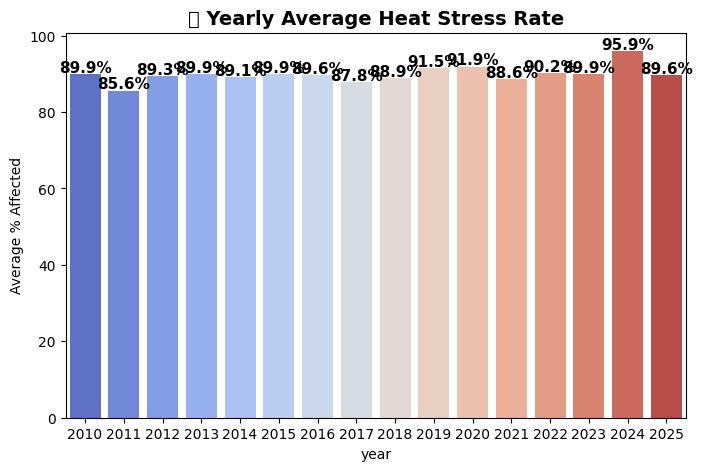

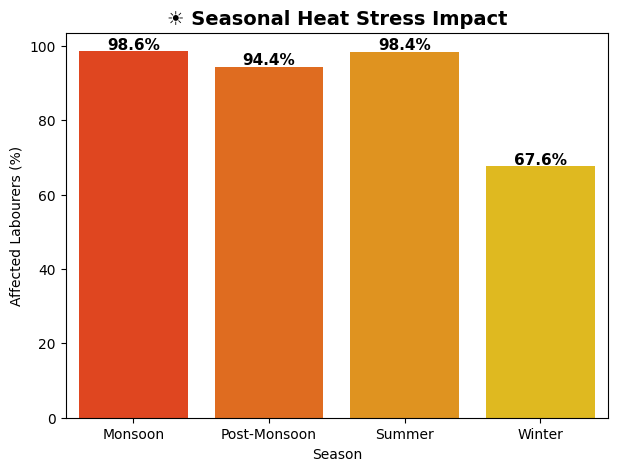

📊 Temporal Heat Stress Summary:
Average Heat Stress Rate per Year:
    year  Heat_Stress_Rate
0   2010         89.930756
1   2011         85.580389
2   2012         89.328347
3   2013         89.863014
4   2014         89.142033
5   2015         89.877433
6   2016         89.559965
7   2017         87.759516
8   2018         88.940159
9   2019         91.521269
10  2020         91.860800
11  2021         88.550829
12  2022         90.180245
13  2023         89.920692
14  2024         95.944780
15  2025         89.550332

Average Heat Stress Rate per Season:
         Season  Heat_Stress_Rate
0       Monsoon         98.609990
1  Post-Monsoon         94.393676
2        Summer         98.433924
3        Winter         67.634020

🚀 Training SVM Temporal Classifier...

📊 SVM Temporal Classification Performance:
Accuracy  : 0.998
Precision : 0.998
Recall    : 0.999
F1 Score  : 0.999


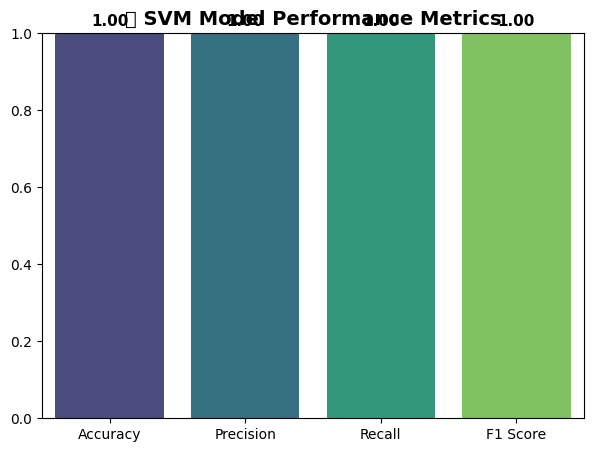

In [ ]:
# --- Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Ensure Date Column ---
if 'date' not in df.columns:
    df['date'] = pd.date_range(start="2020-01-01", periods=len(df), freq="D")

df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# --- 3️⃣ Encode Heat Stress Labels ---
le = LabelEncoder()
df["Heat_Stress_Label"] = le.fit_transform(df["Heat_Stress_Label"])
df["Binary_Label"] = df["Heat_Stress_Label"].apply(lambda x: 1 if x in [0, 2] else 0)

# --- 4️⃣ Temporal Aggregation ---
monthly_trends = df.groupby(['year', 'month'])['Binary_Label'].mean().reset_index()
monthly_trends['Heat_Stress_Rate'] = monthly_trends['Binary_Label'] * 100

yearly_trends = df.groupby(['year'])['Binary_Label'].mean().reset_index()
yearly_trends['Heat_Stress_Rate'] = yearly_trends['Binary_Label'] * 100

# --- 5️⃣ Seasonal Grouping ---
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8]:
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

df['Season'] = df['month'].apply(get_season)
seasonal_trends = df.groupby('Season')['Binary_Label'].mean().reset_index()
seasonal_trends['Heat_Stress_Rate'] = seasonal_trends['Binary_Label'] * 100

# --- 6️⃣ Visualizations ---
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_trends, x="month", y="Heat_Stress_Rate", hue="year", marker="o")
plt.title("🌡️ Monthly Heat Stress Trend Over Years", fontsize=14, weight="bold")
plt.xlabel("Month"); plt.ylabel("Affected Labourers (%)"); plt.legend(title="Year"); plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x="year", y="Heat_Stress_Rate", data=yearly_trends, palette="coolwarm")
plt.title("📆 Yearly Average Heat Stress Rate", fontsize=14, weight="bold")
plt.ylabel("Average % Affected")
for i, v in enumerate(yearly_trends['Heat_Stress_Rate']):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=11, weight="bold")
plt.show()

plt.figure(figsize=(7,5))
sns.barplot(x="Season", y="Heat_Stress_Rate", data=seasonal_trends, palette="autumn")
plt.title("☀️ Seasonal Heat Stress Impact", fontsize=14, weight="bold")
for i, v in enumerate(seasonal_trends['Heat_Stress_Rate']):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=11, weight="bold")
plt.ylabel("Affected Labourers (%)")
plt.show()

print("📊 Temporal Heat Stress Summary:")
print("Average Heat Stress Rate per Year:")
print(yearly_trends[['year', 'Heat_Stress_Rate']])
print("\nAverage Heat Stress Rate per Season:")
print(seasonal_trends[['Season', 'Heat_Stress_Rate']])

# =====================================================
# 🌡️ SVM Model for Temporal Heat Stress Prediction
# =====================================================

# --- Feature & Target Selection ---
features = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]
target = "Binary_Label"

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])
y = df[target].values

# --- Train-Test Split ---
split = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y[:split], y[split:]

# --- Build & Train SVM ---
print("\n🚀 Training SVM Temporal Classifier...")
svm_model = SVC(kernel="rbf", probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# --- Evaluate ---
y_pred = svm_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n📊 SVM Temporal Classification Performance:")
print(f"Accuracy  : {acc:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# --- Performance Visualization ---
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [acc, precision, recall, f1]
plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title("📊 SVM Model Performance Metrics", fontsize=14, weight="bold")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11, weight="bold")
plt.show()


spatial extraction


📊 Spatial Heat Stress Summary (SVM):
          District  Heat_Stress_Rate
0      Thoothukudi            100.00
1   Ramanathapuram             99.74
2       Thiruvarur             98.77
3     Viruthunagar             98.77
4          Chennai             97.36
5      Kanchipuram             97.36
6           Trichy             96.13
7       Perambalur             96.13
8            Karur             94.81
9          Madurai             94.64
10        Dindigul             94.55
11      Puducherry             91.03
12           Salem             90.94
13         Vellore             89.62
14     Tiruppattur             84.52
15      Dharmapuri             83.03
16      Coimbatore             79.51
17           Theni             61.65

🔥 Top 3 Most Heat-Stressed Locations:
      District  Heat_Stress_Rate
   Thoothukudi        100.000000
Ramanathapuram         99.736148
    Thiruvarur         98.769772

❄️ Least 3 Affected Locations:
  District  Heat_Stress_Rate
     Theni         61.65347

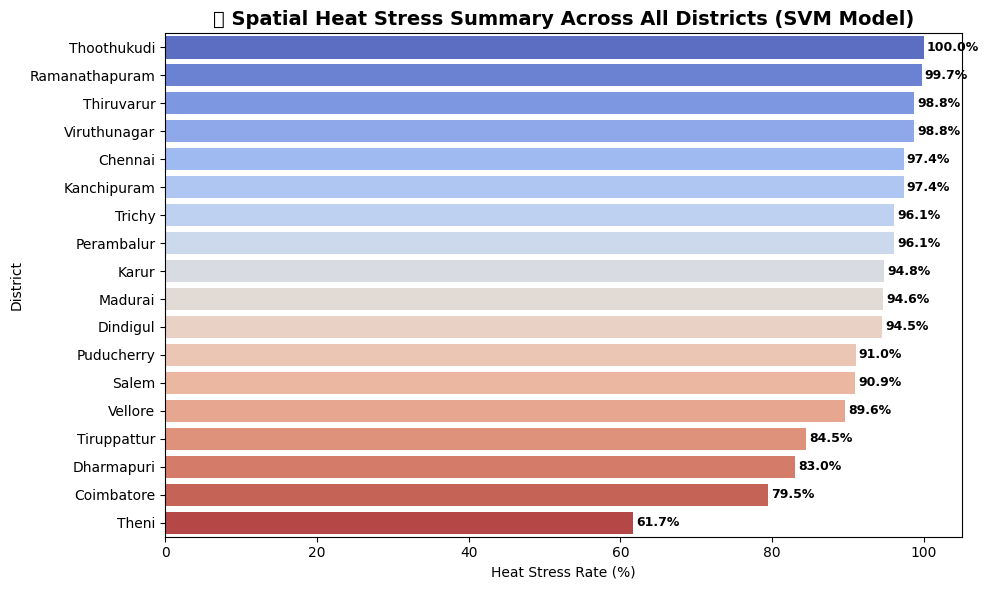

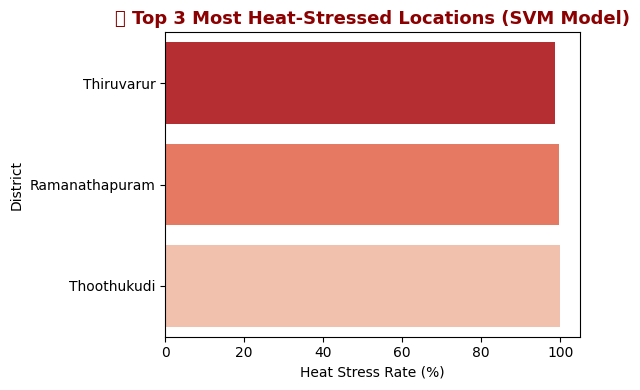

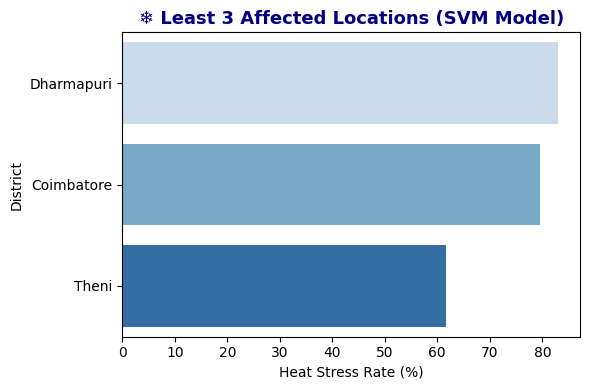

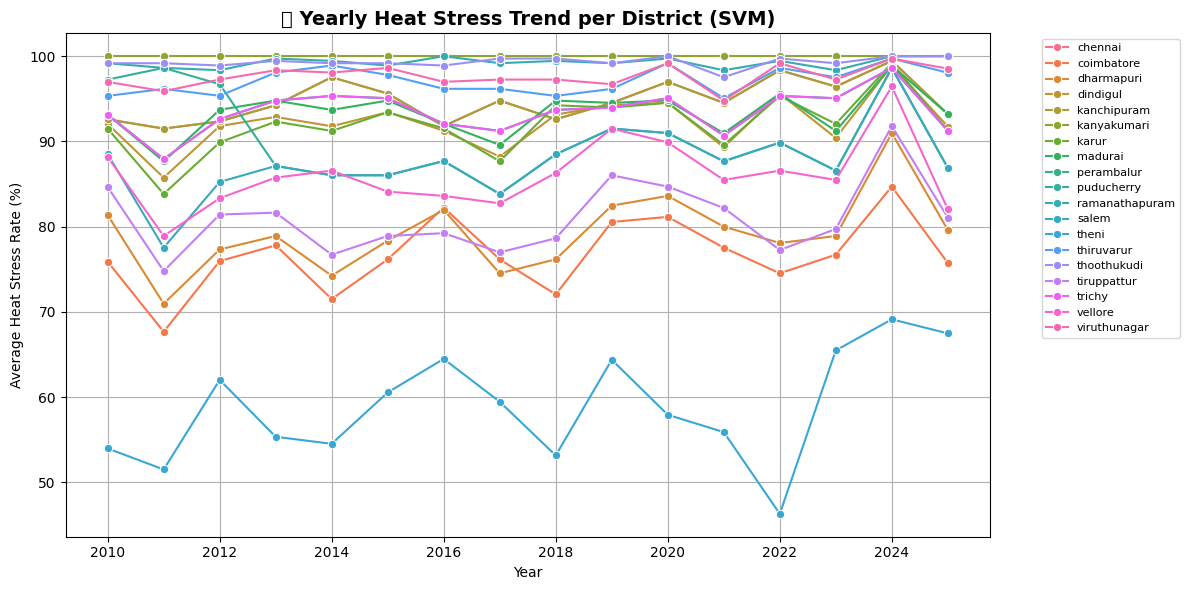


📈 Average Heat Stress Rate by Year (All Districts):
    year  Heat_Stress_Rate
0   2010             89.93
1   2011             85.58
2   2012             89.33
3   2013             89.86
4   2014             89.14
5   2015             89.88
6   2016             89.56
7   2017             87.76
8   2018             88.94
9   2019             91.52
10  2020             91.86
11  2021             88.55
12  2022             90.18
13  2023             89.92
14  2024             95.94
15  2025             89.55


In [ ]:
# --- 📦 Import Libraries ---
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings("ignore")

# --- 1️⃣ Load Dataset ---
file_path = "/content/labeled_dataset.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")

# --- 2️⃣ Ensure Date Column ---
if "date" not in df.columns:
    df["date"] = pd.date_range(start="2020-01-01", periods=len(df), freq="D")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# --- 3️⃣ Encode Heat Stress Labels ---
le = LabelEncoder()
df["Heat_Stress_Label"] = le.fit_transform(df["Heat_Stress_Label"])
df["Binary_Label"] = df["Heat_Stress_Label"].apply(lambda x: 1 if x in [0, 2] else 0)

# --- 4️⃣ Define Features ---
features = ["t2m_min", "t2m_max", "rh2m", "ws2m", "prectotcorr", "ps"]

# --- 5️⃣ Complete Coordinate List for All Districts ---
district_coords = {
    "Thoothukudi": (8.7642, 78.1348),
    "Ramanathapuram": (9.3647, 78.8371),
    "Thiruvarur": (10.7720, 79.6368),
    "Viruthunagar": (9.5851, 77.9579),
    "Chennai": (13.0827, 80.2707),
    "Kanchipuram": (12.8376, 79.7016),
    "Trichy": (10.7905, 78.7047),
    "Perambalur": (11.2342, 78.8800),
    "Karur": (10.9601, 78.0766),
    "Madurai": (9.9252, 78.1198),
    "Dindigul": (10.3673, 77.9803),
    "Puducherry": (11.9139, 79.8145),
    "Salem": (11.6643, 78.1460),
    "Vellore": (12.9165, 79.1325),
    "Tiruppattur": (12.4993, 78.5678),
    "Dharmapuri": (12.1211, 78.1582),
    "Coimbatore": (11.0168, 76.9558),
    "Theni": (10.0104, 77.4768)
}

# --- 6️⃣ Train SVM Model per District ---
results = []
for district, (lat, lon) in district_coords.items():
    sub_df = df[df["place"].str.title() == district]

    if len(sub_df) < 10 or len(np.unique(sub_df["Binary_Label"])) < 2:
        results.append({
            "District": district,
            "Latitude": lat,
            "Longitude": lon,
            "Accuracy": 0,
            "Precision": 0,
            "Recall": 0,
            "F1_Score": 0,
            "Heat_Stress_Rate": 0
        })
        continue

    X = sub_df[features].values
    y = sub_df["Binary_Label"].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    split = int(0.8 * len(X_scaled))
    X_train, X_test = X_scaled[:split], X_scaled[split:]
    y_train, y_test = y[:split], y[split:]

    model = SVC(kernel="rbf", probability=True, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    heat_rate = (y_pred.sum() / len(y_pred)) * 100

    results.append({
        "District": district,
        "Latitude": lat,
        "Longitude": lon,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1_Score": f1,
        "Heat_Stress_Rate": heat_rate
    })

spatial_df = pd.DataFrame(results).sort_values("Heat_Stress_Rate", ascending=False)

# --- 7️⃣ Summary ---
print("\n📊 Spatial Heat Stress Summary (SVM):")
print(spatial_df[["District", "Heat_Stress_Rate"]].round(2))

top3 = spatial_df.nlargest(3, "Heat_Stress_Rate")[["District", "Heat_Stress_Rate"]]
least3 = spatial_df.nsmallest(3, "Heat_Stress_Rate")[["District", "Heat_Stress_Rate"]]

print("\n🔥 Top 3 Most Heat-Stressed Locations:")
print(top3.to_string(index=False))
print("\n❄️ Least 3 Affected Locations:")
print(least3.to_string(index=False))

# ==========================================================
# 🎨 8️⃣ Visualization Section
# ==========================================================

# --- 🌍 Static Spatial Heat Stress Summary ---
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Heat_Stress_Rate",
    y="District",
    data=spatial_df.sort_values("Heat_Stress_Rate", ascending=False),
    palette="coolwarm"
)
plt.title("🌍 Spatial Heat Stress Summary Across All Districts (SVM Model)", fontsize=14, weight="bold")
plt.xlabel("Heat Stress Rate (%)")
plt.ylabel("District")
for i, v in enumerate(spatial_df.sort_values("Heat_Stress_Rate", ascending=False)["Heat_Stress_Rate"]):
    plt.text(v + 0.4, i, f"{v:.1f}%", va='center', fontsize=9, weight="bold")
plt.tight_layout()
plt.show()

# --- 🔥 Top 3 ---
plt.figure(figsize=(6,4))
sns.barplot(
    x="Heat_Stress_Rate",
    y="District",
    data=top3.sort_values("Heat_Stress_Rate", ascending=True),
    palette="Reds_r"
)
plt.title("🔥 Top 3 Most Heat-Stressed Locations (SVM Model)", fontsize=13, weight="bold", color='darkred')
plt.xlabel("Heat Stress Rate (%)")
plt.ylabel("District")
plt.tight_layout()
plt.show()

# --- ❄️ Least 3 ---
plt.figure(figsize=(6,4))
sns.barplot(
    x="Heat_Stress_Rate",
    y="District",
    data=least3.sort_values("Heat_Stress_Rate", ascending=False),
    palette="Blues"
)
plt.title("❄️ Least 3 Affected Locations (SVM Model)", fontsize=13, weight="bold", color='navy')
plt.xlabel("Heat Stress Rate (%)")
plt.ylabel("District")
plt.tight_layout()
plt.show()

# --- 🗺️ Interactive Spatial Map ---
fig = px.scatter_mapbox(
    spatial_df,
    lat="Latitude", lon="Longitude",
    size="Heat_Stress_Rate",
    color="Heat_Stress_Rate",
    hover_name="District",
    color_continuous_scale="thermal",
    size_max=25,
    mapbox_style="carto-positron",
    zoom=6,
    title="🗺️ Spatial Heat Stress Distribution (SVM Model) – All Districts"
)
fig.update_traces(marker=dict(opacity=0.85)) # Removed the invalid 'line' property
fig.show()

# ======================================================
# 🔄 9️⃣ Spatio-Temporal Fusion: Yearly Trends per District
# ======================================================
temporal_trends = (
    df.groupby(["year", "place"])["Binary_Label"]
    .mean()
    .reset_index()
    .rename(columns={"Binary_Label": "Heat_Stress_Rate"})
)
temporal_trends["Heat_Stress_Rate"] *= 100

plt.figure(figsize=(12,6))
sns.lineplot(data=temporal_trends, x="year", y="Heat_Stress_Rate", hue="place", marker="o")
plt.title("📆 Yearly Heat Stress Trend per District (SVM)", fontsize=14, weight="bold")
plt.xlabel("Year")
plt.ylabel("Average Heat Stress Rate (%)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# --- 🔟 Fusion Summary ---
yearly_summary = temporal_trends.groupby("year")["Heat_Stress_Rate"].mean().reset_index()
print("\n📈 Average Heat Stress Rate by Year (All Districts):")
print(yearly_summary.round(2))